In [1]:
# OutfitTransformer TFG

# Requirements needed: (python3.12)
# - pip:
#    - torch==2.5.0
#    - torchvision==0.20.0
#    - torchaudio==2.5.0
#    - pillow==11.0.0
#    - transformers==4.48.3
#    - scikit-learn
#    - faiss-cpu
#    - wandb
#    - tqdm
#    - gradio
#    - opencv-python
#

# To dowload the data:
    # mkdir -p datasets
    # gdown --id 1ox8GFHG8iMs64iiwITQhJ47dkQ0Q7SBu -O polyvore.zip
    # unzip polyvore.zip -d ./datasets/polyvore
    # rm polyvore.zip

In [2]:

# ------------------------------
# Section 1: Setup and Imports
# ------------------------------

# Import standard libraries for data handling, logging, and visualization
import json
import logging
import os
import pathlib
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from tqdm import tqdm
from typing import Any, Dict, List, Literal, Optional
from dataclasses import dataclass
import os

# Import PyTorch and related modules for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn.functional as F

# Import torchvision for image preprocessing
import torchvision.transforms as transforms

# Import transformers for CLIP model
from transformers import CLIPProcessor, CLIPModel

# Import sklearn for metrics
from sklearn.metrics import roc_auc_score


/home/ia/Documentos/TFG_Lara/TransformingFashion/outfit_transformer_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# Disable tokenizer parallelism to avoid warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Define project-wide paths
SRC_DIR = pathlib.Path(os.getcwd()).absolute()
LOGS_DIR = SRC_DIR / 'logs'
CHECKPOINT_DIR = SRC_DIR / 'checkpoints'
POLYVORE_DIR = './datasets/polyvore'
POLYVORE_METADATA_PATH = f"{POLYVORE_DIR}/item_metadata.json"
POLYVORE_IMAGE_DATA_PATH = f"{POLYVORE_DIR}/images/{{item_id}}.jpg"
POLYVORE_PRECOMPUTED_CLIP_EMBEDDING_DIR = f"{POLYVORE_DIR}/precomputed_clip_embeddings"
POLYVORE_TASK_DATA_PATH = f"{POLYVORE_DIR}/{{dataset_type}}/{{dataset_task}}/{{dataset_split}}.json"
POLYVORE_SET_DATA_PATH = f"{POLYVORE_DIR}/{{dataset_type}}/{{dataset_split}}.json"

# Create directories if they don't exist
os.makedirs(LOGS_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR / 'compatibility_clip', exist_ok=True)
os.makedirs(CHECKPOINT_DIR / 'complementary_clip', exist_ok=True)
os.makedirs(POLYVORE_PRECOMPUTED_CLIP_EMBEDDING_DIR, exist_ok=True)

# Configure logging for the entire notebook
logging.basicConfig(
    filename=LOGS_DIR / 'outfit_transformer.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('outfit_transformer')

# Log notebook start
logger.info("Starting OutfitTransformer notebook")
print("Starting OutfitTransformer notebook")


Starting OutfitTransformer notebook


In [4]:

# ------------------------------
# Section 2: Utility Functions and Classes
# ------------------------------

# Utility function to set random seeds for reproducibility
def seed_everything(seed=42):
    """Set random seeds for reproducibility across random, numpy, and PyTorch.
    
    Args:
        seed (int): Random seed value (default: 42).
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    logger.info(f"Set random seed to {seed}")

# Set seed for reproducibility
seed_everything(42)

# FashionItem class to represent items in the Polyvore dataset
class FashionItem:
    """Represents a fashion item with metadata, image, and embedding.
    
    Attributes:
        item_id (str): Unique identifier for the item.
        category (str): Semantic category (e.g., top, bottom, shoes).
        image (PIL.Image or None): Loaded image of the item.
        description (str): Text description or title of the item.
        metadata (dict): Additional metadata from item_metadata.json.
        embedding (np.ndarray or None): Precomputed CLIP embedding (1024,).
    """
    def __init__(self, item_id, category, image=None, description="", metadata=None, embedding=None):
        self.item_id = item_id
        self.category = category
        self.image = image
        self.description = description
        self.metadata = metadata or {}
        self.embedding = embedding

# Load metadata from item_metadata.json
def load_metadata(dataset_dir):
    """Load item metadata from item_metadata.json.
    
    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.
    
    Returns:
        dict: Dictionary mapping item_id to metadata.
    """
    metadata = {}
    with open(POLYVORE_METADATA_PATH.format(dataset_dir=dataset_dir), 'r') as f:
        metadata_ = json.load(f)
        for item in metadata_:
            metadata[item['item_id']] = item
    logger.info(f"Loaded {len(metadata)} metadata entries")
    print(f"Loaded {len(metadata)} metadata entries")
    return metadata

# Load image for an item
def load_image(dataset_dir, item_id, size=(224, 224)):
    """Load an image for a given item_id.
    
    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.
        item_id (str): Unique identifier for the item.
        size (tuple): Target image size (height, width) (default: (224, 224)).
    
    Returns:
        PIL.Image or None: Loaded image or None if loading fails.
    """
    image_path = POLYVORE_IMAGE_DATA_PATH.format(dataset_dir=dataset_dir, item_id=item_id)
    try:
        image = Image.open(image_path).convert('RGB')
        return image
    except Exception as e:
        logger.error(f"Error loading image {image_path}: {e}")
        print(f"Error loading image {image_path}: {e}")
        return None

# Load a FashionItem object
def load_item(dataset_dir, metadata, item_id, should_load_image=False, embedding_dict=None):
    """Load a FashionItem object with metadata, image, and embedding.
    
    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.
        metadata (dict): Dictionary of item metadata.
        item_id (str): Unique identifier for the item.
        should_load_image (bool): Whether to load the item image.
        embedding_dict (dict or None): Dictionary mapping item_id to CLIP embedding.
    
    Returns:
        FashionItem: Object containing item data.
    """
    metadata_ = metadata[item_id]
    return FashionItem(
        item_id=metadata_['item_id'],
        category=metadata_['semantic_category'],
        image=load_image(dataset_dir, metadata_['item_id']) if should_load_image else None,
        description=metadata_['title'] if metadata_.get('title') else metadata_['url_name'],
        metadata=metadata_,
        embedding=embedding_dict[item_id] if embedding_dict else None
    )

# Load precomputed CLIP embeddings
def load_embedding_dict(dataset_dir):
    """Load precomputed CLIP embeddings from .pkl files.
    
    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.
    
    Returns:
        dict: Dictionary mapping item_id to embedding (1024,).
    """
    e_dir = POLYVORE_PRECOMPUTED_CLIP_EMBEDDING_DIR.format(polyvore_dir=dataset_dir)
    filenames = [f for f in os.listdir(e_dir) if f.endswith('.pkl') and 'official' not in f]
    filenames.sort(key=lambda x: int(x.split('.')[0].split('_')[-1]))
    
    all_ids, all_embeddings = [], []
    for filename in filenames:
        filepath = os.path.join(e_dir, filename)
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            all_ids += data['ids']
            all_embeddings.append(data['embeddings'])
    
    all_embeddings = np.concatenate(all_embeddings, axis=0)  # (n_items, 1024)
    embedding_dict = {item_id: embedding for item_id, embedding in zip(all_ids, all_embeddings)}
    logger.info(f"Loaded {len(all_embeddings)} embeddings into dictionary")
    print(f"Loaded {len(all_embeddings)} embeddings into dictionary")
    return embedding_dict

# Load task data from JSON files
def load_task_data(dataset_dir, dataset_type, task, dataset_split):
    """Load task-specific data from JSON files.
    
    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.
        dataset_type (str): Dataset type (e.g., 'nondisjoint').
        task (str): Task name (e.g., 'compatibility', 'fill_in_the_blank').
        dataset_split (str): Dataset split (e.g., 'train', 'valid', 'test').
    
    Returns:
        list: List of task data entries.
    """
    with open(
        POLYVORE_TASK_DATA_PATH.format(
            dataset_dir=dataset_dir,
            dataset_type=dataset_type,
            dataset_task=task,
            dataset_split=dataset_split
        ), 'r'
    ) as f:
        data = json.load(f)
    logger.info(f"Loaded {len(data)} {task} {dataset_split} entries")
    return data

# Load set data for CIR training
def load_set_data(dataset_dir, dataset_type, dataset_split):
    """Load set data for CIR training from JSON files.
    
    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.
        dataset_type (str): Dataset type (e.g., 'nondisjoint').
        dataset_split (str): Dataset split (e.g., 'train', 'valid', 'test').
    
    Returns:
        list: List of set data entries.
    """
    with open(
        POLYVORE_SET_DATA_PATH.format(
            dataset_dir=dataset_dir,
            dataset_type=dataset_type,
            dataset_split=dataset_split
        ), 'r'
    ) as f:
        data = json.load(f)
    logger.info(f"Loaded {len(data)} {dataset_split} set entries")
    return data


def load_checkpoint(model, checkpoint_path):
    """Load a model's state dictionary from a checkpoint file.

    Args:
        model (nn.Module): The model to load the state dictionary into.
        checkpoint_path (str): Path to the checkpoint file (.pth).

    Returns:
        nn.Module: The model with the loaded state dictionary, set to evaluation mode.

    Notes:
        - The checkpoint file is expected to contain a dictionary with a 'model' key
          mapping to the state dictionary.
        - The function uses map_location to ensure compatibility with CPU/GPU environments.
    """
    checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(checkpoint['model'])
    model.eval()
    logger.info(f"Loaded checkpoint from {checkpoint_path}")
    return model


In [5]:

# ------------------------------
# Section 3: Generate CLIP Embeddings
# ------------------------------

# Dataset for generating CLIP embeddings
class PolyvoreItemDataset(Dataset):
    """Dataset for loading Polyvore items to generate CLIP embeddings.
    
    Attributes:
        dataset_dir (str): Path to the Polyvore dataset directory.
        metadata (dict): Item metadata.
        load_image (bool): Whether to load images.
        all_item_ids (list): List of all item IDs.
    """
    def __init__(self, dataset_dir, metadata=None, load_image=False):
        self.dataset_dir = dataset_dir
        self.metadata = metadata if metadata else load_metadata(dataset_dir)
        self.load_image = load_image
        self.all_item_ids = list(self.metadata.keys())
        logger.info(f"Initialized PolyvoreItemDataset with {len(self.all_item_ids)} items")

    def __len__(self):
        return len(self.all_item_ids)

    def __getitem__(self, idx):
        return load_item(self.dataset_dir, self.metadata, self.all_item_ids[idx], 
                         should_load_image=self.load_image)

# Collate function for item dataset
def item_collate_fn(batch):
    """Collate function for PolyvoreItemDataset.
    
    Args:
        batch (list): List of FashionItem objects.
    
    Returns:
        list: List of FashionItem objects.
    """
    return [item for item in batch]

# Distributed setup for DDP
def setup(rank, world_size):
    """Initialize DDP process group.
    
    Args:
        rank (int): Rank of the current process.
        world_size (int): Total number of processes (GPUs).
    """
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'
    dist.init_process_group("nccl", rank=rank, world_size=world_size)
    logger.info(f"DDP initialized for rank {rank}")

def cleanup():
    """Destroy DDP process group."""
    dist.destroy_process_group()
    logger.info("DDP process group destroyed")

# Load CLIP model
def load_clip_model(checkpoint=None):
    """Load the Fashion-CLIP model.
    
    Args:
        checkpoint (str or None): Path to a checkpoint (not used in this case).
    
    Returns:
        tuple: (CLIPModel, CLIPProcessor).
    """
    model = CLIPModel.from_pretrained("patrickjohncyh/fashion-clip")
    processor = CLIPProcessor.from_pretrained("patrickjohncyh/fashion-clip")
    model.eval()
    logger.info("Loaded Fashion-CLIP model and processor")
    return model, processor

# Compute CLIP embeddings
def precompute_clip_embedding(model, processor, batch):
    """Compute CLIP embeddings for a batch of items.
    
    Args:
        model (CLIPModel): Fashion-CLIP model.
        processor (CLIPProcessor): CLIP processor.
        batch (list): List of FashionItem objects.
    
    Returns:
        np.ndarray: Concatenated image and text embeddings (batch_size, 1024).
    """
    images = [item.image for item in batch]
    texts = [item.description for item in batch]
    
    # Process images and texts
    # Input: images (list of PIL.Image), texts (list of str)
    # Output: inputs (dict with 'pixel_values' (batch_size, 3, 224, 224), 'input_ids', etc.)
    inputs = processor(images=images, text=texts, return_tensors="pt", padding=True, 
                      truncation=True, max_length=64)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    # Generate embeddings
    # Input: pixel_values (batch_size, 3, 224, 224), input_ids (batch_size, seq_len)
    # Output: image_embeds (batch_size, 512), text_embeds (batch_size, 512)
    with torch.no_grad():
        outputs = model(**inputs)
        image_embeds = outputs.image_embeds  # (batch_size, 512)
        text_embeds = outputs.text_embeds    # (batch_size, 512)
        embeddings = torch.cat((image_embeds, text_embeds), dim=-1)  # (batch_size, 1024)
    
    return embeddings.cpu().numpy()  # (batch_size, 1024)

# Main function to compute embeddings
def compute_clip_embeddings(rank, world_size, args):
    """Compute and save CLIP embeddings for Polyvore items using DDP.
    
    Args:
        rank (int): Rank of the current process.
        world_size (int): Total number of processes (GPUs).
        args (Args): Configuration arguments.
    """
    # Initialize DDP
    if world_size > 1:
        setup(rank, world_size)
    
    # Load dataset
    item_dataset = PolyvoreItemDataset(
        dataset_dir=args.polyvore_dir,
        load_image=True
    )
    
    # Split dataset across GPUs
    n_items = len(item_dataset)
    n_items_per_gpu = n_items // world_size
    start_idx = n_items_per_gpu * rank
    end_idx = start_idx + n_items_per_gpu if rank < world_size - 1 else n_items
    item_dataset = torch.utils.data.Subset(item_dataset, range(start_idx, end_idx))
    logger.info(f"Rank {rank}: Processing items {start_idx} to {end_idx}")
    
    # Create DataLoader
    item_dataloader = DataLoader(
        dataset=item_dataset,
        batch_size=args.batch_sz_per_gpu,
        shuffle=False,
        num_workers=args.n_workers_per_gpu,
        collate_fn=item_collate_fn
    )
    
    # Load CLIP model
    model, processor = load_clip_model()
    model.to(rank)
    if world_size > 1:
        model = nn.parallel.DistributedDataParallel(model, device_ids=[rank])
    
    # Compute embeddings
    all_ids, all_embeddings = [], []
    with torch.no_grad():
        for batch in tqdm(item_dataloader, desc=f"Rank {rank} Computing Embeddings"):
            if args.demo and len(all_embeddings) > 10:
                break
            embeddings = precompute_clip_embedding(model.module if world_size > 1 else model, 
                                                  processor, batch)  # (batch_size, 1024)
            all_ids.extend([item.item_id for item in batch])
            all_embeddings.append(embeddings)
    
    all_embeddings = np.concatenate(all_embeddings, axis=0)  # (n_items_per_gpu, 1024)
    logger.info(f"Rank {rank}: Computed {len(all_embeddings)} embeddings")
    print(f"Rank {rank}: Computed {len(all_embeddings)} embeddings")
    
    # Save embeddings
    save_path = f"{POLYVORE_PRECOMPUTED_CLIP_EMBEDDING_DIR}/polyvore_{rank}.pkl"
    with open(save_path, 'wb') as f:
        pickle.dump({'ids': all_ids, 'embeddings': all_embeddings}, f)
    logger.info(f"Rank {rank}: Saved embeddings to {save_path}")
    print(f"Rank {rank}: Saved embeddings to {save_path}")
    
    # Cleanup DDP
    if world_size > 1:
        cleanup()

# Configuration for embedding generation
class EmbeddingArgs:
    """Configuration for generating CLIP embeddings."""
    model_type = 'clip'
    polyvore_dir = POLYVORE_DIR
    polyvore_type = 'nondisjoint'
    batch_sz_per_gpu = 128
    n_workers_per_gpu = 4
    checkpoint = None
    world_size = torch.cuda.device_count() if torch.cuda.is_available() else 1
    demo = False

embedding_args = EmbeddingArgs()
logger.info(f"Embedding Arguments: {vars(embedding_args)}")
print(f"Embedding Arguments: {vars(embedding_args)}")


Embedding Arguments: {}


In [6]:

# Run embedding computation
# check if the embedding file already exists
embedding_files = [f for f in os.listdir(POLYVORE_PRECOMPUTED_CLIP_EMBEDDING_DIR) if f.endswith('.pkl')]
if embedding_files:
    logger.info("Precomputed CLIP embeddings already exist. Skipping computation.")
    print("Precomputed CLIP embeddings already exist. Skipping computation.")
else:
    logger.info("Starting computation of CLIP embeddings")
    print("Starting computation of CLIP embeddings")
    if embedding_args.world_size > 1:

        logger.info("Starting distributed computation of CLIP embeddings")
        print("Starting distributed computation of CLIP embeddings") 
        mp.spawn(
            compute_clip_embeddings,
            args=(embedding_args.world_size, embedding_args),
            nprocs=embedding_args.world_size,
            join=True
        )
    else:
        compute_clip_embeddings(0, 1, embedding_args)


Precomputed CLIP embeddings already exist. Skipping computation.


In [7]:

# ------------------------------
# Section 4: Train Compatibility Prediction (CP)
# ------------------------------

# Dataset for CP training
class PolyvoreCompatibilityDataset(Dataset):
    """Dataset for Compatibility Prediction task.
    
    Attributes:
        dataset_dir (str): Path to the Polyvore dataset directory.
        metadata (dict): Item metadata.
        data (list): List of outfit data with labels.
        load_image (bool): Whether to load images.
        embedding_dict (dict): Dictionary mapping item_id to CLIP embedding.
    
    Data Format:
        Each item in data is a dict with:
            'question': List of item IDs for the outfit.
            'label': Binary label (0: incompatible, 1: compatible).
    """
    def __init__(self, dataset_dir, dataset_type='nondisjoint', dataset_split='train', 
                 metadata=None, load_image=False, embedding_dict=None):
        self.dataset_dir = dataset_dir
        self.metadata = metadata if metadata else load_metadata(dataset_dir)
        self.data = load_task_data(dataset_dir, dataset_type, 'compatibility', dataset_split)
        self.load_image = load_image
        self.embedding_dict = embedding_dict
        # Validate label distribution
        labels = [item['label'] for item in self.data]
        label_counts = Counter(labels)
        logger.info(f"{dataset_split} CP dataset: {len(self.data)} outfits, Label distribution: {label_counts}")
        print(f"{dataset_split} CP dataset: {len(self.data)} outfits, Label distribution: {label_counts}")

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Return outfit and label
        label = self.data[idx]['label']
        outfit = [
            load_item(self.dataset_dir, self.metadata, item_id, self.load_image, self.embedding_dict)
            for item_id in self.data[idx]['question']
        ]
        return {'label': label, 'query': outfit}

# Collate function for CP
def cp_collate_fn(batch):
    """Collate function for PolyvoreCompatibilityDataset.
    
    Args:
        batch (list): List of dicts with 'label' and 'query'.
    
    Returns:
        dict: Dictionary with 'label' (list of int) and 'query' (list of lists of FashionItem).
    """
    labels = [item['label'] for item in batch]
    queries = [item['query'] for item in batch]
    return {'label': labels, 'query': queries}

# Focal Loss for CP
class FocalLoss(nn.Module):
    """Focal Loss for binary classification, emphasizing hard examples.
    
    Args:
        gamma (float): Focusing parameter (default: 2).
        alpha (float): Weight for positive class (default: 0.5).
        reduction (str): Reduction method ('mean', 'sum', or 'none').
    
    Forward:
        Input:
            y_prob (torch.Tensor): Predicted logits (batch_size,).
            y_true (torch.Tensor): True labels (batch_size,).
        Output:
            torch.Tensor: Scalar loss (if reduction='mean').
    """
    def __init__(self, gamma=2, alpha=0.5, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, y_prob, y_true):
        ce_loss = F.binary_cross_entropy_with_logits(y_prob, y_true, reduction="none")
        p_t = y_prob * y_true + (1 - y_prob) * (1 - y_true)
        loss = ce_loss * ((1 - p_t) ** self.gamma)
        if self.alpha >= 0:
            alpha_t = self.alpha * y_true + (1 - self.alpha) * (1 - y_true)
            loss = alpha_t * loss
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

# Metrics for CP
def compute_cp_scores(predictions, labels):
    """Compute metrics for Compatibility Prediction.
    
    Args:
        predictions (torch.Tensor): Predicted logits (batch_size,).
        labels (torch.Tensor): True labels (batch_size,).
    
    Returns:
        dict: Metrics including 'acc', 'precision', 'recall', 'f1', 'auc'.
    """
    try:
        auc = roc_auc_score(labels.detach().cpu().numpy(), 
                           predictions.detach().cpu().numpy()) if len(torch.unique(labels)) > 1 else 0.0
    except ValueError as e:
        logger.warning(f"AUC calculation failed: {e}. Setting auc=0.0")
        auc = 0.0
    predictions = (predictions > 0).int()  # Threshold at 0 for logits
    tp = torch.sum((predictions == 1) & (labels == 1)).item()
    fp = torch.sum((predictions == 1) & (labels == 0)).item()
    fn = torch.sum((predictions == 0) & (labels == 1)).item()
    accuracy = torch.mean((predictions == labels).float()).item()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    return {'acc': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc}

# Configuration for OutfitTransformer
@dataclass
class OutfitTransformerConfig:
    """Configuration for OutfitTransformer model."""
    n_items: int = 251008  # Number of unique items in Polyvore
    d_model: int = 128     # Embedding dimension
    n_layers: int = 4      # Number of transformer layers
    n_head: int = 4        # Number of attention heads
    dropout: float = 0.1   # Dropout rate
    item_enc_norm_out: bool = True
    aggregation_method: str = 'concat'

@dataclass
class OutfitCLIPTransformerConfig(OutfitTransformerConfig):
    """Configuration for OutfitCLIPTransformer, extending OutfitTransformerConfig."""
    item_enc_clip_model_name: str = "patrickjohncyh/fashion-clip"

# OutfitTransformer model
class OutfitTransformer(nn.Module):
    """Transformer model for outfit compatibility prediction.
    
    Architecture:
        - Input: List of outfits, each a list of FashionItem objects with CLIP embeddings (1024,).
        - Linear layer: Projects CLIP embeddings to d_model (1024 -> 128).
        - CLS token: Learnable token prepended to each outfit sequence.
        - Transformer Encoder: Processes outfit embeddings with attention.
        - Classification Head: Maps CLS token embedding to a logit.
    
    Args:
        cfg (OutfitTransformerConfig): Model configuration.
    
    Forward:
        Input:
            queries (List[List[FashionItem]]): Batch of outfits, each a list of items.
            use_precomputed_embedding (bool): Whether to use precomputed CLIP embeddings.
        Output:
            torch.Tensor: Logits (batch_size,) for compatibility prediction.
    """
    def __init__(self, cfg=OutfitTransformerConfig()):
        super().__init__()
        self.cfg = cfg
        # Linear layer to project CLIP embeddings (1024,) to model dimension (128,)
        self.fc = nn.Linear(1024, cfg.d_model)
        # Transformer encoder layer with multi-head attention
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=cfg.d_model, nhead=cfg.n_head, dropout=cfg.dropout, batch_first=True
        )
        # Stack of transformer encoder layers
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=cfg.n_layers)
        # Learnable CLS token for outfit representation
        self.cls_token = nn.Parameter(torch.randn(1, 1, cfg.d_model))
        # Classification head to predict compatibility
        self.classification_head = nn.Linear(cfg.d_model, 1)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def forward(self, queries, use_precomputed_embedding=True):
        # queries: List of outfits, each a list of FashionItem objects
        batch_size = len(queries)  # Number of outfits in the batch
        max_len = max(len(query) for query in queries)  # Maximum number of items in any outfit
        
        # Prepare embeddings and mask
        embeddings = []
        mask = []
        for query in queries:
            # Extract precomputed CLIP embeddings for each item
            # Shape: (seq_len, 1024), where seq_len is number of items in outfit
            outfit_embeds = torch.from_numpy(np.array([item.embedding for item in query])).to(
                dtype=torch.float32, device=self.device
            )
            # Pad embeddings to max_len
            padded_embeds = torch.zeros(max_len, 1024, device=self.device)
            padded_embeds[:len(query)] = outfit_embeds
            embeddings.append(padded_embeds)
            # Create mask: 0 for valid items, 1 for padding
            outfit_mask = torch.zeros(max_len, device=self.device)
            outfit_mask[len(query):] = 1
            mask.append(outfit_mask)
        
        # Stack embeddings and mask
        embeddings = torch.stack(embeddings, dim=0)  # (batch_size, max_len, 1024)
        mask = torch.stack(mask, dim=0)  # (batch_size, max_len)
        
        # Project embeddings to model dimension
        embeddings = self.fc(embeddings)  # (batch_size, max_len, d_model)
        
        # Add CLS token
        cls_token = self.cls_token.expand(batch_size, -1, -1)  # (batch_size, 1, d_model)
        features = torch.cat([cls_token, embeddings], dim=1)  # (batch_size, max_len+1, d_model)
        
        # Update mask for CLS token
        cls_mask = torch.zeros(batch_size, 1, device=self.device)  # CLS token is valid (0)
        mask = torch.cat([cls_mask, mask], dim=1)  # (batch_size, max_len+1)
        
        # Apply transformer encoder
        # Input: features (batch_size, max_len+1, d_model), mask (batch_size, max_len+1)
        # Output: transformed_features (batch_size, max_len+1, d_model)
        transformed_features = self.transformer_encoder(features, src_key_padding_mask=mask.bool())
        
        # Extract CLS token embedding
        outfit_embedding = transformed_features[:, 0, :]  # (batch_size, d_model)
        
        # Predict compatibility
        logits = self.classification_head(outfit_embedding)  # (batch_size, 1)
        return logits.squeeze(-1)  # (batch_size,)

# OutfitCLIPTransformer model
class OutfitCLIPTransformer(OutfitTransformer):
    """OutfitTransformer specialized for CLIP embeddings.
    
    Args:
        cfg (OutfitCLIPTransformerConfig): Model configuration.
    """
    def __init__(self, cfg=OutfitCLIPTransformerConfig()):
        super().__init__(cfg)
        logger.info("Initialized OutfitCLIPTransformer")

# Training function for CP
def train_cp(args, model, train_dataloader, valid_dataloader, optimizer, scheduler, loss_fn, device):
    """Train the Compatibility Prediction model.
    
    Args:
        args (Args): Training arguments.
        model (OutfitCLIPTransformer): Model to train.
        train_dataloader (DataLoader): Training DataLoader.
        valid_dataloader (DataLoader): Validation DataLoader.
        optimizer (optim.Optimizer): Optimizer.
        scheduler (optim.lr_scheduler): Learning rate scheduler.
        loss_fn (nn.Module): Loss function (FocalLoss).
        device (torch.device): Device (CPU/GPU).
    
    Returns:
        tuple: Lists of train_losses, valid_losses, train_aucs, valid_aucs.
    """
    train_losses, valid_losses, train_aucs, valid_aucs = [], [], [], []
    
    for epoch in range(args.n_epochs):
        # Training
        model.train()
        train_loss, train_preds, train_labels = 0.0, [], []
        pbar = tqdm(train_dataloader, desc=f'Train CP Epoch {epoch+1}/{args.n_epochs}')
        for i, data in enumerate(pbar):
            queries = data['query']
            labels = torch.tensor(data['label'], dtype=torch.float32).to(device)
            # Forward pass
            # Input: queries (batch_size lists of FashionItem)
            # Output: preds (batch_size,) logits
            preds = model(queries, use_precomputed_embedding=True)
            # Compute loss
            loss = loss_fn(preds, labels) / args.accumulation_steps
            loss.backward()
            # Gradient accumulation
            if (i + 1) % args.accumulation_steps == 0:
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()
                scheduler.step()
            train_loss += loss.item() * args.accumulation_steps
            train_preds.append(preds.detach())
            train_labels.append(labels.detach())
            pbar.set_postfix(loss=loss.item() * args.accumulation_steps)
        
        train_loss /= len(train_dataloader)
        train_preds = torch.cat(train_preds)
        train_labels = torch.cat(train_labels)
        train_scores = compute_cp_scores(train_preds, train_labels)
        train_losses.append(train_loss)
        train_aucs.append(train_scores['auc'])
        logger.info(f'Epoch {epoch+1}/{args.n_epochs} Train CP --> Loss: {train_loss:.4f}, '
                   f'AUC: {train_scores["auc"]:.4f}, Acc: {train_scores["acc"]:.4f}, '
                   f'F1: {train_scores["f1"]:.4f}')
        print(f'Epoch {epoch+1}/{args.n_epochs} Train CP --> Loss: {train_loss:.4f}, '
              f'AUC: {train_scores["auc"]:.4f}, Acc: {train_scores["acc"]:.4f}, '
              f'F1: {train_scores["f1"]:.4f}')
        
        # Validation
        model.eval()
        valid_loss, valid_preds, valid_labels = 0.0, [], []
        pbar = tqdm(valid_dataloader, desc=f'Valid CP Epoch {epoch+1}/{args.n_epochs}')
        with torch.no_grad():
            for data in pbar:
                queries = data['query']
                labels = torch.tensor(data['label'], dtype=torch.float32).to(device)
                preds = model(queries, use_precomputed_embedding=True)
                loss = loss_fn(preds, labels)
                valid_loss += loss.item()
                valid_preds.append(preds)
                valid_labels.append(labels)
                pbar.set_postfix(loss=loss.item())
        
        valid_loss /= len(valid_dataloader)
        valid_preds = torch.cat(valid_preds)
        valid_labels = torch.cat(valid_labels)
        valid_scores = compute_cp_scores(valid_preds, valid_labels)
        valid_losses.append(valid_loss)
        valid_aucs.append(valid_scores['auc'])
        logger.info(f'Epoch {epoch+1}/{args.n_epochs} Valid CP --> Loss: {valid_loss:.4f}, '
                   f'AUC: {valid_scores["auc"]:.4f}, Acc: {valid_scores["acc"]:.4f}, '
                   f'F1: {valid_scores["f1"]:.4f}')
        print(f'Epoch {epoch+1}/{args.n_epochs} Valid CP --> Loss: {valid_loss:.4f}, '
              f'AUC: {valid_scores["auc"]:.4f}, Acc: {valid_scores["acc"]:.4f}, '
              f'F1: {valid_scores["f1"]:.4f}')
        
        # Save checkpoint
        checkpoint_path = os.path.join(CHECKPOINT_DIR, 'compatibility_clip', f'epoch_{epoch+1}.pth')
        torch.save({'config': model.cfg.__dict__, 'model': model.state_dict()}, checkpoint_path)
        logger.info(f'Checkpoint saved at {checkpoint_path}')
        print(f'Checkpoint saved at {checkpoint_path}')
    
    return train_losses, valid_losses, train_aucs, valid_aucs

# Configuration for CP training
class CPArgs:
    """Configuration for Compatibility Prediction training."""
    model_type = 'clip'
    polyvore_dir = POLYVORE_DIR
    polyvore_type = 'nondisjoint'
    batch_sz_per_gpu = 32
    n_workers_per_gpu = 4
    n_epochs = 200
    lr = 2e-5
    accumulation_steps = 4
    wandb_key = None
    seed = 42
    checkpoint = None
    world_size = 1
    project_name = 'compatibility_clip_notebook'
    demo = False


In [8]:

cp_args = CPArgs()
logger.info(f"CP Arguments: {vars(cp_args)}")
print(f"CP Arguments: {vars(cp_args)}")

# Load datasets for CP
metadata = load_metadata(cp_args.polyvore_dir)
embedding_dict = load_embedding_dict(cp_args.polyvore_dir)

train_dataset = PolyvoreCompatibilityDataset(
    dataset_dir=cp_args.polyvore_dir,
    dataset_type=cp_args.polyvore_type,
    dataset_split='train',
    metadata=metadata,
    load_image=False,
    embedding_dict=embedding_dict
)

valid_dataset = PolyvoreCompatibilityDataset(
    dataset_dir=cp_args.polyvore_dir,
    dataset_type=cp_args.polyvore_type,
    dataset_split='valid',
    metadata=metadata,
    load_image=False,
    embedding_dict=embedding_dict
)

# Create DataLoaders
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=cp_args.batch_sz_per_gpu,
    shuffle=True,
    num_workers=cp_args.n_workers_per_gpu,
    collate_fn=cp_collate_fn
)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=cp_args.batch_sz_per_gpu,
    shuffle=False,
    num_workers=cp_args.n_workers_per_gpu,
    collate_fn=cp_collate_fn
)

# Initialize model, optimizer, scheduler, and loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cp_model = OutfitCLIPTransformer(OutfitCLIPTransformerConfig(n_items=len(metadata))).to(device)
cp_optimizer = optim.AdamW(cp_model.parameters(), lr=cp_args.lr)
cp_scheduler = optim.lr_scheduler.OneCycleLR(
    cp_optimizer,
    max_lr=cp_args.lr,
    epochs=cp_args.n_epochs,
    steps_per_epoch=int(len(train_dataloader) / cp_args.accumulation_steps),
    pct_start=0.3,
    anneal_strategy='cos',
    div_factor=25,
    final_div_factor=1e4
)
cp_loss_fn = FocalLoss(alpha=0.5, gamma=2)


CP Arguments: {}
Loaded 251008 metadata entries
Loaded 251008 embeddings into dictionary
train CP dataset: 106612 outfits, Label distribution: Counter({1: 53306, 0: 53306})
valid CP dataset: 10000 outfits, Label distribution: Counter({1: 5000, 0: 5000})


In [ ]:

# Train CP model
train_losses, valid_losses, train_aucs, valid_aucs = train_cp(
    cp_args, cp_model, train_dataloader, valid_dataloader, 
    cp_optimizer, cp_scheduler, cp_loss_fn, device
)

Train CP Epoch 1/200: 100%|██████████| 3332/3332 [00:31<00:00, 106.12it/s, loss=0.0796]


Epoch 1/200 Train CP --> Loss: 0.1198, AUC: 0.5032, Acc: 0.5007, F1: 0.6490


Valid CP Epoch 1/200:   0%|          | 0/313 [00:00<?, ?it/s]/home/ia/Documentos/TFG_Lara/TransformingFashion/outfit_transformer_env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
Valid CP Epoch 1/200: 100%|██████████| 313/313 [00:01<00:00, 162.69it/s, loss=0.0591]


Epoch 1/200 Valid CP --> Loss: 0.0831, AUC: 0.5045, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_1.pth


Train CP Epoch 2/200: 100%|██████████| 3332/3332 [00:31<00:00, 107.39it/s, loss=0.0887]


Epoch 2/200 Train CP --> Loss: 0.0884, AUC: 0.4980, Acc: 0.5000, F1: 0.6666


Valid CP Epoch 2/200: 100%|██████████| 313/313 [00:01<00:00, 165.15it/s, loss=0.0622]


Epoch 2/200 Valid CP --> Loss: 0.0827, AUC: 0.5092, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_2.pth


Train CP Epoch 3/200: 100%|██████████| 3332/3332 [00:31<00:00, 105.26it/s, loss=0.0946]


Epoch 3/200 Train CP --> Loss: 0.0867, AUC: 0.4998, Acc: 0.5000, F1: 0.6667


Valid CP Epoch 3/200: 100%|██████████| 313/313 [00:01<00:00, 158.38it/s, loss=0.0626]


Epoch 3/200 Valid CP --> Loss: 0.0826, AUC: 0.5128, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_3.pth


Train CP Epoch 4/200: 100%|██████████| 3332/3332 [00:31<00:00, 104.36it/s, loss=0.0791]


Epoch 4/200 Train CP --> Loss: 0.0859, AUC: 0.5009, Acc: 0.5000, F1: 0.6667


Valid CP Epoch 4/200: 100%|██████████| 313/313 [00:02<00:00, 147.78it/s, loss=0.0638]


Epoch 4/200 Valid CP --> Loss: 0.0826, AUC: 0.5162, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_4.pth


Train CP Epoch 5/200: 100%|██████████| 3332/3332 [00:31<00:00, 104.77it/s, loss=0.0738]


Epoch 5/200 Train CP --> Loss: 0.0852, AUC: 0.5030, Acc: 0.5000, F1: 0.6667


Valid CP Epoch 5/200: 100%|██████████| 313/313 [00:01<00:00, 161.07it/s, loss=0.0629]


Epoch 5/200 Valid CP --> Loss: 0.0826, AUC: 0.5176, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_5.pth


Train CP Epoch 6/200: 100%|██████████| 3332/3332 [00:31<00:00, 106.92it/s, loss=0.0882]


Epoch 6/200 Train CP --> Loss: 0.0850, AUC: 0.4994, Acc: 0.5000, F1: 0.6667


Valid CP Epoch 6/200: 100%|██████████| 313/313 [00:01<00:00, 164.93it/s, loss=0.0594]


Epoch 6/200 Valid CP --> Loss: 0.0828, AUC: 0.5208, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_6.pth


Train CP Epoch 7/200: 100%|██████████| 3332/3332 [00:31<00:00, 106.30it/s, loss=0.0817]


Epoch 7/200 Train CP --> Loss: 0.0845, AUC: 0.5029, Acc: 0.5000, F1: 0.6667


Valid CP Epoch 7/200: 100%|██████████| 313/313 [00:01<00:00, 159.04it/s, loss=0.0642]


Epoch 7/200 Valid CP --> Loss: 0.0825, AUC: 0.5278, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_7.pth


Train CP Epoch 8/200: 100%|██████████| 3332/3332 [00:31<00:00, 105.99it/s, loss=0.0852]


Epoch 8/200 Train CP --> Loss: 0.0842, AUC: 0.5020, Acc: 0.5000, F1: 0.6667


Valid CP Epoch 8/200: 100%|██████████| 313/313 [00:01<00:00, 160.29it/s, loss=0.0599]


Epoch 8/200 Valid CP --> Loss: 0.0827, AUC: 0.5338, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_8.pth


Train CP Epoch 9/200: 100%|██████████| 3332/3332 [00:31<00:00, 105.35it/s, loss=0.0769]


Epoch 9/200 Train CP --> Loss: 0.0839, AUC: 0.5061, Acc: 0.5000, F1: 0.6667


Valid CP Epoch 9/200: 100%|██████████| 313/313 [00:01<00:00, 156.54it/s, loss=0.055] 


Epoch 9/200 Valid CP --> Loss: 0.0831, AUC: 0.5436, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_9.pth


Train CP Epoch 10/200: 100%|██████████| 3332/3332 [00:31<00:00, 104.30it/s, loss=0.0799]


Epoch 10/200 Train CP --> Loss: 0.0837, AUC: 0.5057, Acc: 0.5000, F1: 0.6667


Valid CP Epoch 10/200: 100%|██████████| 313/313 [00:01<00:00, 161.06it/s, loss=0.0594]


Epoch 10/200 Valid CP --> Loss: 0.0826, AUC: 0.5617, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_10.pth


Train CP Epoch 11/200: 100%|██████████| 3332/3332 [00:31<00:00, 107.06it/s, loss=0.0862]


Epoch 11/200 Train CP --> Loss: 0.0836, AUC: 0.5033, Acc: 0.5000, F1: 0.6667


Valid CP Epoch 11/200: 100%|██████████| 313/313 [00:01<00:00, 163.99it/s, loss=0.0626]


Epoch 11/200 Valid CP --> Loss: 0.0822, AUC: 0.5965, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_11.pth


Train CP Epoch 12/200: 100%|██████████| 3332/3332 [00:28<00:00, 116.34it/s, loss=0.0868]


Epoch 12/200 Train CP --> Loss: 0.0829, AUC: 0.5246, Acc: 0.5000, F1: 0.6667


Valid CP Epoch 12/200: 100%|██████████| 313/313 [00:01<00:00, 170.16it/s, loss=0.0546]


Epoch 12/200 Valid CP --> Loss: 0.0804, AUC: 0.6571, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_12.pth


Train CP Epoch 13/200: 100%|██████████| 3332/3332 [00:27<00:00, 121.73it/s, loss=0.0741]


Epoch 13/200 Train CP --> Loss: 0.0787, AUC: 0.6277, Acc: 0.5000, F1: 0.6667


Valid CP Epoch 13/200: 100%|██████████| 313/313 [00:01<00:00, 167.63it/s, loss=0.0544]


Epoch 13/200 Valid CP --> Loss: 0.0751, AUC: 0.6872, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_13.pth


Train CP Epoch 14/200: 100%|██████████| 3332/3332 [00:28<00:00, 116.99it/s, loss=0.0537]


Epoch 14/200 Train CP --> Loss: 0.0751, AUC: 0.6812, Acc: 0.5000, F1: 0.6667


Valid CP Epoch 14/200: 100%|██████████| 313/313 [00:01<00:00, 194.47it/s, loss=0.0506]


Epoch 14/200 Valid CP --> Loss: 0.0705, AUC: 0.7366, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_14.pth


Train CP Epoch 15/200: 100%|██████████| 3332/3332 [00:28<00:00, 118.03it/s, loss=0.0594]


Epoch 15/200 Train CP --> Loss: 0.0707, AUC: 0.7310, Acc: 0.5000, F1: 0.6667


Valid CP Epoch 15/200: 100%|██████████| 313/313 [00:01<00:00, 158.17it/s, loss=0.0517]


Epoch 15/200 Valid CP --> Loss: 0.0661, AUC: 0.7744, Acc: 0.5000, F1: 0.6667
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_15.pth


Train CP Epoch 16/200: 100%|██████████| 3332/3332 [00:27<00:00, 123.28it/s, loss=0.0649]


Epoch 16/200 Train CP --> Loss: 0.0670, AUC: 0.7660, Acc: 0.5004, F1: 0.6668


Valid CP Epoch 16/200: 100%|██████████| 313/313 [00:01<00:00, 173.17it/s, loss=0.0533]


Epoch 16/200 Valid CP --> Loss: 0.0617, AUC: 0.8095, Acc: 0.5026, F1: 0.6678
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_16.pth


Train CP Epoch 17/200: 100%|██████████| 3332/3332 [00:28<00:00, 115.10it/s, loss=0.0755]


Epoch 17/200 Train CP --> Loss: 0.0631, AUC: 0.7989, Acc: 0.5053, F1: 0.6689


Valid CP Epoch 17/200: 100%|██████████| 313/313 [00:01<00:00, 184.40it/s, loss=0.0561]


Epoch 17/200 Valid CP --> Loss: 0.0578, AUC: 0.8367, Acc: 0.5285, F1: 0.6791
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_17.pth


Train CP Epoch 18/200: 100%|██████████| 3332/3332 [00:28<00:00, 115.83it/s, loss=0.0549]


Epoch 18/200 Train CP --> Loss: 0.0592, AUC: 0.8260, Acc: 0.5172, F1: 0.6741


Valid CP Epoch 18/200: 100%|██████████| 313/313 [00:02<00:00, 150.79it/s, loss=0.0586]


Epoch 18/200 Valid CP --> Loss: 0.0554, AUC: 0.8531, Acc: 0.5575, F1: 0.6921
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_18.pth


Train CP Epoch 19/200: 100%|██████████| 3332/3332 [00:27<00:00, 120.63it/s, loss=0.0511]


Epoch 19/200 Train CP --> Loss: 0.0566, AUC: 0.8434, Acc: 0.5291, F1: 0.6793


Valid CP Epoch 19/200: 100%|██████████| 313/313 [00:01<00:00, 181.76it/s, loss=0.0532]


Epoch 19/200 Valid CP --> Loss: 0.0535, AUC: 0.8673, Acc: 0.5885, F1: 0.7066
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_19.pth


Train CP Epoch 20/200: 100%|██████████| 3332/3332 [00:28<00:00, 115.59it/s, loss=0.0783]


Epoch 20/200 Train CP --> Loss: 0.0544, AUC: 0.8565, Acc: 0.5369, F1: 0.6828


Valid CP Epoch 20/200: 100%|██████████| 313/313 [00:01<00:00, 193.06it/s, loss=0.0548]


Epoch 20/200 Valid CP --> Loss: 0.0511, AUC: 0.8766, Acc: 0.5750, F1: 0.7006
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_20.pth


Train CP Epoch 21/200: 100%|██████████| 3332/3332 [00:28<00:00, 116.59it/s, loss=0.0708]


Epoch 21/200 Train CP --> Loss: 0.0526, AUC: 0.8667, Acc: 0.5414, F1: 0.6849


Valid CP Epoch 21/200: 100%|██████████| 313/313 [00:01<00:00, 165.87it/s, loss=0.0613]


Epoch 21/200 Valid CP --> Loss: 0.0496, AUC: 0.8833, Acc: 0.5680, F1: 0.6976
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_21.pth


Train CP Epoch 22/200: 100%|██████████| 3332/3332 [00:28<00:00, 117.23it/s, loss=0.0836]


Epoch 22/200 Train CP --> Loss: 0.0507, AUC: 0.8765, Acc: 0.5462, F1: 0.6873


Valid CP Epoch 22/200: 100%|██████████| 313/313 [00:01<00:00, 180.24it/s, loss=0.0569]


Epoch 22/200 Valid CP --> Loss: 0.0495, AUC: 0.8884, Acc: 0.6106, F1: 0.7175
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_22.pth


Train CP Epoch 23/200: 100%|██████████| 3332/3332 [00:28<00:00, 117.93it/s, loss=0.0501]


Epoch 23/200 Train CP --> Loss: 0.0490, AUC: 0.8851, Acc: 0.5515, F1: 0.6897


Valid CP Epoch 23/200: 100%|██████████| 313/313 [00:01<00:00, 170.66it/s, loss=0.0586]


Epoch 23/200 Valid CP --> Loss: 0.0473, AUC: 0.8958, Acc: 0.5883, F1: 0.7070
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_23.pth


Train CP Epoch 24/200: 100%|██████████| 3332/3332 [00:29<00:00, 114.03it/s, loss=0.0244]


Epoch 24/200 Train CP --> Loss: 0.0474, AUC: 0.8931, Acc: 0.5573, F1: 0.6925


Valid CP Epoch 24/200: 100%|██████████| 313/313 [00:01<00:00, 171.34it/s, loss=0.0691]


Epoch 24/200 Valid CP --> Loss: 0.0461, AUC: 0.9024, Acc: 0.5831, F1: 0.7051
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_24.pth


Train CP Epoch 25/200: 100%|██████████| 3332/3332 [00:28<00:00, 117.87it/s, loss=0.0568]


Epoch 25/200 Train CP --> Loss: 0.0460, AUC: 0.8999, Acc: 0.5620, F1: 0.6948


Valid CP Epoch 25/200: 100%|██████████| 313/313 [00:01<00:00, 175.53it/s, loss=0.0599]


Epoch 25/200 Valid CP --> Loss: 0.0447, AUC: 0.9085, Acc: 0.5828, F1: 0.7049
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_25.pth


Train CP Epoch 26/200: 100%|██████████| 3332/3332 [00:28<00:00, 117.36it/s, loss=0.0269]


Epoch 26/200 Train CP --> Loss: 0.0446, AUC: 0.9063, Acc: 0.5668, F1: 0.6971


Valid CP Epoch 26/200: 100%|██████████| 313/313 [00:01<00:00, 167.39it/s, loss=0.0508]


Epoch 26/200 Valid CP --> Loss: 0.0431, AUC: 0.9139, Acc: 0.6085, F1: 0.7176
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_26.pth


Train CP Epoch 27/200: 100%|██████████| 3332/3332 [00:28<00:00, 118.27it/s, loss=0.0437]


Epoch 27/200 Train CP --> Loss: 0.0433, AUC: 0.9121, Acc: 0.5726, F1: 0.7000


Valid CP Epoch 27/200: 100%|██████████| 313/313 [00:01<00:00, 170.61it/s, loss=0.0561]


Epoch 27/200 Valid CP --> Loss: 0.0422, AUC: 0.9177, Acc: 0.6056, F1: 0.7163
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_27.pth


Train CP Epoch 28/200: 100%|██████████| 3332/3332 [00:29<00:00, 111.96it/s, loss=0.0191]


Epoch 28/200 Train CP --> Loss: 0.0422, AUC: 0.9173, Acc: 0.5765, F1: 0.7021


Valid CP Epoch 28/200: 100%|██████████| 313/313 [00:02<00:00, 154.51it/s, loss=0.044] 


Epoch 28/200 Valid CP --> Loss: 0.0413, AUC: 0.9216, Acc: 0.6284, F1: 0.7278
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_28.pth


Train CP Epoch 29/200: 100%|██████████| 3332/3332 [00:32<00:00, 103.57it/s, loss=0.0392]


Epoch 29/200 Train CP --> Loss: 0.0410, AUC: 0.9219, Acc: 0.5815, F1: 0.7045


Valid CP Epoch 29/200: 100%|██████████| 313/313 [00:01<00:00, 166.34it/s, loss=0.0338] 


Epoch 29/200 Valid CP --> Loss: 0.0413, AUC: 0.9246, Acc: 0.6483, F1: 0.7386
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/compatibility_clip/epoch_29.pth


Train CP Epoch 30/200:  36%|███▌      | 1207/3332 [00:11<00:20, 104.73it/s, loss=0.0325]

In [ ]:
# Plot CP training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('CP Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(train_aucs, label='Train AUC')
plt.plot(valid_aucs, label='Valid AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.title('CP Training and Validation AUC')
plt.tight_layout()
plt.show()

In [9]:

# ------------------------------
# Section 5: Evaluate CP on Test Set
# ------------------------------

# Function to evaluate CP on test set
def evaluate_cp(model, test_dataloader, loss_fn, device):
    """Evaluate the Compatibility Prediction model on the test set.
    
    Args:
        model (OutfitCLIPTransformer): Trained model.
        test_dataloader (DataLoader): Test DataLoader.
        loss_fn (nn.Module): Loss function (FocalLoss).
        device (torch.device): Device (CPU/GPU).
    
    Returns:
        tuple: Test loss and scores (dict with 'auc', 'acc', 'f1', etc.).
    """
    model.eval()
    test_loss, test_preds, test_labels = 0.0, [], []
    pbar = tqdm(test_dataloader, desc='Evaluating CP on Test')
    with torch.no_grad():
        for data in pbar:
            queries = data['query']
            labels = torch.tensor(data['label'], dtype=torch.float32).to(device)
            preds = model(queries, use_precomputed_embedding=True)
            loss = loss_fn(preds, labels)
            test_loss += loss.item()
            test_preds.append(preds)
            test_labels.append(labels)
            pbar.set_postfix(loss=loss.item())
    
    test_loss /= len(test_dataloader)
    test_preds = torch.cat(test_preds)
    test_labels = torch.cat(test_labels)
    test_scores = compute_cp_scores(test_preds, test_labels)
    
    logger.info(f"CP Test --> Loss: {test_loss:.4f}, AUC: {test_scores['auc']:.4f}, "
               f"Acc: {test_scores['acc']:.4f}, F1: {test_scores['f1']:.4f}")
    print(f"\nCP Test Results:")
    print(f"Pérdida: {test_loss:.4f}")
    print(f"AUC: {test_scores['auc']:.4f}")
    print(f"Accuracy: {test_scores['acc']:.4f}")
    print(f"F1 Score: {test_scores['f1']:.4f}")
    print(f"Precision: {test_scores['precision']:.4f}")
    print(f"Recall: {test_scores['recall']:.4f}")
    
    return test_loss, test_scores

# Load test dataset
test_dataset = PolyvoreCompatibilityDataset(
    dataset_dir=cp_args.polyvore_dir,
    dataset_type=cp_args.polyvore_type,
    dataset_split='test',
    metadata=metadata,
    load_image=False,
    embedding_dict=embedding_dict
)

# Create test DataLoader
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=cp_args.batch_sz_per_gpu,
    shuffle=False,
    num_workers=cp_args.n_workers_per_gpu,
    collate_fn=cp_collate_fn
)

# Load model from a specific checkpoint (e.g., epoch_50.pth)
checkpoint_path = os.path.join(CHECKPOINT_DIR, 'compatibility_clip', 'epoch_50.pth')
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Checkpoint {checkpoint_path} not found.")
cp_model = load_checkpoint(cp_model, checkpoint_path)
logger.info(f"Loaded CP checkpoint from {checkpoint_path}")

# Evaluate on test set
test_loss, test_scores = evaluate_cp(cp_model, test_dataloader, cp_loss_fn, device)


/tmp/ipykernel_3527040/3411938486.py:199: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_availab

test CP dataset: 20000 outfits, Label distribution: Counter({1: 10000, 0: 10000})


Evaluating CP on Test:   0%|          | 0/625 [00:00<?, ?it/s]/home/ia/Documentos/TFG_Lara/TFG/outfit-transformer-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
Evaluating CP on Test: 100%|██████████| 625/625 [00:02<00:00, 214.26it/s, loss=0.00605]



CP Test Results:
Pérdida: 0.0326
AUC: 0.9506
Accuracy: 0.6664
F1 Score: 0.7487
Precision: 0.6005
Recall: 0.9938


In [ ]:

# ------------------------------
# Section 6: Select Best CP Checkpoint
# ------------------------------

# Function to select the best CP checkpoint based on validation AUC
def select_best_cp_checkpoint(checkpoint_dir, valid_dataloader, metadata, device):
    """Select the CP checkpoint with the highest AUC on the validation set.
    
    Args:
        checkpoint_dir (str): Directory containing CP checkpoints.
        valid_dataloader (DataLoader): Validation DataLoader.
        metadata (dict): Item metadata.
        device (torch.device): Device (CPU/GPU).
    
    Returns:
        tuple: Best checkpoint path and its AUC.
    """
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth') and f.startswith('epoch_')]
    checkpoint_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
    
    model = OutfitCLIPTransformer(OutfitCLIPTransformerConfig(n_items=len(metadata))).to(device)
    loss_fn = FocalLoss(alpha=0.5, gamma=2)
    best_auc = 0.0
    best_checkpoint = None
    results = []
    
    for checkpoint_file in checkpoint_files:
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)
        epoch = int(checkpoint_file.split('_')[1].split('.')[0])
        
        try:
            model = load_checkpoint(model, checkpoint_path)
            logger.info(f"Loaded checkpoint: {checkpoint_path}")
        except Exception as e:
            logger.error(f"Error loading checkpoint {checkpoint_path}: {e}")
            print(f"Error loading checkpoint {checkpoint_path}: {e}")
            continue
        
        model.eval()
        valid_loss, valid_preds, valid_labels = 0.0, [], []
        pbar = tqdm(valid_dataloader, desc=f'Evaluating CP Checkpoint Epoch {epoch}')
        with torch.no_grad():
            for data in pbar:
                queries = data['query']
                labels = torch.tensor(data['label'], dtype=torch.float32).to(device)
                preds = model(queries, use_precomputed_embedding=True)
                loss = loss_fn(preds, labels)
                valid_loss += loss.item()
                valid_preds.append(preds)
                valid_labels.append(labels)
                pbar.set_postfix(loss=loss.item())
        
        valid_loss /= len(valid_dataloader)
        valid_preds = torch.cat(valid_preds)
        valid_labels = torch.cat(valid_labels)
        valid_scores = compute_cp_scores(valid_preds, valid_labels)
        
        results.append({
            'epoch': epoch,
            'checkpoint': checkpoint_path,
            'valid_loss': valid_loss,
            'auc': valid_scores['auc'],
            'accuracy': valid_scores['acc'],
            'f1': valid_scores['f1'],
            'precision': valid_scores['precision'],
            'recall': valid_scores['recall']
        })
        
        if valid_scores['auc'] > best_auc:
            best_auc = valid_scores['auc']
            best_checkpoint = checkpoint_path
        
        logger.info(f"CP Checkpoint Epoch {epoch} --> Loss: {valid_loss:.4f}, "
                   f"AUC: {valid_scores['auc']:.4f}, Acc: {valid_scores['acc']:.4f}, "
                   f'F1: {valid_scores["f1"]:.4f}')
        print(f"CP Checkpoint Epoch {epoch} --> Loss: {valid_loss:.4f}, "
              f"AUC: {valid_scores['auc']:.4f}, Acc: {valid_scores['acc']:.4f}, "
              f'F1: {valid_scores["f1"]:.4f}')
    
    logger.info(f"Best CP Checkpoint: {best_checkpoint}, AUC: {best_auc:.4f}")
    print(f"\nBest CP Checkpoint: {best_checkpoint}")
    print(f"Best AUC: {best_auc:.4f}")
    
    print("\nAll CP Checkpoint Results:")
    for result in sorted(results, key=lambda x: x['auc'], reverse=True):
        print(f"Epoch {result['epoch']}: AUC={result['auc']:.4f}, "
              f"Accuracy={result['accuracy']:.4f}, F1={result['f1']:.4f}, "
              f"Loss={result['valid_loss']:.4f}, Checkpoint={result['checkpoint']}")
    
    return best_checkpoint, best_auc

# Select best CP checkpoint
best_checkpoint, best_auc = select_best_cp_checkpoint(
    os.path.join(CHECKPOINT_DIR, 'compatibility_clip'),
    valid_dataloader,
    metadata,
    device
)


In [10]:
best_checkpoint = os.path.join(CHECKPOINT_DIR, 'compatibility_clip', 'epoch_50.pth')

In [11]:

# ------------------------------
# Section 7: Train Category-aware Image Retrieval (CIR)
# ------------------------------

# Dataset for CIR training
class PolyvoreTripletDataset(Dataset):
    """Dataset for CIR training, generating query-answer pairs.

    Attributes:
        dataset_dir (str): Path to the Polyvore dataset directory.
        metadata (dict): Item metadata.
        data (list): List of set data with item IDs.
        load_image (bool): Whether to load images.
        embedding_dict (dict): Dictionary mapping item_id to CLIP embedding.

    Data Format:
        Each item in data is a dict with 'item_ids' (list of item IDs).
        - query: Outfit with one item removed.
        - answer: The removed item.
    """
    def __init__(self, dataset_dir, dataset_type='nondisjoint', dataset_split='train', 
                 metadata=None, embedding_dict=None, load_image=False):
        self.dataset_dir = dataset_dir
        self.metadata = metadata if metadata else load_metadata(dataset_dir)
        self.data = load_set_data(dataset_dir, dataset_type, dataset_split)
        self.load_image = load_image
        self.embedding_dict = embedding_dict
        # Log dataset size (no label validation, as train.json contains sets without labels)
        logger.info(f"{dataset_split} CIR triplet dataset: {len(self.data)} sets")
        print(f"{dataset_split} CIR triplet dataset: {len(self.data)} sets")

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Generate query (outfit minus one item) and answer (the removed item)
        items = [
            load_item(self.dataset_dir, self.metadata, item_id, 
                      self.load_image, self.embedding_dict)
            for item_id in self.data[idx]['item_ids']
        ]
        answer = items[random.randint(0, len(items) - 1)]
        outfit = [item for item in items if item != answer]
        return {'query': outfit, 'answer': answer}

# Dataset for CIR validation
class PolyvoreFillInTheBlankDataset(Dataset):
    """Dataset for CIR validation, providing queries and candidate items.
    
    Attributes:
        dataset_dir (str): Path to the Polyvore dataset directory.
        metadata (dict): Item metadata.
        data (list): List of FITB data with questions, answers, and labels.
        load_image (bool): Whether to load images.
        embedding_dict (dict): Dictionary mapping item_id to CLIP embedding.
    
    Data Format:
        Each item in data is a dict with:
            'question': List of item IDs for the outfit (query).
            'answers': List of 4 candidate item IDs.
            'label': Index of the correct candidate (0, 1, 2, or 3).
    """
    def __init__(self, dataset_dir, dataset_type='nondisjoint', dataset_split='valid', 
                 metadata=None, embedding_dict=None, load_image=False):
        self.dataset_dir = dataset_dir
        self.metadata = metadata if metadata else load_metadata(dataset_dir)
        self.data = load_task_data(dataset_dir, dataset_type, 'fill_in_the_blank', dataset_split)
        self.load_image = load_image
        self.embedding_dict = embedding_dict
        # Validate label distribution
        labels = [item['label'] for item in self.data]
        label_counts = Counter(labels)
        logger.info(f"{dataset_split} CIR FITB dataset: {len(self.data)} outfits, "
                   f"Label distribution: {label_counts}")
        print(f"{dataset_split} CIR FITB dataset: {len(self.data)} outfits, "
              f"Label distribution: {label_counts}")

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        label = self.data[idx]['label']
        candidates = [
            load_item(self.dataset_dir, self.metadata, item_id, 
                      self.load_image, self.embedding_dict)
            for item_id in self.data[idx]['answers']
        ]
        outfit = [
            load_item(self.dataset_dir, self.metadata, item_id, 
                      self.load_image, self.embedding_dict)
            for item_id in self.data[idx]['question']
        ]
        return {'query': outfit, 'label': label, 'candidates': candidates}

# Collate functions for CIR
def triplet_collate_fn(batch):
    """Collate function for PolyvoreTripletDataset.
    
    Args:
        batch (list): List of dicts with 'query' and 'answer'.
    
    Returns:
        dict: Dictionary with 'query' (list of lists of FashionItem) and 
              'answer' (list of FashionItem).
    """
    query = [item['query'] for item in batch]
    answer = [item['answer'] for item in batch]
    return {'query': query, 'answer': answer}

def fitb_collate_fn(batch):
    """Collate function for PolyvoreFillInTheBlankDataset.
    
    Args:
        batch (list): List of dicts with 'query', 'label', and 'candidates'.
    
    Returns:
        dict: Dictionary with 'query' (list of lists of FashionItem), 
              'label' (list of int), and 'candidates' (list of lists of lists of FashionItem).
    """
    query = [item['query'] for item in batch]
    label = [item['label'] for item in batch]
    candidates = [item['candidates'] for item in batch]
    return {'query': query, 'label': label, 'candidates': candidates}

# InBatchTripletMarginLoss for CIR
class InBatchTripletMarginLoss(nn.Module):
    """In-batch triplet margin loss for CIR.
    
    Encourages the distance between a query and its positive answer to be smaller
    than the distance to the hardest negative answer by a margin.
    
    Args:
        margin (float): Margin for the triplet loss (default: 2.0).
        reduction (str): Reduction method ('mean', 'sum', or 'none').
    
    Forward:
        Input:
            batched_q_emb (torch.Tensor): Query embeddings (batch_size, d_model).
            batched_a_emb (torch.Tensor): Answer embeddings (batch_size, d_model).
        Output:
            torch.Tensor: Scalar loss (if reduction='mean').
    
    Loss Calculation:
        - Computes pairwise Euclidean distances: dists (batch_size, batch_size).
        - Positive distances: dists[i, i] (query i to answer i).
        - Hardest negative distance: min(dists[i, j]) for j ≠ i.
        - Loss: relu(pos_dists - hardest_neg_dists + margin).
    """
    def __init__(self, margin: float = 2.0, reduction: str = "mean"):
        super().__init__()
        self.margin = margin
        self.reduction = reduction
        
    def forward(self, batched_q_emb: torch.Tensor, batched_a_emb: torch.Tensor):
        batch_size = batched_q_emb.shape[0]
        # Compute pairwise Euclidean distances
        dists = torch.cdist(batched_q_emb, batched_a_emb, p=2)  # (batch_size, batch_size)
        # Extract positive distances (query i to answer i)
        pos_dists = torch.diag(dists)  # (batch_size,)
        # Extract negative distances, excluding positives
        neg_dists = dists.clone()
        neg_dists.fill_diagonal_(float('inf'))
        hardest_neg_dists, _ = neg_dists.min(dim=1)  # (batch_size,)
        # Compute triplet loss
        loss = torch.relu(pos_dists - hardest_neg_dists + self.margin)  # (batch_size,)
        
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

# Metrics for CIR
def compute_cir_scores(predictions: torch.Tensor, labels: torch.Tensor):
    """Compute accuracy for CIR.
    
    Args:
        predictions (torch.Tensor): Predicted candidate indices (batch_size,).
        labels (torch.Tensor): True candidate indices (batch_size,).
    
    Returns:
        dict: Dictionary with 'acc' (accuracy).
    """
    accuracy = torch.mean((predictions == labels).float()).item()
    return {'acc': accuracy}

# Function to get CLS embedding for CIR
def get_cls_embedding(model, queries, device, use_precomputed_embedding=True):
    """Extract CLS token embedding for CIR.
    
    Args:
        model (OutfitCLIPTransformer): Trained model.
        queries (List[List[FashionItem]]): Batch of outfits.
        device (torch.device): Device (CPU/GPU).
        use_precomputed_embedding (bool): Whether to use precomputed CLIP embeddings.
    
    Returns:
        torch.Tensor: CLS token embeddings (batch_size, d_model).
    
    Process:
        - Stack CLIP embeddings (1024,) for each item in each outfit.
        - Pad to max_len, project to d_model (128), add CLS token, and apply transformer.
        - Extract CLS token embedding.
    """
    batch_size = len(queries)
    max_len = max(len(query) for query in queries)
    embeddings = []
    mask = []
    for query in queries:
        # Stack CLIP embeddings
        outfit_embeds = torch.from_numpy(np.array([item.embedding for item in query])).to(
            dtype=torch.float32, device=device
        )  # (seq_len, 1024)
        # Pad to max_len
        padded_embeds = torch.zeros(max_len, 1024, device=device)
        padded_embeds[:len(query)] = outfit_embeds
        embeddings.append(padded_embeds)
        # Create mask
        outfit_mask = torch.zeros(max_len, device=device)
        outfit_mask[len(query):] = 1
        mask.append(outfit_mask)
    
    embeddings = torch.stack(embeddings, dim=0)  # (batch_size, max_len, 1024)
    mask = torch.stack(mask, dim=0)  # (batch_size, max_len)
    
    # Project embeddings
    embeddings = model.fc(embeddings)  # (batch_size, max_len, d_model)
    
    # Add CLS token
    cls_token = model.cls_token.expand(batch_size, -1, -1)  # (batch_size, 1, d_model)
    features = torch.cat([cls_token, embeddings], dim=1)  # (batch_size, max_len+1, d_model)
    
    # Update mask
    cls_mask = torch.zeros(batch_size, 1, device=device)
    mask = torch.cat([cls_mask, mask], dim=1)  # (batch_size, max_len+1)
    
    # Apply transformer encoder
    transformed_features = model.transformer_encoder(features, src_key_padding_mask=mask.bool())
    # Extract CLS token embedding
    outfit_embedding = transformed_features[:, 0, :]  # (batch_size, d_model)
    return outfit_embedding

# Training function for CIR
def train_cir(args, model, train_dataloader, valid_dataloader, optimizer, scheduler, loss_fn, device):
    """Train the Category-aware Image Retrieval model.
    
    Args:
        args (Args): Training arguments.
        model (OutfitCLIPTransformer): Model to train.
        train_dataloader (DataLoader): Training DataLoader.
        valid_dataloader (DataLoader): Validation DataLoader.
        optimizer (optim.Optimizer): Optimizer.
        scheduler (optim.lr_scheduler): Learning rate scheduler.
        loss_fn (nn.Module): Loss function (InBatchTripletMarginLoss).
        device (torch.device): Device (CPU/GPU).
    
    Returns:
        tuple: Lists of train_losses, train_accs, valid_accs.
    """
    train_losses, train_accs, valid_accs = [], [], []
    
    for epoch in range(args.n_epochs):
        # Training
        model.train()
        train_loss, all_preds, all_labels = 0.0, [], []
        pbar = tqdm(train_dataloader, desc=f'Train CIR Epoch {epoch+1}/{args.n_epochs}')
        for i, data in enumerate(pbar):
            queries = data['query']
            answers = [[answer] for answer in data['answer']]  # Wrap answers as single-item outfits
            
            # Compute embeddings
            # Input: queries (batch_size lists of FashionItem)
            # Output: batched_q_emb (batch_size, d_model)
            batched_q_emb = get_cls_embedding(model, queries, device, use_precomputed_embedding=True)
            # Input: answers (batch_size lists of one FashionItem)
            # Output: batched_a_emb (batch_size, d_model)
            batched_a_emb = get_cls_embedding(model, answers, device, use_precomputed_embedding=True)
            
            # Compute loss
            # Input: batched_q_emb (batch_size, d_model), batched_a_emb (batch_size, d_model)
            # Output: loss (scalar)
            loss = loss_fn(batched_q_emb, batched_a_emb) / args.accumulation_steps
            loss.backward()
            
            # Gradient accumulation
            if (i + 1) % args.accumulation_steps == 0:
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()
                scheduler.step()
            
            train_loss += loss.item() * args.accumulation_steps
            
            # Compute predictions for accuracy
            dists = torch.cdist(batched_q_emb, batched_a_emb, p=2)  # (batch_size, batch_size)
            preds = torch.argmin(dists, dim=1)  # (batch_size,)
            labels = torch.arange(len(preds), device=device)  # (batch_size,)
            
            all_preds.append(preds.detach())
            all_labels.append(labels.detach())
            
            score = compute_cir_scores(preds, labels)
            pbar.set_postfix(loss=loss.item() * args.accumulation_steps, acc=score['acc'])
        
        train_loss /= len(train_dataloader)
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        train_scores = compute_cir_scores(all_preds, all_labels)
        train_losses.append(train_loss)
        train_accs.append(train_scores['acc'])
        logger.info(f'Epoch {epoch+1}/{args.n_epochs} Train CIR --> Loss: {train_loss:.4f}, '
                   f'Acc: {train_scores["acc"]:.4f}')
        print(f'Epoch {epoch+1}/{args.n_epochs} Train CIR --> Loss: {train_loss:.4f}, '
              f'Acc: {train_scores["acc"]:.4f}')
        
        # Validation
        model.eval()
        all_preds, all_labels = [], []
        pbar = tqdm(valid_dataloader, desc=f'Valid CIR Epoch {epoch+1}/{args.n_epochs}')
        with torch.no_grad():
            for i, data in enumerate(pbar):
                queries = data['query']
                candidates = data['candidates']
                labels = torch.tensor(data['label'], device=device)
                
                batched_q_emb = get_cls_embedding(model, queries, device, 
                                                use_precomputed_embedding=True).unsqueeze(1)
                batched_c_embs = []
                for cand_group in candidates:
                    cand_embs = get_cls_embedding(model, [[cand] for cand in cand_group], device, 
                                                 use_precomputed_embedding=True)
                    batched_c_embs.append(cand_embs)
                batched_c_embs = torch.stack(batched_c_embs)  # (batch_size, num_candidates, d_model)
                
                dists = torch.norm(batched_q_emb - batched_c_embs, dim=-1)  # (batch_size, num_candidates)
                preds = torch.argmin(dists, dim=-1)
                
                all_preds.append(preds)
                all_labels.append(labels)
                
                score = compute_cir_scores(preds, labels)
                pbar.set_postfix(acc=score['acc'])
        
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        valid_scores = compute_cir_scores(all_preds, all_labels)
        valid_accs.append(valid_scores['acc'])
        logger.info(f'Epoch {epoch+1}/{args.n_epochs} Valid CIR --> Acc: {valid_scores["acc"]:.4f}')
        print(f'Epoch {epoch+1}/{args.n_epochs} Valid CIR --> Acc: {valid_scores["acc"]:.4f}')
        
        # Save checkpoint
        checkpoint_path = os.path.join(CHECKPOINT_DIR, 'complementary_clip', f'epoch_{epoch+1}.pth')
        torch.save({'config': model.cfg.__dict__, 'model': model.state_dict()}, checkpoint_path)
        logger.info(f'Checkpoint saved at {checkpoint_path}')
        print(f'Checkpoint saved at {checkpoint_path}')
    
    return train_losses, train_accs, valid_accs

# Configuration for CIR training
class CIRArgs:
    """Configuration for Category-aware Image Retrieval training."""
    model_type = 'clip'
    polyvore_dir = POLYVORE_DIR
    polyvore_type = 'nondisjoint'
    batch_sz_per_gpu = 32
    n_workers_per_gpu = 4
    n_epochs = 200
    lr = 2e-5
    accumulation_steps = 4
    wandb_key = None
    seed = 42
    checkpoint = best_checkpoint  # Use best CP checkpoint
    world_size = 1
    project_name = 'complementary_clip_notebook'
    demo = False


In [12]:

cir_args = CIRArgs()
logger.info(f"CIR Arguments: {vars(cir_args)}")
print(f"CIR Arguments: {vars(cir_args)}")

# Load datasets for CIR
train_cir_dataset = PolyvoreTripletDataset(
    dataset_dir=cir_args.polyvore_dir,
    dataset_type=cir_args.polyvore_type,
    dataset_split='train',
    metadata=metadata,
    embedding_dict=embedding_dict,
    load_image=False
)

valid_cir_dataset = PolyvoreFillInTheBlankDataset(
    dataset_dir=cir_args.polyvore_dir,
    dataset_type=cir_args.polyvore_type,
    dataset_split='valid',
    metadata=metadata,
    embedding_dict=embedding_dict,
    load_image=False
)

# Create DataLoaders
train_cir_dataloader = DataLoader(
    dataset=train_cir_dataset,
    batch_size=cir_args.batch_sz_per_gpu,
    shuffle=True,
    num_workers=cir_args.n_workers_per_gpu,
    collate_fn=triplet_collate_fn
)

valid_cir_dataloader = DataLoader(
    dataset=valid_cir_dataset,
    batch_size=cir_args.batch_sz_per_gpu,
    shuffle=False,
    num_workers=cir_args.n_workers_per_gpu,
    collate_fn=fitb_collate_fn
)

# Initialize model, optimizer, scheduler, and loss
cir_model = OutfitCLIPTransformer(OutfitCLIPTransformerConfig(n_items=len(metadata))).to(device)
if not os.path.exists(cir_args.checkpoint):
    raise FileNotFoundError(f"Checkpoint {cir_args.checkpoint} not found.")
cir_model = load_checkpoint(cir_model, cir_args.checkpoint)
logger.info(f"Loaded CP checkpoint from {cir_args.checkpoint}")

cir_optimizer = optim.AdamW(cir_model.parameters(), lr=cir_args.lr)
cir_scheduler = optim.lr_scheduler.OneCycleLR(
    cir_optimizer,
    max_lr=cir_args.lr,
    epochs=cir_args.n_epochs,
    steps_per_epoch=int(len(train_cir_dataloader) / cir_args.accumulation_steps),
    pct_start=0.3,
    anneal_strategy='cos',
    div_factor=25,
    final_div_factor=1e4
)
cir_loss_fn = InBatchTripletMarginLoss(margin=2.0, reduction='mean')


CIR Arguments: {}
train CIR triplet dataset: 53306 sets
valid CIR FITB dataset: 5000 outfits, Label distribution: Counter({0: 5000})


/tmp/ipykernel_3527040/3411938486.py:199: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_availab

Train CIR Epoch 1/200: 100%|██████████| 1666/1666 [00:16<00:00, 98.99it/s, acc=0.0769, loss=2.68] 


Epoch 1/200 Train CIR --> Loss: 2.9566, Acc: 0.1063


Valid CIR Epoch 1/200: 100%|██████████| 157/157 [00:06<00:00, 26.13it/s, acc=0.875]


Epoch 1/200 Valid CIR --> Acc: 0.5948
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_1.pth


Train CIR Epoch 2/200: 100%|██████████| 1666/1666 [00:16<00:00, 100.34it/s, acc=0.154, loss=2.69] 


Epoch 2/200 Train CIR --> Loss: 2.7900, Acc: 0.1117


Valid CIR Epoch 2/200: 100%|██████████| 157/157 [00:05<00:00, 26.20it/s, acc=0.875]


Epoch 2/200 Valid CIR --> Acc: 0.6008
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_2.pth


Train CIR Epoch 3/200: 100%|██████████| 1666/1666 [00:17<00:00, 95.96it/s, acc=0.0385, loss=3.94] 


Epoch 3/200 Train CIR --> Loss: 2.6825, Acc: 0.1132


Valid CIR Epoch 3/200: 100%|██████████| 157/157 [00:06<00:00, 25.27it/s, acc=0.875]


Epoch 3/200 Valid CIR --> Acc: 0.6052
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_3.pth


Train CIR Epoch 4/200: 100%|██████████| 1666/1666 [00:17<00:00, 95.92it/s, acc=0.154, loss=2.45]  


Epoch 4/200 Train CIR --> Loss: 2.5973, Acc: 0.1121


Valid CIR Epoch 4/200: 100%|██████████| 157/157 [00:06<00:00, 25.91it/s, acc=0.875]


Epoch 4/200 Valid CIR --> Acc: 0.6108
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_4.pth


Train CIR Epoch 5/200: 100%|██████████| 1666/1666 [00:17<00:00, 94.19it/s, acc=0.269, loss=2.39]  


Epoch 5/200 Train CIR --> Loss: 2.5271, Acc: 0.1099


Valid CIR Epoch 5/200: 100%|██████████| 157/157 [00:06<00:00, 24.81it/s, acc=0.875]


Epoch 5/200 Valid CIR --> Acc: 0.6126
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_5.pth


Train CIR Epoch 6/200: 100%|██████████| 1666/1666 [00:17<00:00, 94.92it/s, acc=0.0769, loss=2.26] 


Epoch 6/200 Train CIR --> Loss: 2.4601, Acc: 0.1106


Valid CIR Epoch 6/200: 100%|██████████| 157/157 [00:06<00:00, 25.42it/s, acc=0.875]


Epoch 6/200 Valid CIR --> Acc: 0.6100
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_6.pth


Train CIR Epoch 7/200: 100%|██████████| 1666/1666 [00:17<00:00, 95.31it/s, acc=0.0385, loss=2.29] 


Epoch 7/200 Train CIR --> Loss: 2.3865, Acc: 0.1105


Valid CIR Epoch 7/200: 100%|██████████| 157/157 [00:06<00:00, 24.49it/s, acc=0.875]


Epoch 7/200 Valid CIR --> Acc: 0.6118
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_7.pth


Train CIR Epoch 8/200: 100%|██████████| 1666/1666 [00:17<00:00, 95.10it/s, acc=0.269, loss=2.16] 


Epoch 8/200 Train CIR --> Loss: 2.3240, Acc: 0.1048


Valid CIR Epoch 8/200: 100%|██████████| 157/157 [00:06<00:00, 24.27it/s, acc=0.875]


Epoch 8/200 Valid CIR --> Acc: 0.6134
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_8.pth


Train CIR Epoch 9/200: 100%|██████████| 1666/1666 [00:17<00:00, 96.06it/s, acc=0.0769, loss=2.19]


Epoch 9/200 Train CIR --> Loss: 2.2686, Acc: 0.1005


Valid CIR Epoch 9/200: 100%|██████████| 157/157 [00:06<00:00, 24.79it/s, acc=0.625]


Epoch 9/200 Valid CIR --> Acc: 0.6084
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_9.pth


Train CIR Epoch 10/200: 100%|██████████| 1666/1666 [00:17<00:00, 94.28it/s, acc=0.231, loss=2.15]  


Epoch 10/200 Train CIR --> Loss: 2.2113, Acc: 0.0959


Valid CIR Epoch 10/200: 100%|██████████| 157/157 [00:06<00:00, 24.79it/s, acc=0.75] 


Epoch 10/200 Valid CIR --> Acc: 0.6044
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_10.pth


Train CIR Epoch 11/200: 100%|██████████| 1666/1666 [00:17<00:00, 94.90it/s, acc=0.0385, loss=2.18]


Epoch 11/200 Train CIR --> Loss: 2.1929, Acc: 0.0894


Valid CIR Epoch 11/200: 100%|██████████| 157/157 [00:06<00:00, 24.98it/s, acc=0.875]


Epoch 11/200 Valid CIR --> Acc: 0.6048
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_11.pth


Train CIR Epoch 12/200: 100%|██████████| 1666/1666 [00:18<00:00, 92.49it/s, acc=0.115, loss=2.08]  


Epoch 12/200 Train CIR --> Loss: 2.1671, Acc: 0.0868


Valid CIR Epoch 12/200: 100%|██████████| 157/157 [00:06<00:00, 25.03it/s, acc=0.875]


Epoch 12/200 Valid CIR --> Acc: 0.6156
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_12.pth


Train CIR Epoch 13/200: 100%|██████████| 1666/1666 [00:17<00:00, 94.47it/s, acc=0.0769, loss=2.12] 


Epoch 13/200 Train CIR --> Loss: 2.1641, Acc: 0.0833


Valid CIR Epoch 13/200: 100%|██████████| 157/157 [00:06<00:00, 25.37it/s, acc=0.875]


Epoch 13/200 Valid CIR --> Acc: 0.6118
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_13.pth


Train CIR Epoch 14/200: 100%|██████████| 1666/1666 [00:17<00:00, 94.83it/s, acc=0.192, loss=2.07]  


Epoch 14/200 Train CIR --> Loss: 2.1487, Acc: 0.0803


Valid CIR Epoch 14/200: 100%|██████████| 157/157 [00:06<00:00, 24.69it/s, acc=0.875]


Epoch 14/200 Valid CIR --> Acc: 0.6154
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_14.pth


Train CIR Epoch 15/200: 100%|██████████| 1666/1666 [00:17<00:00, 94.28it/s, acc=0.0769, loss=2.12]


Epoch 15/200 Train CIR --> Loss: 2.1229, Acc: 0.0795


Valid CIR Epoch 15/200: 100%|██████████| 157/157 [00:06<00:00, 25.22it/s, acc=0.875]


Epoch 15/200 Valid CIR --> Acc: 0.6164
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_15.pth


Train CIR Epoch 16/200: 100%|██████████| 1666/1666 [00:17<00:00, 93.90it/s, acc=0.154, loss=2.06] 


Epoch 16/200 Train CIR --> Loss: 2.1472, Acc: 0.0780


Valid CIR Epoch 16/200: 100%|██████████| 157/157 [00:06<00:00, 25.49it/s, acc=0.875]


Epoch 16/200 Valid CIR --> Acc: 0.6172
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_16.pth


Train CIR Epoch 17/200: 100%|██████████| 1666/1666 [00:17<00:00, 95.96it/s, acc=0.0769, loss=2.06] 


Epoch 17/200 Train CIR --> Loss: 2.1069, Acc: 0.0796


Valid CIR Epoch 17/200: 100%|██████████| 157/157 [00:06<00:00, 25.42it/s, acc=0.75] 


Epoch 17/200 Valid CIR --> Acc: 0.6188
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_17.pth


Train CIR Epoch 18/200: 100%|██████████| 1666/1666 [00:18<00:00, 92.12it/s, acc=0.115, loss=2.04] 


Epoch 18/200 Train CIR --> Loss: 2.1104, Acc: 0.0799


Valid CIR Epoch 18/200: 100%|██████████| 157/157 [00:06<00:00, 25.31it/s, acc=0.75] 


Epoch 18/200 Valid CIR --> Acc: 0.6236
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_18.pth


Train CIR Epoch 19/200: 100%|██████████| 1666/1666 [00:17<00:00, 94.90it/s, acc=0.0385, loss=2.1]  


Epoch 19/200 Train CIR --> Loss: 2.0925, Acc: 0.0814


Valid CIR Epoch 19/200: 100%|██████████| 157/157 [00:06<00:00, 24.82it/s, acc=0.75] 


Epoch 19/200 Valid CIR --> Acc: 0.6184
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_19.pth


Train CIR Epoch 20/200: 100%|██████████| 1666/1666 [00:17<00:00, 93.19it/s, acc=0.115, loss=2.04]  


Epoch 20/200 Train CIR --> Loss: 2.0836, Acc: 0.0852


Valid CIR Epoch 20/200: 100%|██████████| 157/157 [00:06<00:00, 25.46it/s, acc=0.75] 


Epoch 20/200 Valid CIR --> Acc: 0.6124
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_20.pth


Train CIR Epoch 21/200: 100%|██████████| 1666/1666 [00:17<00:00, 95.73it/s, acc=0.0385, loss=2.04] 


Epoch 21/200 Train CIR --> Loss: 2.0761, Acc: 0.0866


Valid CIR Epoch 21/200: 100%|██████████| 157/157 [00:06<00:00, 25.20it/s, acc=0.75] 


Epoch 21/200 Valid CIR --> Acc: 0.6146
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_21.pth


Train CIR Epoch 22/200: 100%|██████████| 1666/1666 [00:18<00:00, 92.15it/s, acc=0.154, loss=2.03] 


Epoch 22/200 Train CIR --> Loss: 2.0828, Acc: 0.0860


Valid CIR Epoch 22/200: 100%|██████████| 157/157 [00:06<00:00, 25.40it/s, acc=0.75] 


Epoch 22/200 Valid CIR --> Acc: 0.6076
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_22.pth


Train CIR Epoch 23/200: 100%|██████████| 1666/1666 [00:17<00:00, 92.98it/s, acc=0.0769, loss=2.05] 


Epoch 23/200 Train CIR --> Loss: 2.0615, Acc: 0.0873


Valid CIR Epoch 23/200: 100%|██████████| 157/157 [00:06<00:00, 25.06it/s, acc=0.75] 


Epoch 23/200 Valid CIR --> Acc: 0.6072
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_23.pth


Train CIR Epoch 24/200: 100%|██████████| 1666/1666 [00:17<00:00, 92.90it/s, acc=0.154, loss=2.04] 


Epoch 24/200 Train CIR --> Loss: 2.0606, Acc: 0.0905


Valid CIR Epoch 24/200: 100%|██████████| 157/157 [00:06<00:00, 25.13it/s, acc=0.75] 


Epoch 24/200 Valid CIR --> Acc: 0.6078
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_24.pth


Train CIR Epoch 25/200: 100%|██████████| 1666/1666 [00:17<00:00, 93.45it/s, acc=0, loss=2.07]     


Epoch 25/200 Train CIR --> Loss: 2.0662, Acc: 0.0938


Valid CIR Epoch 25/200: 100%|██████████| 157/157 [00:06<00:00, 25.28it/s, acc=0.5]  


Epoch 25/200 Valid CIR --> Acc: 0.6100
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_25.pth


Train CIR Epoch 26/200: 100%|██████████| 1666/1666 [00:18<00:00, 88.89it/s, acc=0.192, loss=2.03] 


Epoch 26/200 Train CIR --> Loss: 2.0529, Acc: 0.0961


Valid CIR Epoch 26/200: 100%|██████████| 157/157 [00:06<00:00, 25.35it/s, acc=0.75] 


Epoch 26/200 Valid CIR --> Acc: 0.6102
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_26.pth


Train CIR Epoch 27/200: 100%|██████████| 1666/1666 [00:18<00:00, 91.55it/s, acc=0.0385, loss=2.04]


Epoch 27/200 Train CIR --> Loss: 2.0496, Acc: 0.0976


Valid CIR Epoch 27/200: 100%|██████████| 157/157 [00:06<00:00, 24.41it/s, acc=0.625]


Epoch 27/200 Valid CIR --> Acc: 0.6108
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_27.pth


Train CIR Epoch 28/200: 100%|██████████| 1666/1666 [00:18<00:00, 91.65it/s, acc=0.0769, loss=2.03]


Epoch 28/200 Train CIR --> Loss: 2.0463, Acc: 0.1014


Valid CIR Epoch 28/200: 100%|██████████| 157/157 [00:06<00:00, 25.53it/s, acc=0.625]


Epoch 28/200 Valid CIR --> Acc: 0.6118
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_28.pth


Train CIR Epoch 29/200: 100%|██████████| 1666/1666 [00:17<00:00, 95.54it/s, acc=0.231, loss=2.02]  


Epoch 29/200 Train CIR --> Loss: 2.0407, Acc: 0.1037


Valid CIR Epoch 29/200: 100%|██████████| 157/157 [00:06<00:00, 25.08it/s, acc=0.625]


Epoch 29/200 Valid CIR --> Acc: 0.6226
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_29.pth


Train CIR Epoch 30/200: 100%|██████████| 1666/1666 [00:17<00:00, 93.45it/s, acc=0.115, loss=2.03]  


Epoch 30/200 Train CIR --> Loss: 2.0367, Acc: 0.1065


Valid CIR Epoch 30/200: 100%|██████████| 157/157 [00:06<00:00, 25.29it/s, acc=0.625]


Epoch 30/200 Valid CIR --> Acc: 0.6198
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_30.pth


Train CIR Epoch 31/200: 100%|██████████| 1666/1666 [00:17<00:00, 94.72it/s, acc=0.115, loss=2.03]  


Epoch 31/200 Train CIR --> Loss: 2.0412, Acc: 0.1093


Valid CIR Epoch 31/200: 100%|██████████| 157/157 [00:06<00:00, 26.02it/s, acc=0.5]  


Epoch 31/200 Valid CIR --> Acc: 0.6190
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_31.pth


Train CIR Epoch 32/200: 100%|██████████| 1666/1666 [00:17<00:00, 96.19it/s, acc=0.192, loss=2.01]  


Epoch 32/200 Train CIR --> Loss: 2.0339, Acc: 0.1174


Valid CIR Epoch 32/200: 100%|██████████| 157/157 [00:06<00:00, 25.48it/s, acc=0.5]  


Epoch 32/200 Valid CIR --> Acc: 0.6172
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_32.pth


Train CIR Epoch 33/200: 100%|██████████| 1666/1666 [00:17<00:00, 95.51it/s, acc=0.115, loss=2.04]  


Epoch 33/200 Train CIR --> Loss: 2.0301, Acc: 0.1184


Valid CIR Epoch 33/200: 100%|██████████| 157/157 [00:06<00:00, 25.81it/s, acc=0.625]


Epoch 33/200 Valid CIR --> Acc: 0.6270
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_33.pth


Train CIR Epoch 34/200: 100%|██████████| 1666/1666 [00:17<00:00, 95.82it/s, acc=0.0769, loss=2.01] 


Epoch 34/200 Train CIR --> Loss: 2.0279, Acc: 0.1234


Valid CIR Epoch 34/200: 100%|██████████| 157/157 [00:06<00:00, 24.78it/s, acc=0.625]


Epoch 34/200 Valid CIR --> Acc: 0.6276
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_34.pth


Train CIR Epoch 35/200: 100%|██████████| 1666/1666 [00:17<00:00, 97.16it/s, acc=0.269, loss=2.02]  


Epoch 35/200 Train CIR --> Loss: 2.0325, Acc: 0.1242


Valid CIR Epoch 35/200: 100%|██████████| 157/157 [00:06<00:00, 25.74it/s, acc=0.75] 


Epoch 35/200 Valid CIR --> Acc: 0.6050
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_35.pth


Train CIR Epoch 36/200: 100%|██████████| 1666/1666 [00:16<00:00, 98.56it/s, acc=0.0385, loss=2.02] 


Epoch 36/200 Train CIR --> Loss: 2.0244, Acc: 0.1219


Valid CIR Epoch 36/200: 100%|██████████| 157/157 [00:06<00:00, 25.25it/s, acc=0.625]


Epoch 36/200 Valid CIR --> Acc: 0.6238
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_36.pth


Train CIR Epoch 37/200: 100%|██████████| 1666/1666 [00:16<00:00, 98.51it/s, acc=0.154, loss=2.02]  


Epoch 37/200 Train CIR --> Loss: 2.0223, Acc: 0.1236


Valid CIR Epoch 37/200: 100%|██████████| 157/157 [00:06<00:00, 26.06it/s, acc=0.625]


Epoch 37/200 Valid CIR --> Acc: 0.6224
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_37.pth


Train CIR Epoch 38/200: 100%|██████████| 1666/1666 [00:16<00:00, 99.81it/s, acc=0.154, loss=2.02]  


Epoch 38/200 Train CIR --> Loss: 2.0195, Acc: 0.1284


Valid CIR Epoch 38/200: 100%|██████████| 157/157 [00:06<00:00, 26.02it/s, acc=0.75] 


Epoch 38/200 Valid CIR --> Acc: 0.6206
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_38.pth


Train CIR Epoch 39/200: 100%|██████████| 1666/1666 [00:16<00:00, 98.26it/s, acc=0.192, loss=2.01]  


Epoch 39/200 Train CIR --> Loss: 2.0181, Acc: 0.1317


Valid CIR Epoch 39/200: 100%|██████████| 157/157 [00:06<00:00, 26.05it/s, acc=0.875]


Epoch 39/200 Valid CIR --> Acc: 0.6146
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_39.pth


Train CIR Epoch 40/200: 100%|██████████| 1666/1666 [00:16<00:00, 98.72it/s, acc=0.192, loss=2.01]  


Epoch 40/200 Train CIR --> Loss: 2.0239, Acc: 0.1311


Valid CIR Epoch 40/200: 100%|██████████| 157/157 [00:06<00:00, 26.16it/s, acc=0.625]


Epoch 40/200 Valid CIR --> Acc: 0.6206
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_40.pth


Train CIR Epoch 41/200: 100%|██████████| 1666/1666 [00:16<00:00, 98.32it/s, acc=0.115, loss=2.01]  


Epoch 41/200 Train CIR --> Loss: 2.0233, Acc: 0.1269


Valid CIR Epoch 41/200: 100%|██████████| 157/157 [00:06<00:00, 25.93it/s, acc=0.625]


Epoch 41/200 Valid CIR --> Acc: 0.6278
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_41.pth


Train CIR Epoch 42/200: 100%|██████████| 1666/1666 [00:16<00:00, 100.54it/s, acc=0.231, loss=1.94] 


Epoch 42/200 Train CIR --> Loss: 2.0186, Acc: 0.1320


Valid CIR Epoch 42/200: 100%|██████████| 157/157 [00:05<00:00, 26.74it/s, acc=0.625]


Epoch 42/200 Valid CIR --> Acc: 0.6310
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_42.pth


Train CIR Epoch 43/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.39it/s, acc=0.154, loss=2.01] 


Epoch 43/200 Train CIR --> Loss: 2.0155, Acc: 0.1339


Valid CIR Epoch 43/200: 100%|██████████| 157/157 [00:05<00:00, 27.00it/s, acc=0.5]  


Epoch 43/200 Valid CIR --> Acc: 0.6310
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_43.pth


Train CIR Epoch 44/200: 100%|██████████| 1666/1666 [00:15<00:00, 105.66it/s, acc=0.154, loss=2.04] 


Epoch 44/200 Train CIR --> Loss: 2.0128, Acc: 0.1359


Valid CIR Epoch 44/200: 100%|██████████| 157/157 [00:06<00:00, 25.59it/s, acc=0.625]


Epoch 44/200 Valid CIR --> Acc: 0.6280
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_44.pth


Train CIR Epoch 45/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.34it/s, acc=0.192, loss=2.01] 


Epoch 45/200 Train CIR --> Loss: 2.0119, Acc: 0.1344


Valid CIR Epoch 45/200: 100%|██████████| 157/157 [00:05<00:00, 27.16it/s, acc=0.625]


Epoch 45/200 Valid CIR --> Acc: 0.6362
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_45.pth


Train CIR Epoch 46/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.49it/s, acc=0.0769, loss=2.01]


Epoch 46/200 Train CIR --> Loss: 2.0245, Acc: 0.1371


Valid CIR Epoch 46/200: 100%|██████████| 157/157 [00:06<00:00, 26.03it/s, acc=0.625]


Epoch 46/200 Valid CIR --> Acc: 0.6264
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_46.pth


Train CIR Epoch 47/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.48it/s, acc=0.192, loss=2.03] 


Epoch 47/200 Train CIR --> Loss: 2.0096, Acc: 0.1476


Valid CIR Epoch 47/200: 100%|██████████| 157/157 [00:05<00:00, 26.97it/s, acc=0.625]


Epoch 47/200 Valid CIR --> Acc: 0.6250
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_47.pth


Train CIR Epoch 48/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.04it/s, acc=0.154, loss=2.01] 


Epoch 48/200 Train CIR --> Loss: 2.0134, Acc: 0.1448


Valid CIR Epoch 48/200: 100%|██████████| 157/157 [00:05<00:00, 27.36it/s, acc=0.625]


Epoch 48/200 Valid CIR --> Acc: 0.6196
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_48.pth


Train CIR Epoch 49/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.99it/s, acc=0.115, loss=2.01] 


Epoch 49/200 Train CIR --> Loss: 2.0041, Acc: 0.1485


Valid CIR Epoch 49/200: 100%|██████████| 157/157 [00:05<00:00, 26.81it/s, acc=0.5]  


Epoch 49/200 Valid CIR --> Acc: 0.6162
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_49.pth


Train CIR Epoch 50/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.46it/s, acc=0.154, loss=1.96] 


Epoch 50/200 Train CIR --> Loss: 2.0086, Acc: 0.1445


Valid CIR Epoch 50/200: 100%|██████████| 157/157 [00:05<00:00, 27.34it/s, acc=0.625]


Epoch 50/200 Valid CIR --> Acc: 0.6098
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_50.pth


Train CIR Epoch 51/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.47it/s, acc=0.154, loss=2.01] 


Epoch 51/200 Train CIR --> Loss: 2.0058, Acc: 0.1390


Valid CIR Epoch 51/200: 100%|██████████| 157/157 [00:06<00:00, 25.61it/s, acc=0.5]  


Epoch 51/200 Valid CIR --> Acc: 0.6230
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_51.pth


Train CIR Epoch 52/200: 100%|██████████| 1666/1666 [00:15<00:00, 105.31it/s, acc=0.192, loss=1.96] 


Epoch 52/200 Train CIR --> Loss: 2.0144, Acc: 0.1383


Valid CIR Epoch 52/200: 100%|██████████| 157/157 [00:05<00:00, 27.48it/s, acc=0.5]  


Epoch 52/200 Valid CIR --> Acc: 0.6150
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_52.pth


Train CIR Epoch 53/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.76it/s, acc=0.154, loss=2.01] 


Epoch 53/200 Train CIR --> Loss: 2.0063, Acc: 0.1424


Valid CIR Epoch 53/200: 100%|██████████| 157/157 [00:05<00:00, 26.93it/s, acc=0.75] 


Epoch 53/200 Valid CIR --> Acc: 0.6144
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_53.pth


Train CIR Epoch 54/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.90it/s, acc=0.269, loss=1.99] 


Epoch 54/200 Train CIR --> Loss: 2.0108, Acc: 0.1414


Valid CIR Epoch 54/200: 100%|██████████| 157/157 [00:05<00:00, 27.04it/s, acc=0.75] 


Epoch 54/200 Valid CIR --> Acc: 0.6214
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_54.pth


Train CIR Epoch 55/200: 100%|██████████| 1666/1666 [00:15<00:00, 105.34it/s, acc=0.115, loss=2.01] 


Epoch 55/200 Train CIR --> Loss: 1.9956, Acc: 0.1419


Valid CIR Epoch 55/200: 100%|██████████| 157/157 [00:06<00:00, 25.52it/s, acc=0.5]  


Epoch 55/200 Valid CIR --> Acc: 0.6124
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_55.pth


Train CIR Epoch 56/200: 100%|██████████| 1666/1666 [00:15<00:00, 105.15it/s, acc=0.115, loss=2.03] 


Epoch 56/200 Train CIR --> Loss: 2.0072, Acc: 0.1407


Valid CIR Epoch 56/200: 100%|██████████| 157/157 [00:05<00:00, 26.94it/s, acc=0.625]


Epoch 56/200 Valid CIR --> Acc: 0.6240
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_56.pth


Train CIR Epoch 57/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.10it/s, acc=0.192, loss=1.99] 


Epoch 57/200 Train CIR --> Loss: 1.9913, Acc: 0.1439


Valid CIR Epoch 57/200: 100%|██████████| 157/157 [00:05<00:00, 26.64it/s, acc=0.5]  


Epoch 57/200 Valid CIR --> Acc: 0.6314
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_57.pth


Train CIR Epoch 58/200: 100%|██████████| 1666/1666 [00:15<00:00, 105.69it/s, acc=0.115, loss=1.93] 


Epoch 58/200 Train CIR --> Loss: 2.0074, Acc: 0.1396


Valid CIR Epoch 58/200: 100%|██████████| 157/157 [00:05<00:00, 27.10it/s, acc=0.5]  


Epoch 58/200 Valid CIR --> Acc: 0.6186
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_58.pth


Train CIR Epoch 59/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.02it/s, acc=0.192, loss=2.01] 


Epoch 59/200 Train CIR --> Loss: 2.0072, Acc: 0.1403


Valid CIR Epoch 59/200: 100%|██████████| 157/157 [00:05<00:00, 26.97it/s, acc=0.5]  


Epoch 59/200 Valid CIR --> Acc: 0.6200
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_59.pth


Train CIR Epoch 60/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.70it/s, acc=0.0769, loss=2.01]


Epoch 60/200 Train CIR --> Loss: 2.0125, Acc: 0.1369


Valid CIR Epoch 60/200: 100%|██████████| 157/157 [00:05<00:00, 27.23it/s, acc=0.5]  


Epoch 60/200 Valid CIR --> Acc: 0.6184
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_60.pth


Train CIR Epoch 61/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.79it/s, acc=0.0769, loss=2.03]


Epoch 61/200 Train CIR --> Loss: 2.0059, Acc: 0.1394


Valid CIR Epoch 61/200: 100%|██████████| 157/157 [00:05<00:00, 27.04it/s, acc=0.5]  


Epoch 61/200 Valid CIR --> Acc: 0.6224
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_61.pth


Train CIR Epoch 62/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.61it/s, acc=0.192, loss=1.98] 


Epoch 62/200 Train CIR --> Loss: 2.0154, Acc: 0.1377


Valid CIR Epoch 62/200: 100%|██████████| 157/157 [00:05<00:00, 27.18it/s, acc=0.5]  


Epoch 62/200 Valid CIR --> Acc: 0.6130
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_62.pth


Train CIR Epoch 63/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.22it/s, acc=0.0385, loss=2.02]


Epoch 63/200 Train CIR --> Loss: 1.9938, Acc: 0.1383


Valid CIR Epoch 63/200: 100%|██████████| 157/157 [00:05<00:00, 27.13it/s, acc=0.5]  


Epoch 63/200 Valid CIR --> Acc: 0.6214
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_63.pth


Train CIR Epoch 64/200: 100%|██████████| 1666/1666 [00:15<00:00, 105.35it/s, acc=0.269, loss=1.92] 


Epoch 64/200 Train CIR --> Loss: 1.9935, Acc: 0.1383


Valid CIR Epoch 64/200: 100%|██████████| 157/157 [00:05<00:00, 27.09it/s, acc=0.25] 


Epoch 64/200 Valid CIR --> Acc: 0.6194
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_64.pth


Train CIR Epoch 65/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.47it/s, acc=0.269, loss=1.93] 


Epoch 65/200 Train CIR --> Loss: 1.9951, Acc: 0.1394


Valid CIR Epoch 65/200: 100%|██████████| 157/157 [00:05<00:00, 26.76it/s, acc=0.625]


Epoch 65/200 Valid CIR --> Acc: 0.6244
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_65.pth


Train CIR Epoch 66/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.80it/s, acc=0.115, loss=1.96] 


Epoch 66/200 Train CIR --> Loss: 1.9926, Acc: 0.1380


Valid CIR Epoch 66/200: 100%|██████████| 157/157 [00:05<00:00, 27.30it/s, acc=0.625]


Epoch 66/200 Valid CIR --> Acc: 0.6296
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_66.pth


Train CIR Epoch 67/200: 100%|██████████| 1666/1666 [00:16<00:00, 101.90it/s, acc=0.308, loss=1.89] 


Epoch 67/200 Train CIR --> Loss: 1.9887, Acc: 0.1387


Valid CIR Epoch 67/200: 100%|██████████| 157/157 [00:05<00:00, 26.51it/s, acc=0.5]  


Epoch 67/200 Valid CIR --> Acc: 0.6126
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_67.pth


Train CIR Epoch 68/200: 100%|██████████| 1666/1666 [00:16<00:00, 104.09it/s, acc=0.115, loss=2]    


Epoch 68/200 Train CIR --> Loss: 2.0018, Acc: 0.1349


Valid CIR Epoch 68/200: 100%|██████████| 157/157 [00:05<00:00, 27.34it/s, acc=0.375]


Epoch 68/200 Valid CIR --> Acc: 0.6134
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_68.pth


Train CIR Epoch 69/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.73it/s, acc=0.154, loss=2]    


Epoch 69/200 Train CIR --> Loss: 1.9911, Acc: 0.1356


Valid CIR Epoch 69/200: 100%|██████████| 157/157 [00:05<00:00, 27.04it/s, acc=0.625]


Epoch 69/200 Valid CIR --> Acc: 0.6098
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_69.pth


Train CIR Epoch 70/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.32it/s, acc=0.192, loss=1.87] 


Epoch 70/200 Train CIR --> Loss: 1.9928, Acc: 0.1357


Valid CIR Epoch 70/200: 100%|██████████| 157/157 [00:05<00:00, 27.23it/s, acc=0.625]


Epoch 70/200 Valid CIR --> Acc: 0.6140
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_70.pth


Train CIR Epoch 71/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.33it/s, acc=0.115, loss=2]    


Epoch 71/200 Train CIR --> Loss: 2.0067, Acc: 0.1381


Valid CIR Epoch 71/200: 100%|██████████| 157/157 [00:05<00:00, 26.35it/s, acc=0.75] 


Epoch 71/200 Valid CIR --> Acc: 0.6152
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_71.pth


Train CIR Epoch 72/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.33it/s, acc=0.154, loss=2.01] 


Epoch 72/200 Train CIR --> Loss: 1.9850, Acc: 0.1422


Valid CIR Epoch 72/200: 100%|██████████| 157/157 [00:05<00:00, 27.05it/s, acc=0.625]


Epoch 72/200 Valid CIR --> Acc: 0.6178
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_72.pth


Train CIR Epoch 73/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.69it/s, acc=0.0769, loss=2.01]


Epoch 73/200 Train CIR --> Loss: 1.9937, Acc: 0.1411


Valid CIR Epoch 73/200: 100%|██████████| 157/157 [00:05<00:00, 27.12it/s, acc=0.75] 


Epoch 73/200 Valid CIR --> Acc: 0.6178
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_73.pth


Train CIR Epoch 74/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.89it/s, acc=0.115, loss=2]    


Epoch 74/200 Train CIR --> Loss: 1.9867, Acc: 0.1390


Valid CIR Epoch 74/200: 100%|██████████| 157/157 [00:05<00:00, 27.08it/s, acc=0.875]


Epoch 74/200 Valid CIR --> Acc: 0.6272
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_74.pth


Train CIR Epoch 75/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.19it/s, acc=0.154, loss=2]    


Epoch 75/200 Train CIR --> Loss: 1.9845, Acc: 0.1400


Valid CIR Epoch 75/200: 100%|██████████| 157/157 [00:06<00:00, 25.49it/s, acc=0.75] 


Epoch 75/200 Valid CIR --> Acc: 0.6286
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_75.pth


Train CIR Epoch 76/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.41it/s, acc=0.231, loss=2]    


Epoch 76/200 Train CIR --> Loss: 1.9999, Acc: 0.1442


Valid CIR Epoch 76/200: 100%|██████████| 157/157 [00:05<00:00, 26.79it/s, acc=0.625]


Epoch 76/200 Valid CIR --> Acc: 0.6094
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_76.pth


Train CIR Epoch 77/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.15it/s, acc=0.0385, loss=2.01]


Epoch 77/200 Train CIR --> Loss: 1.9823, Acc: 0.1434


Valid CIR Epoch 77/200: 100%|██████████| 157/157 [00:05<00:00, 27.09it/s, acc=0.75] 


Epoch 77/200 Valid CIR --> Acc: 0.6274
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_77.pth


Train CIR Epoch 78/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.81it/s, acc=0.154, loss=2]    


Epoch 78/200 Train CIR --> Loss: 1.9956, Acc: 0.1473


Valid CIR Epoch 78/200: 100%|██████████| 157/157 [00:05<00:00, 27.07it/s, acc=0.5]  


Epoch 78/200 Valid CIR --> Acc: 0.6100
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_78.pth


Train CIR Epoch 79/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.83it/s, acc=0.231, loss=1.95] 


Epoch 79/200 Train CIR --> Loss: 1.9996, Acc: 0.1437


Valid CIR Epoch 79/200: 100%|██████████| 157/157 [00:05<00:00, 26.99it/s, acc=0.625]


Epoch 79/200 Valid CIR --> Acc: 0.6248
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_79.pth


Train CIR Epoch 80/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.38it/s, acc=0.154, loss=2]    


Epoch 80/200 Train CIR --> Loss: 1.9846, Acc: 0.1382


Valid CIR Epoch 80/200: 100%|██████████| 157/157 [00:05<00:00, 27.05it/s, acc=0.5]  


Epoch 80/200 Valid CIR --> Acc: 0.6242
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_80.pth


Train CIR Epoch 81/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.94it/s, acc=0.115, loss=2.01] 


Epoch 81/200 Train CIR --> Loss: 2.0016, Acc: 0.1397


Valid CIR Epoch 81/200: 100%|██████████| 157/157 [00:06<00:00, 26.07it/s, acc=0.75] 


Epoch 81/200 Valid CIR --> Acc: 0.6308
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_81.pth


Train CIR Epoch 82/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.43it/s, acc=0.115, loss=2]    


Epoch 82/200 Train CIR --> Loss: 2.0029, Acc: 0.1383


Valid CIR Epoch 82/200: 100%|██████████| 157/157 [00:05<00:00, 27.04it/s, acc=0.625]


Epoch 82/200 Valid CIR --> Acc: 0.6198
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_82.pth


Train CIR Epoch 83/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.38it/s, acc=0.269, loss=1.88] 


Epoch 83/200 Train CIR --> Loss: 1.9881, Acc: 0.1352


Valid CIR Epoch 83/200: 100%|██████████| 157/157 [00:05<00:00, 26.54it/s, acc=0.625]


Epoch 83/200 Valid CIR --> Acc: 0.6320
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_83.pth


Train CIR Epoch 84/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.68it/s, acc=0.154, loss=2.01] 


Epoch 84/200 Train CIR --> Loss: 1.9870, Acc: 0.1368


Valid CIR Epoch 84/200: 100%|██████████| 157/157 [00:05<00:00, 27.08it/s, acc=0.625]


Epoch 84/200 Valid CIR --> Acc: 0.6206
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_84.pth


Train CIR Epoch 85/200: 100%|██████████| 1666/1666 [00:16<00:00, 99.39it/s, acc=0.154, loss=1.93]  


Epoch 85/200 Train CIR --> Loss: 1.9965, Acc: 0.1340


Valid CIR Epoch 85/200: 100%|██████████| 157/157 [00:05<00:00, 27.25it/s, acc=0.875]


Epoch 85/200 Valid CIR --> Acc: 0.6090
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_85.pth


Train CIR Epoch 86/200: 100%|██████████| 1666/1666 [00:15<00:00, 105.28it/s, acc=0.308, loss=2]    


Epoch 86/200 Train CIR --> Loss: 2.0137, Acc: 0.1334


Valid CIR Epoch 86/200: 100%|██████████| 157/157 [00:05<00:00, 26.91it/s, acc=0.625]


Epoch 86/200 Valid CIR --> Acc: 0.6232
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_86.pth


Train CIR Epoch 87/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.59it/s, acc=0.231, loss=2]    


Epoch 87/200 Train CIR --> Loss: 1.9846, Acc: 0.1375


Valid CIR Epoch 87/200: 100%|██████████| 157/157 [00:05<00:00, 26.98it/s, acc=0.625]


Epoch 87/200 Valid CIR --> Acc: 0.6164
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_87.pth


Train CIR Epoch 88/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.03it/s, acc=0.192, loss=1.97] 


Epoch 88/200 Train CIR --> Loss: 1.9847, Acc: 0.1342


Valid CIR Epoch 88/200: 100%|██████████| 157/157 [00:06<00:00, 26.16it/s, acc=0.75] 


Epoch 88/200 Valid CIR --> Acc: 0.6156
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_88.pth


Train CIR Epoch 89/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.68it/s, acc=0.154, loss=1.86] 


Epoch 89/200 Train CIR --> Loss: 1.9793, Acc: 0.1360


Valid CIR Epoch 89/200: 100%|██████████| 157/157 [00:05<00:00, 26.63it/s, acc=0.75] 


Epoch 89/200 Valid CIR --> Acc: 0.6216
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_89.pth


Train CIR Epoch 90/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.65it/s, acc=0.115, loss=1.93] 


Epoch 90/200 Train CIR --> Loss: 1.9925, Acc: 0.1348


Valid CIR Epoch 90/200: 100%|██████████| 157/157 [00:06<00:00, 25.65it/s, acc=0.625]


Epoch 90/200 Valid CIR --> Acc: 0.6196
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_90.pth


Train CIR Epoch 91/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.17it/s, acc=0.0769, loss=1.96]


Epoch 91/200 Train CIR --> Loss: 1.9832, Acc: 0.1367


Valid CIR Epoch 91/200: 100%|██████████| 157/157 [00:05<00:00, 26.28it/s, acc=0.625]


Epoch 91/200 Valid CIR --> Acc: 0.6102
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_91.pth


Train CIR Epoch 92/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.62it/s, acc=0.0769, loss=2.02]


Epoch 92/200 Train CIR --> Loss: 1.9930, Acc: 0.1345


Valid CIR Epoch 92/200: 100%|██████████| 157/157 [00:05<00:00, 26.79it/s, acc=0.625]


Epoch 92/200 Valid CIR --> Acc: 0.6114
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_92.pth


Train CIR Epoch 93/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.99it/s, acc=0.192, loss=1.93] 


Epoch 93/200 Train CIR --> Loss: 1.9965, Acc: 0.1367


Valid CIR Epoch 93/200: 100%|██████████| 157/157 [00:05<00:00, 26.91it/s, acc=0.625]


Epoch 93/200 Valid CIR --> Acc: 0.6222
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_93.pth


Train CIR Epoch 94/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.44it/s, acc=0.231, loss=1.83] 


Epoch 94/200 Train CIR --> Loss: 1.9838, Acc: 0.1398


Valid CIR Epoch 94/200: 100%|██████████| 157/157 [00:05<00:00, 26.52it/s, acc=0.625]


Epoch 94/200 Valid CIR --> Acc: 0.6270
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_94.pth


Train CIR Epoch 95/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.99it/s, acc=0.0769, loss=1.94]


Epoch 95/200 Train CIR --> Loss: 1.9917, Acc: 0.1316


Valid CIR Epoch 95/200: 100%|██████████| 157/157 [00:06<00:00, 25.94it/s, acc=0.625]


Epoch 95/200 Valid CIR --> Acc: 0.6238
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_95.pth


Train CIR Epoch 96/200: 100%|██████████| 1666/1666 [00:15<00:00, 105.09it/s, acc=0.154, loss=2.01] 


Epoch 96/200 Train CIR --> Loss: 1.9851, Acc: 0.1374


Valid CIR Epoch 96/200: 100%|██████████| 157/157 [00:05<00:00, 27.01it/s, acc=0.625]


Epoch 96/200 Valid CIR --> Acc: 0.6066
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_96.pth


Train CIR Epoch 97/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.71it/s, acc=0.192, loss=2.02] 


Epoch 97/200 Train CIR --> Loss: 1.9863, Acc: 0.1320


Valid CIR Epoch 97/200: 100%|██████████| 157/157 [00:05<00:00, 26.74it/s, acc=0.625]


Epoch 97/200 Valid CIR --> Acc: 0.6218
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_97.pth


Train CIR Epoch 98/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.36it/s, acc=0.154, loss=1.94] 


Epoch 98/200 Train CIR --> Loss: 1.9919, Acc: 0.1369


Valid CIR Epoch 98/200: 100%|██████████| 157/157 [00:05<00:00, 27.17it/s, acc=0.625]


Epoch 98/200 Valid CIR --> Acc: 0.6164
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_98.pth


Train CIR Epoch 99/200: 100%|██████████| 1666/1666 [00:16<00:00, 101.25it/s, acc=0.0769, loss=2.04]


Epoch 99/200 Train CIR --> Loss: 1.9848, Acc: 0.1406


Valid CIR Epoch 99/200: 100%|██████████| 157/157 [00:05<00:00, 26.46it/s, acc=0.625]


Epoch 99/200 Valid CIR --> Acc: 0.6144
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_99.pth


Train CIR Epoch 100/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.51it/s, acc=0.154, loss=2]    


Epoch 100/200 Train CIR --> Loss: 1.9943, Acc: 0.1381


Valid CIR Epoch 100/200: 100%|██████████| 157/157 [00:05<00:00, 27.33it/s, acc=0.5]  


Epoch 100/200 Valid CIR --> Acc: 0.6104
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_100.pth


Train CIR Epoch 101/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.93it/s, acc=0.0769, loss=2.31]


Epoch 101/200 Train CIR --> Loss: 1.9901, Acc: 0.1370


Valid CIR Epoch 101/200: 100%|██████████| 157/157 [00:05<00:00, 26.78it/s, acc=0.5]  


Epoch 101/200 Valid CIR --> Acc: 0.6210
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_101.pth


Train CIR Epoch 102/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.06it/s, acc=0.0769, loss=2.13]


Epoch 102/200 Train CIR --> Loss: 1.9830, Acc: 0.1404


Valid CIR Epoch 102/200: 100%|██████████| 157/157 [00:05<00:00, 27.12it/s, acc=0.5]  


Epoch 102/200 Valid CIR --> Acc: 0.6040
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_102.pth


Train CIR Epoch 103/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.60it/s, acc=0.115, loss=1.92] 


Epoch 103/200 Train CIR --> Loss: 1.9743, Acc: 0.1353


Valid CIR Epoch 103/200: 100%|██████████| 157/157 [00:05<00:00, 26.98it/s, acc=0.5]  


Epoch 103/200 Valid CIR --> Acc: 0.6248
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_103.pth


Train CIR Epoch 104/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.89it/s, acc=0.231, loss=2]    


Epoch 104/200 Train CIR --> Loss: 1.9787, Acc: 0.1388


Valid CIR Epoch 104/200: 100%|██████████| 157/157 [00:05<00:00, 27.01it/s, acc=0.625]


Epoch 104/200 Valid CIR --> Acc: 0.6162
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_104.pth


Train CIR Epoch 105/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.15it/s, acc=0.154, loss=2]    


Epoch 105/200 Train CIR --> Loss: 1.9785, Acc: 0.1351


Valid CIR Epoch 105/200: 100%|██████████| 157/157 [00:05<00:00, 27.02it/s, acc=0.5]  


Epoch 105/200 Valid CIR --> Acc: 0.6260
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_105.pth


Train CIR Epoch 106/200: 100%|██████████| 1666/1666 [00:16<00:00, 101.84it/s, acc=0.0769, loss=1.95]


Epoch 106/200 Train CIR --> Loss: 1.9800, Acc: 0.1372


Valid CIR Epoch 106/200: 100%|██████████| 157/157 [00:05<00:00, 26.64it/s, acc=0.625]


Epoch 106/200 Valid CIR --> Acc: 0.6216
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_106.pth


Train CIR Epoch 107/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.36it/s, acc=0.269, loss=1.99] 


Epoch 107/200 Train CIR --> Loss: 1.9732, Acc: 0.1344


Valid CIR Epoch 107/200: 100%|██████████| 157/157 [00:05<00:00, 26.86it/s, acc=0.625]


Epoch 107/200 Valid CIR --> Acc: 0.6156
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_107.pth


Train CIR Epoch 108/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.11it/s, acc=0.192, loss=2]    


Epoch 108/200 Train CIR --> Loss: 1.9841, Acc: 0.1359


Valid CIR Epoch 108/200: 100%|██████████| 157/157 [00:05<00:00, 26.75it/s, acc=0.625]


Epoch 108/200 Valid CIR --> Acc: 0.6112
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_108.pth


Train CIR Epoch 109/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.78it/s, acc=0.346, loss=1.85] 


Epoch 109/200 Train CIR --> Loss: 1.9885, Acc: 0.1392


Valid CIR Epoch 109/200: 100%|██████████| 157/157 [00:05<00:00, 26.99it/s, acc=0.5]  


Epoch 109/200 Valid CIR --> Acc: 0.6210
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_109.pth


Train CIR Epoch 110/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.82it/s, acc=0.115, loss=1.95] 


Epoch 110/200 Train CIR --> Loss: 1.9798, Acc: 0.1412


Valid CIR Epoch 110/200: 100%|██████████| 157/157 [00:05<00:00, 26.88it/s, acc=0.5]  


Epoch 110/200 Valid CIR --> Acc: 0.6044
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_110.pth


Train CIR Epoch 111/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.41it/s, acc=0.231, loss=1.93] 


Epoch 111/200 Train CIR --> Loss: 1.9805, Acc: 0.1423


Valid CIR Epoch 111/200: 100%|██████████| 157/157 [00:06<00:00, 25.57it/s, acc=0.5]  


Epoch 111/200 Valid CIR --> Acc: 0.6176
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_111.pth


Train CIR Epoch 112/200: 100%|██████████| 1666/1666 [00:15<00:00, 105.22it/s, acc=0.154, loss=1.92] 


Epoch 112/200 Train CIR --> Loss: 1.9996, Acc: 0.1438


Valid CIR Epoch 112/200: 100%|██████████| 157/157 [00:05<00:00, 26.99it/s, acc=0.5]  


Epoch 112/200 Valid CIR --> Acc: 0.6176
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_112.pth


Train CIR Epoch 113/200: 100%|██████████| 1666/1666 [00:16<00:00, 101.72it/s, acc=0.192, loss=1.92] 


Epoch 113/200 Train CIR --> Loss: 1.9855, Acc: 0.1422


Valid CIR Epoch 113/200: 100%|██████████| 157/157 [00:05<00:00, 27.36it/s, acc=0.5]  


Epoch 113/200 Valid CIR --> Acc: 0.6222
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_113.pth


Train CIR Epoch 114/200: 100%|██████████| 1666/1666 [00:16<00:00, 101.43it/s, acc=0.192, loss=1.92] 


Epoch 114/200 Train CIR --> Loss: 1.9981, Acc: 0.1410


Valid CIR Epoch 114/200: 100%|██████████| 157/157 [00:06<00:00, 25.74it/s, acc=0.625]


Epoch 114/200 Valid CIR --> Acc: 0.6172
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_114.pth


Train CIR Epoch 115/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.78it/s, acc=0.231, loss=1.86] 


Epoch 115/200 Train CIR --> Loss: 1.9923, Acc: 0.1413


Valid CIR Epoch 115/200: 100%|██████████| 157/157 [00:06<00:00, 26.05it/s, acc=0.5]  


Epoch 115/200 Valid CIR --> Acc: 0.6190
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_115.pth


Train CIR Epoch 116/200: 100%|██████████| 1666/1666 [00:16<00:00, 101.23it/s, acc=0.0385, loss=1.93]


Epoch 116/200 Train CIR --> Loss: 1.9723, Acc: 0.1413


Valid CIR Epoch 116/200: 100%|██████████| 157/157 [00:05<00:00, 27.20it/s, acc=0.5]  


Epoch 116/200 Valid CIR --> Acc: 0.6154
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_116.pth


Train CIR Epoch 117/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.47it/s, acc=0.0769, loss=2.01]


Epoch 117/200 Train CIR --> Loss: 1.9858, Acc: 0.1370


Valid CIR Epoch 117/200: 100%|██████████| 157/157 [00:05<00:00, 26.72it/s, acc=0.375]


Epoch 117/200 Valid CIR --> Acc: 0.6202
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_117.pth


Train CIR Epoch 118/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.68it/s, acc=0.0769, loss=2]   


Epoch 118/200 Train CIR --> Loss: 1.9836, Acc: 0.1372


Valid CIR Epoch 118/200: 100%|██████████| 157/157 [00:05<00:00, 27.07it/s, acc=0.5]  


Epoch 118/200 Valid CIR --> Acc: 0.6162
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_118.pth


Train CIR Epoch 119/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.94it/s, acc=0.115, loss=1.92] 


Epoch 119/200 Train CIR --> Loss: 1.9887, Acc: 0.1398


Valid CIR Epoch 119/200: 100%|██████████| 157/157 [00:06<00:00, 25.92it/s, acc=0.5]  


Epoch 119/200 Valid CIR --> Acc: 0.6116
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_119.pth


Train CIR Epoch 120/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.12it/s, acc=0.192, loss=1.92] 


Epoch 120/200 Train CIR --> Loss: 1.9828, Acc: 0.1415


Valid CIR Epoch 120/200: 100%|██████████| 157/157 [00:05<00:00, 27.22it/s, acc=0.375]


Epoch 120/200 Valid CIR --> Acc: 0.6204
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_120.pth


Train CIR Epoch 121/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.41it/s, acc=0.192, loss=2.03] 


Epoch 121/200 Train CIR --> Loss: 1.9970, Acc: 0.1386


Valid CIR Epoch 121/200: 100%|██████████| 157/157 [00:05<00:00, 27.28it/s, acc=0.375]


Epoch 121/200 Valid CIR --> Acc: 0.6278
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_121.pth


Train CIR Epoch 122/200: 100%|██████████| 1666/1666 [00:16<00:00, 101.97it/s, acc=0.154, loss=1.93] 


Epoch 122/200 Train CIR --> Loss: 1.9759, Acc: 0.1429


Valid CIR Epoch 122/200: 100%|██████████| 157/157 [00:05<00:00, 26.96it/s, acc=0.5]  


Epoch 122/200 Valid CIR --> Acc: 0.6236
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_122.pth


Train CIR Epoch 123/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.81it/s, acc=0.192, loss=2.11] 


Epoch 123/200 Train CIR --> Loss: 1.9770, Acc: 0.1396


Valid CIR Epoch 123/200: 100%|██████████| 157/157 [00:05<00:00, 27.26it/s, acc=0.625]


Epoch 123/200 Valid CIR --> Acc: 0.6134
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_123.pth


Train CIR Epoch 124/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.50it/s, acc=0.0769, loss=2]   


Epoch 124/200 Train CIR --> Loss: 1.9809, Acc: 0.1412


Valid CIR Epoch 124/200: 100%|██████████| 157/157 [00:06<00:00, 25.92it/s, acc=0.5]  


Epoch 124/200 Valid CIR --> Acc: 0.6132
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_124.pth


Train CIR Epoch 125/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.29it/s, acc=0, loss=2]        


Epoch 125/200 Train CIR --> Loss: 1.9846, Acc: 0.1397


Valid CIR Epoch 125/200: 100%|██████████| 157/157 [00:05<00:00, 26.79it/s, acc=0.375]


Epoch 125/200 Valid CIR --> Acc: 0.6222
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_125.pth


Train CIR Epoch 126/200: 100%|██████████| 1666/1666 [00:15<00:00, 106.01it/s, acc=0.115, loss=1.92] 


Epoch 126/200 Train CIR --> Loss: 1.9771, Acc: 0.1381


Valid CIR Epoch 126/200: 100%|██████████| 157/157 [00:05<00:00, 27.61it/s, acc=0.5]  


Epoch 126/200 Valid CIR --> Acc: 0.6004
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_126.pth


Train CIR Epoch 127/200: 100%|██████████| 1666/1666 [00:15<00:00, 109.46it/s, acc=0.115, loss=1.94] 


Epoch 127/200 Train CIR --> Loss: 1.9767, Acc: 0.1440


Valid CIR Epoch 127/200: 100%|██████████| 157/157 [00:05<00:00, 27.49it/s, acc=0.375]


Epoch 127/200 Valid CIR --> Acc: 0.6192
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_127.pth


Train CIR Epoch 128/200: 100%|██████████| 1666/1666 [00:15<00:00, 106.53it/s, acc=0.192, loss=1.93] 


Epoch 128/200 Train CIR --> Loss: 1.9966, Acc: 0.1368


Valid CIR Epoch 128/200: 100%|██████████| 157/157 [00:05<00:00, 27.11it/s, acc=0.375]


Epoch 128/200 Valid CIR --> Acc: 0.6168
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_128.pth


Train CIR Epoch 129/200: 100%|██████████| 1666/1666 [00:15<00:00, 109.00it/s, acc=0.192, loss=1.93] 


Epoch 129/200 Train CIR --> Loss: 1.9805, Acc: 0.1326


Valid CIR Epoch 129/200: 100%|██████████| 157/157 [00:05<00:00, 27.54it/s, acc=0.5]  


Epoch 129/200 Valid CIR --> Acc: 0.6086
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_129.pth


Train CIR Epoch 130/200: 100%|██████████| 1666/1666 [00:15<00:00, 108.54it/s, acc=0.0769, loss=1.92]


Epoch 130/200 Train CIR --> Loss: 1.9748, Acc: 0.1425


Valid CIR Epoch 130/200: 100%|██████████| 157/157 [00:05<00:00, 27.36it/s, acc=0.375]


Epoch 130/200 Valid CIR --> Acc: 0.6176
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_130.pth


Train CIR Epoch 131/200: 100%|██████████| 1666/1666 [00:15<00:00, 106.80it/s, acc=0.154, loss=1.92] 


Epoch 131/200 Train CIR --> Loss: 1.9846, Acc: 0.1405


Valid CIR Epoch 131/200: 100%|██████████| 157/157 [00:05<00:00, 27.30it/s, acc=0.375]


Epoch 131/200 Valid CIR --> Acc: 0.6226
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_131.pth


Train CIR Epoch 132/200: 100%|██████████| 1666/1666 [00:15<00:00, 107.59it/s, acc=0.192, loss=1.86] 


Epoch 132/200 Train CIR --> Loss: 1.9770, Acc: 0.1426


Valid CIR Epoch 132/200: 100%|██████████| 157/157 [00:05<00:00, 27.73it/s, acc=0.375]


Epoch 132/200 Valid CIR --> Acc: 0.6194
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_132.pth


Train CIR Epoch 133/200: 100%|██████████| 1666/1666 [00:15<00:00, 108.38it/s, acc=0.0769, loss=1.93]


Epoch 133/200 Train CIR --> Loss: 1.9897, Acc: 0.1407


Valid CIR Epoch 133/200: 100%|██████████| 157/157 [00:05<00:00, 27.51it/s, acc=0.5]  


Epoch 133/200 Valid CIR --> Acc: 0.6058
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_133.pth


Train CIR Epoch 134/200: 100%|██████████| 1666/1666 [00:15<00:00, 107.24it/s, acc=0.192, loss=1.8]  


Epoch 134/200 Train CIR --> Loss: 1.9959, Acc: 0.1400


Valid CIR Epoch 134/200: 100%|██████████| 157/157 [00:05<00:00, 27.50it/s, acc=0.5]  


Epoch 134/200 Valid CIR --> Acc: 0.6058
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_134.pth


Train CIR Epoch 135/200: 100%|██████████| 1666/1666 [00:15<00:00, 108.21it/s, acc=0.192, loss=1.92] 


Epoch 135/200 Train CIR --> Loss: 1.9692, Acc: 0.1367


Valid CIR Epoch 135/200: 100%|██████████| 157/157 [00:05<00:00, 27.56it/s, acc=0.375]


Epoch 135/200 Valid CIR --> Acc: 0.6112
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_135.pth


Train CIR Epoch 136/200: 100%|██████████| 1666/1666 [00:15<00:00, 110.65it/s, acc=0.0769, loss=2]   


Epoch 136/200 Train CIR --> Loss: 1.9816, Acc: 0.1402


Valid CIR Epoch 136/200: 100%|██████████| 157/157 [00:05<00:00, 27.46it/s, acc=0.375]


Epoch 136/200 Valid CIR --> Acc: 0.6098
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_136.pth


Train CIR Epoch 137/200: 100%|██████████| 1666/1666 [00:15<00:00, 107.39it/s, acc=0.192, loss=1.93] 


Epoch 137/200 Train CIR --> Loss: 1.9748, Acc: 0.1384


Valid CIR Epoch 137/200: 100%|██████████| 157/157 [00:05<00:00, 27.62it/s, acc=0.375]


Epoch 137/200 Valid CIR --> Acc: 0.6160
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_137.pth


Train CIR Epoch 138/200: 100%|██████████| 1666/1666 [00:15<00:00, 108.64it/s, acc=0.0769, loss=2.08]


Epoch 138/200 Train CIR --> Loss: 1.9731, Acc: 0.1414


Valid CIR Epoch 138/200: 100%|██████████| 157/157 [00:05<00:00, 27.77it/s, acc=0.375]


Epoch 138/200 Valid CIR --> Acc: 0.6178
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_138.pth


Train CIR Epoch 139/200: 100%|██████████| 1666/1666 [00:15<00:00, 108.51it/s, acc=0.269, loss=2.01] 


Epoch 139/200 Train CIR --> Loss: 1.9808, Acc: 0.1400


Valid CIR Epoch 139/200: 100%|██████████| 157/157 [00:05<00:00, 27.36it/s, acc=0.375]


Epoch 139/200 Valid CIR --> Acc: 0.6150
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_139.pth


Train CIR Epoch 140/200: 100%|██████████| 1666/1666 [00:15<00:00, 108.57it/s, acc=0.0769, loss=2]   


Epoch 140/200 Train CIR --> Loss: 1.9754, Acc: 0.1433


Valid CIR Epoch 140/200: 100%|██████████| 157/157 [00:05<00:00, 27.63it/s, acc=0.375]


Epoch 140/200 Valid CIR --> Acc: 0.6120
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_140.pth


Train CIR Epoch 141/200: 100%|██████████| 1666/1666 [00:15<00:00, 106.87it/s, acc=0.192, loss=1.92] 


Epoch 141/200 Train CIR --> Loss: 1.9737, Acc: 0.1429


Valid CIR Epoch 141/200: 100%|██████████| 157/157 [00:05<00:00, 27.45it/s, acc=0.375]


Epoch 141/200 Valid CIR --> Acc: 0.6250
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_141.pth


Train CIR Epoch 142/200: 100%|██████████| 1666/1666 [00:15<00:00, 106.18it/s, acc=0.154, loss=1.92] 


Epoch 142/200 Train CIR --> Loss: 1.9836, Acc: 0.1403


Valid CIR Epoch 142/200: 100%|██████████| 157/157 [00:05<00:00, 27.62it/s, acc=0.375]


Epoch 142/200 Valid CIR --> Acc: 0.6154
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_142.pth


Train CIR Epoch 143/200: 100%|██████████| 1666/1666 [00:15<00:00, 107.50it/s, acc=0.0385, loss=2]   


Epoch 143/200 Train CIR --> Loss: 1.9739, Acc: 0.1458


Valid CIR Epoch 143/200: 100%|██████████| 157/157 [00:05<00:00, 27.06it/s, acc=0.375]


Epoch 143/200 Valid CIR --> Acc: 0.6174
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_143.pth


Train CIR Epoch 144/200: 100%|██████████| 1666/1666 [00:15<00:00, 105.84it/s, acc=0.154, loss=1.96] 


Epoch 144/200 Train CIR --> Loss: 1.9885, Acc: 0.1402


Valid CIR Epoch 144/200: 100%|██████████| 157/157 [00:05<00:00, 27.56it/s, acc=0.375]


Epoch 144/200 Valid CIR --> Acc: 0.6180
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_144.pth


Train CIR Epoch 145/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.26it/s, acc=0.154, loss=2.01] 


Epoch 145/200 Train CIR --> Loss: 1.9792, Acc: 0.1392


Valid CIR Epoch 145/200: 100%|██████████| 157/157 [00:06<00:00, 25.52it/s, acc=0.5]  


Epoch 145/200 Valid CIR --> Acc: 0.6006
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_145.pth


Train CIR Epoch 146/200: 100%|██████████| 1666/1666 [00:17<00:00, 96.51it/s, acc=0.0769, loss=2.02] 


Epoch 146/200 Train CIR --> Loss: 1.9691, Acc: 0.1365


Valid CIR Epoch 146/200: 100%|██████████| 157/157 [00:06<00:00, 26.13it/s, acc=0.375]


Epoch 146/200 Valid CIR --> Acc: 0.6170
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_146.pth


Train CIR Epoch 147/200: 100%|██████████| 1666/1666 [00:16<00:00, 98.29it/s, acc=0.0769, loss=2.06] 


Epoch 147/200 Train CIR --> Loss: 1.9840, Acc: 0.1326


Valid CIR Epoch 147/200: 100%|██████████| 157/157 [00:06<00:00, 25.44it/s, acc=0.375]


Epoch 147/200 Valid CIR --> Acc: 0.6172
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_147.pth


Train CIR Epoch 148/200: 100%|██████████| 1666/1666 [00:16<00:00, 99.02it/s, acc=0.192, loss=1.97]  


Epoch 148/200 Train CIR --> Loss: 1.9752, Acc: 0.1396


Valid CIR Epoch 148/200: 100%|██████████| 157/157 [00:06<00:00, 26.05it/s, acc=0.375]


Epoch 148/200 Valid CIR --> Acc: 0.6126
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_148.pth


Train CIR Epoch 149/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.62it/s, acc=0.154, loss=1.98] 


Epoch 149/200 Train CIR --> Loss: 1.9843, Acc: 0.1388


Valid CIR Epoch 149/200: 100%|██████████| 157/157 [00:05<00:00, 26.23it/s, acc=0.5]  


Epoch 149/200 Valid CIR --> Acc: 0.5974
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_149.pth


Train CIR Epoch 150/200: 100%|██████████| 1666/1666 [00:16<00:00, 99.83it/s, acc=0.0769, loss=2]    


Epoch 150/200 Train CIR --> Loss: 1.9727, Acc: 0.1384


Valid CIR Epoch 150/200: 100%|██████████| 157/157 [00:06<00:00, 26.04it/s, acc=0.375]


Epoch 150/200 Valid CIR --> Acc: 0.6060
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_150.pth


Train CIR Epoch 151/200: 100%|██████████| 1666/1666 [00:17<00:00, 96.64it/s, acc=0.154, loss=1.93]  


Epoch 151/200 Train CIR --> Loss: 1.9770, Acc: 0.1435


Valid CIR Epoch 151/200: 100%|██████████| 157/157 [00:06<00:00, 23.91it/s, acc=0.375]


Epoch 151/200 Valid CIR --> Acc: 0.6192
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_151.pth


Train CIR Epoch 152/200: 100%|██████████| 1666/1666 [00:16<00:00, 99.24it/s, acc=0.231, loss=1.92]  


Epoch 152/200 Train CIR --> Loss: 1.9785, Acc: 0.1405


Valid CIR Epoch 152/200: 100%|██████████| 157/157 [00:06<00:00, 25.93it/s, acc=0.5]  


Epoch 152/200 Valid CIR --> Acc: 0.6170
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_152.pth


Train CIR Epoch 153/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.22it/s, acc=0.0769, loss=2]   


Epoch 153/200 Train CIR --> Loss: 1.9687, Acc: 0.1430


Valid CIR Epoch 153/200: 100%|██████████| 157/157 [00:06<00:00, 25.92it/s, acc=0.375]


Epoch 153/200 Valid CIR --> Acc: 0.6214
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_153.pth


Train CIR Epoch 154/200: 100%|██████████| 1666/1666 [00:16<00:00, 100.78it/s, acc=0.0769, loss=2.01]


Epoch 154/200 Train CIR --> Loss: 1.9876, Acc: 0.1400


Valid CIR Epoch 154/200: 100%|██████████| 157/157 [00:06<00:00, 25.84it/s, acc=0.375]


Epoch 154/200 Valid CIR --> Acc: 0.6094
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_154.pth


Train CIR Epoch 155/200: 100%|██████████| 1666/1666 [00:17<00:00, 95.54it/s, acc=0.192, loss=1.96]  


Epoch 155/200 Train CIR --> Loss: 1.9860, Acc: 0.1404


Valid CIR Epoch 155/200: 100%|██████████| 157/157 [00:06<00:00, 25.08it/s, acc=0.375]


Epoch 155/200 Valid CIR --> Acc: 0.6142
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_155.pth


Train CIR Epoch 156/200: 100%|██████████| 1666/1666 [00:17<00:00, 94.80it/s, acc=0.154, loss=2]     


Epoch 156/200 Train CIR --> Loss: 1.9668, Acc: 0.1427


Valid CIR Epoch 156/200: 100%|██████████| 157/157 [00:06<00:00, 24.36it/s, acc=0.375]


Epoch 156/200 Valid CIR --> Acc: 0.6142
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_156.pth


Train CIR Epoch 157/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.53it/s, acc=0.231, loss=2]    


Epoch 157/200 Train CIR --> Loss: 1.9804, Acc: 0.1424


Valid CIR Epoch 157/200: 100%|██████████| 157/157 [00:06<00:00, 26.07it/s, acc=0.375]


Epoch 157/200 Valid CIR --> Acc: 0.6190
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_157.pth


Train CIR Epoch 158/200: 100%|██████████| 1666/1666 [00:16<00:00, 100.72it/s, acc=0.115, loss=2.01] 


Epoch 158/200 Train CIR --> Loss: 1.9729, Acc: 0.1432


Valid CIR Epoch 158/200: 100%|██████████| 157/157 [00:06<00:00, 25.11it/s, acc=0.375]


Epoch 158/200 Valid CIR --> Acc: 0.6078
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_158.pth


Train CIR Epoch 159/200: 100%|██████████| 1666/1666 [00:16<00:00, 98.80it/s, acc=0.154, loss=1.85]  


Epoch 159/200 Train CIR --> Loss: 1.9737, Acc: 0.1457


Valid CIR Epoch 159/200: 100%|██████████| 157/157 [00:06<00:00, 25.83it/s, acc=0.375]


Epoch 159/200 Valid CIR --> Acc: 0.6156
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_159.pth


Train CIR Epoch 160/200: 100%|██████████| 1666/1666 [00:16<00:00, 98.85it/s, acc=0.269, loss=1.96]  


Epoch 160/200 Train CIR --> Loss: 1.9760, Acc: 0.1469


Valid CIR Epoch 160/200: 100%|██████████| 157/157 [00:06<00:00, 25.23it/s, acc=0.375]


Epoch 160/200 Valid CIR --> Acc: 0.6180
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_160.pth


Train CIR Epoch 161/200: 100%|██████████| 1666/1666 [00:17<00:00, 97.69it/s, acc=0.192, loss=1.86]  


Epoch 161/200 Train CIR --> Loss: 1.9807, Acc: 0.1435


Valid CIR Epoch 161/200: 100%|██████████| 157/157 [00:06<00:00, 25.88it/s, acc=0.375]


Epoch 161/200 Valid CIR --> Acc: 0.6090
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_161.pth


Train CIR Epoch 162/200: 100%|██████████| 1666/1666 [00:16<00:00, 98.74it/s, acc=0.115, loss=2]     


Epoch 162/200 Train CIR --> Loss: 1.9848, Acc: 0.1418


Valid CIR Epoch 162/200: 100%|██████████| 157/157 [00:06<00:00, 25.62it/s, acc=0.375]


Epoch 162/200 Valid CIR --> Acc: 0.6188
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_162.pth


Train CIR Epoch 163/200: 100%|██████████| 1666/1666 [00:17<00:00, 96.51it/s, acc=0.231, loss=1.92]  


Epoch 163/200 Train CIR --> Loss: 1.9718, Acc: 0.1437


Valid CIR Epoch 163/200: 100%|██████████| 157/157 [00:06<00:00, 25.59it/s, acc=0.5]  


Epoch 163/200 Valid CIR --> Acc: 0.6150
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_163.pth


Train CIR Epoch 164/200: 100%|██████████| 1666/1666 [00:16<00:00, 100.98it/s, acc=0.269, loss=2]    


Epoch 164/200 Train CIR --> Loss: 1.9789, Acc: 0.1444


Valid CIR Epoch 164/200: 100%|██████████| 157/157 [00:05<00:00, 26.32it/s, acc=0.375]


Epoch 164/200 Valid CIR --> Acc: 0.6154
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_164.pth


Train CIR Epoch 165/200: 100%|██████████| 1666/1666 [00:16<00:00, 100.99it/s, acc=0.192, loss=2]    


Epoch 165/200 Train CIR --> Loss: 1.9684, Acc: 0.1413


Valid CIR Epoch 165/200: 100%|██████████| 157/157 [00:06<00:00, 25.64it/s, acc=0.375]


Epoch 165/200 Valid CIR --> Acc: 0.6190
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_165.pth


Train CIR Epoch 166/200: 100%|██████████| 1666/1666 [00:16<00:00, 100.52it/s, acc=0.154, loss=2.05] 


Epoch 166/200 Train CIR --> Loss: 1.9806, Acc: 0.1454


Valid CIR Epoch 166/200: 100%|██████████| 157/157 [00:06<00:00, 25.31it/s, acc=0.375]


Epoch 166/200 Valid CIR --> Acc: 0.6060
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_166.pth


Train CIR Epoch 167/200: 100%|██████████| 1666/1666 [00:16<00:00, 100.48it/s, acc=0.154, loss=1.92] 


Epoch 167/200 Train CIR --> Loss: 1.9989, Acc: 0.1423


Valid CIR Epoch 167/200: 100%|██████████| 157/157 [00:05<00:00, 26.41it/s, acc=0.375]


Epoch 167/200 Valid CIR --> Acc: 0.6120
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_167.pth


Train CIR Epoch 168/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.87it/s, acc=0.0769, loss=2]   


Epoch 168/200 Train CIR --> Loss: 1.9703, Acc: 0.1427


Valid CIR Epoch 168/200: 100%|██████████| 157/157 [00:06<00:00, 26.15it/s, acc=0.375]


Epoch 168/200 Valid CIR --> Acc: 0.6136
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_168.pth


Train CIR Epoch 169/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.61it/s, acc=0.115, loss=2]    


Epoch 169/200 Train CIR --> Loss: 1.9637, Acc: 0.1448


Valid CIR Epoch 169/200: 100%|██████████| 157/157 [00:05<00:00, 26.44it/s, acc=0.5]  


Epoch 169/200 Valid CIR --> Acc: 0.6108
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_169.pth


Train CIR Epoch 170/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.27it/s, acc=0.115, loss=2]    


Epoch 170/200 Train CIR --> Loss: 1.9797, Acc: 0.1447


Valid CIR Epoch 170/200: 100%|██████████| 157/157 [00:05<00:00, 26.24it/s, acc=0.5]  


Epoch 170/200 Valid CIR --> Acc: 0.6108
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_170.pth


Train CIR Epoch 171/200: 100%|██████████| 1666/1666 [00:16<00:00, 99.89it/s, acc=0.0769, loss=2.01] 


Epoch 171/200 Train CIR --> Loss: 1.9751, Acc: 0.1452


Valid CIR Epoch 171/200: 100%|██████████| 157/157 [00:06<00:00, 25.99it/s, acc=0.5]  


Epoch 171/200 Valid CIR --> Acc: 0.6102
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_171.pth


Train CIR Epoch 172/200: 100%|██████████| 1666/1666 [00:15<00:00, 106.35it/s, acc=0.231, loss=1.85] 


Epoch 172/200 Train CIR --> Loss: 1.9735, Acc: 0.1411


Valid CIR Epoch 172/200: 100%|██████████| 157/157 [00:05<00:00, 26.29it/s, acc=0.5]  


Epoch 172/200 Valid CIR --> Acc: 0.6140
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_172.pth


Train CIR Epoch 173/200: 100%|██████████| 1666/1666 [00:15<00:00, 107.72it/s, acc=0.192, loss=1.92] 


Epoch 173/200 Train CIR --> Loss: 1.9750, Acc: 0.1425


Valid CIR Epoch 173/200: 100%|██████████| 157/157 [00:05<00:00, 27.51it/s, acc=0.5]  


Epoch 173/200 Valid CIR --> Acc: 0.6134
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_173.pth


Train CIR Epoch 174/200: 100%|██████████| 1666/1666 [00:15<00:00, 106.30it/s, acc=0.231, loss=1.92] 


Epoch 174/200 Train CIR --> Loss: 1.9715, Acc: 0.1416


Valid CIR Epoch 174/200: 100%|██████████| 157/157 [00:05<00:00, 27.37it/s, acc=0.375]


Epoch 174/200 Valid CIR --> Acc: 0.6160
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_174.pth


Train CIR Epoch 175/200: 100%|██████████| 1666/1666 [00:15<00:00, 108.89it/s, acc=0.192, loss=1.93] 


Epoch 175/200 Train CIR --> Loss: 1.9894, Acc: 0.1404


Valid CIR Epoch 175/200: 100%|██████████| 157/157 [00:05<00:00, 27.24it/s, acc=0.375]


Epoch 175/200 Valid CIR --> Acc: 0.6170
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_175.pth


Train CIR Epoch 176/200: 100%|██████████| 1666/1666 [00:15<00:00, 107.70it/s, acc=0.192, loss=2.03] 


Epoch 176/200 Train CIR --> Loss: 1.9663, Acc: 0.1423


Valid CIR Epoch 176/200: 100%|██████████| 157/157 [00:05<00:00, 27.32it/s, acc=0.375]


Epoch 176/200 Valid CIR --> Acc: 0.6172
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_176.pth


Train CIR Epoch 177/200: 100%|██████████| 1666/1666 [00:15<00:00, 108.30it/s, acc=0.154, loss=2.02] 


Epoch 177/200 Train CIR --> Loss: 1.9640, Acc: 0.1419


Valid CIR Epoch 177/200: 100%|██████████| 157/157 [00:05<00:00, 27.26it/s, acc=0.5]  


Epoch 177/200 Valid CIR --> Acc: 0.6166
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_177.pth


Train CIR Epoch 178/200: 100%|██████████| 1666/1666 [00:15<00:00, 107.08it/s, acc=0.192, loss=1.92] 


Epoch 178/200 Train CIR --> Loss: 1.9658, Acc: 0.1449


Valid CIR Epoch 178/200: 100%|██████████| 157/157 [00:05<00:00, 27.24it/s, acc=0.5]  


Epoch 178/200 Valid CIR --> Acc: 0.6164
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_178.pth


Train CIR Epoch 179/200: 100%|██████████| 1666/1666 [00:15<00:00, 108.60it/s, acc=0.192, loss=2.01] 


Epoch 179/200 Train CIR --> Loss: 1.9743, Acc: 0.1441


Valid CIR Epoch 179/200: 100%|██████████| 157/157 [00:05<00:00, 27.54it/s, acc=0.375]


Epoch 179/200 Valid CIR --> Acc: 0.6108
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_179.pth


Train CIR Epoch 180/200: 100%|██████████| 1666/1666 [00:15<00:00, 107.61it/s, acc=0.115, loss=1.93] 


Epoch 180/200 Train CIR --> Loss: 1.9646, Acc: 0.1437


Valid CIR Epoch 180/200: 100%|██████████| 157/157 [00:05<00:00, 27.34it/s, acc=0.375]


Epoch 180/200 Valid CIR --> Acc: 0.6166
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_180.pth


Train CIR Epoch 181/200: 100%|██████████| 1666/1666 [00:15<00:00, 110.14it/s, acc=0.192, loss=1.86] 


Epoch 181/200 Train CIR --> Loss: 1.9703, Acc: 0.1416


Valid CIR Epoch 181/200: 100%|██████████| 157/157 [00:05<00:00, 27.19it/s, acc=0.375]


Epoch 181/200 Valid CIR --> Acc: 0.6134
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_181.pth


Train CIR Epoch 182/200: 100%|██████████| 1666/1666 [00:15<00:00, 107.08it/s, acc=0.308, loss=1.93] 


Epoch 182/200 Train CIR --> Loss: 1.9752, Acc: 0.1427


Valid CIR Epoch 182/200: 100%|██████████| 157/157 [00:05<00:00, 27.37it/s, acc=0.375]


Epoch 182/200 Valid CIR --> Acc: 0.6124
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_182.pth


Train CIR Epoch 183/200: 100%|██████████| 1666/1666 [00:15<00:00, 108.13it/s, acc=0.0769, loss=2]   


Epoch 183/200 Train CIR --> Loss: 1.9648, Acc: 0.1424


Valid CIR Epoch 183/200: 100%|██████████| 157/157 [00:05<00:00, 27.63it/s, acc=0.375]


Epoch 183/200 Valid CIR --> Acc: 0.6118
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_183.pth


Train CIR Epoch 184/200: 100%|██████████| 1666/1666 [00:15<00:00, 105.62it/s, acc=0.154, loss=1.92] 


Epoch 184/200 Train CIR --> Loss: 1.9858, Acc: 0.1454


Valid CIR Epoch 184/200: 100%|██████████| 157/157 [00:05<00:00, 27.35it/s, acc=0.375]


Epoch 184/200 Valid CIR --> Acc: 0.6132
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_184.pth


Train CIR Epoch 185/200: 100%|██████████| 1666/1666 [00:15<00:00, 108.88it/s, acc=0.231, loss=1.93] 


Epoch 185/200 Train CIR --> Loss: 1.9930, Acc: 0.1432


Valid CIR Epoch 185/200: 100%|██████████| 157/157 [00:05<00:00, 27.65it/s, acc=0.375]


Epoch 185/200 Valid CIR --> Acc: 0.6126
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_185.pth


Train CIR Epoch 186/200: 100%|██████████| 1666/1666 [00:15<00:00, 108.62it/s, acc=0.115, loss=2]    


Epoch 186/200 Train CIR --> Loss: 1.9702, Acc: 0.1478


Valid CIR Epoch 186/200: 100%|██████████| 157/157 [00:05<00:00, 27.40it/s, acc=0.375]


Epoch 186/200 Valid CIR --> Acc: 0.6152
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_186.pth


Train CIR Epoch 187/200: 100%|██████████| 1666/1666 [00:15<00:00, 109.56it/s, acc=0.154, loss=1.92] 


Epoch 187/200 Train CIR --> Loss: 1.9631, Acc: 0.1451


Valid CIR Epoch 187/200: 100%|██████████| 157/157 [00:05<00:00, 26.94it/s, acc=0.375]


Epoch 187/200 Valid CIR --> Acc: 0.6122
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_187.pth


Train CIR Epoch 188/200: 100%|██████████| 1666/1666 [00:15<00:00, 106.80it/s, acc=0.154, loss=1.92] 


Epoch 188/200 Train CIR --> Loss: 1.9697, Acc: 0.1451


Valid CIR Epoch 188/200: 100%|██████████| 157/157 [00:05<00:00, 26.24it/s, acc=0.375]


Epoch 188/200 Valid CIR --> Acc: 0.6138
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_188.pth


Train CIR Epoch 189/200: 100%|██████████| 1666/1666 [00:15<00:00, 107.34it/s, acc=0.154, loss=1.85] 


Epoch 189/200 Train CIR --> Loss: 1.9639, Acc: 0.1453


Valid CIR Epoch 189/200: 100%|██████████| 157/157 [00:05<00:00, 27.57it/s, acc=0.375]


Epoch 189/200 Valid CIR --> Acc: 0.6140
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_189.pth


Train CIR Epoch 190/200: 100%|██████████| 1666/1666 [00:15<00:00, 106.71it/s, acc=0.231, loss=1.85] 


Epoch 190/200 Train CIR --> Loss: 1.9874, Acc: 0.1426


Valid CIR Epoch 190/200: 100%|██████████| 157/157 [00:05<00:00, 27.18it/s, acc=0.375]


Epoch 190/200 Valid CIR --> Acc: 0.6116
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_190.pth


Train CIR Epoch 191/200: 100%|██████████| 1666/1666 [00:15<00:00, 105.83it/s, acc=0.154, loss=2]    


Epoch 191/200 Train CIR --> Loss: 1.9764, Acc: 0.1421


Valid CIR Epoch 191/200: 100%|██████████| 157/157 [00:05<00:00, 27.59it/s, acc=0.375]


Epoch 191/200 Valid CIR --> Acc: 0.6132
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_191.pth


Train CIR Epoch 192/200: 100%|██████████| 1666/1666 [00:15<00:00, 109.03it/s, acc=0.0769, loss=2]   


Epoch 192/200 Train CIR --> Loss: 1.9643, Acc: 0.1430


Valid CIR Epoch 192/200: 100%|██████████| 157/157 [00:05<00:00, 27.30it/s, acc=0.375]


Epoch 192/200 Valid CIR --> Acc: 0.6120
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_192.pth


Train CIR Epoch 193/200: 100%|██████████| 1666/1666 [00:15<00:00, 107.62it/s, acc=0.231, loss=1.93] 


Epoch 193/200 Train CIR --> Loss: 1.9827, Acc: 0.1437


Valid CIR Epoch 193/200: 100%|██████████| 157/157 [00:05<00:00, 27.33it/s, acc=0.375]


Epoch 193/200 Valid CIR --> Acc: 0.6106
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_193.pth


Train CIR Epoch 194/200: 100%|██████████| 1666/1666 [00:15<00:00, 107.52it/s, acc=0.231, loss=2.01] 


Epoch 194/200 Train CIR --> Loss: 1.9692, Acc: 0.1442


Valid CIR Epoch 194/200: 100%|██████████| 157/157 [00:05<00:00, 27.02it/s, acc=0.375]


Epoch 194/200 Valid CIR --> Acc: 0.6112
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_194.pth


Train CIR Epoch 195/200: 100%|██████████| 1666/1666 [00:15<00:00, 106.03it/s, acc=0.115, loss=2.01] 


Epoch 195/200 Train CIR --> Loss: 1.9759, Acc: 0.1448


Valid CIR Epoch 195/200: 100%|██████████| 157/157 [00:05<00:00, 27.58it/s, acc=0.375]


Epoch 195/200 Valid CIR --> Acc: 0.6110
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_195.pth


Train CIR Epoch 196/200: 100%|██████████| 1666/1666 [00:15<00:00, 108.88it/s, acc=0.192, loss=1.92] 


Epoch 196/200 Train CIR --> Loss: 1.9830, Acc: 0.1446


Valid CIR Epoch 196/200: 100%|██████████| 157/157 [00:05<00:00, 26.88it/s, acc=0.375]


Epoch 196/200 Valid CIR --> Acc: 0.6118
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_196.pth


Train CIR Epoch 197/200: 100%|██████████| 1666/1666 [00:15<00:00, 107.38it/s, acc=0.154, loss=1.99] 


Epoch 197/200 Train CIR --> Loss: 1.9708, Acc: 0.1445


Valid CIR Epoch 197/200: 100%|██████████| 157/157 [00:05<00:00, 27.60it/s, acc=0.375]


Epoch 197/200 Valid CIR --> Acc: 0.6118
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_197.pth


Train CIR Epoch 198/200: 100%|██████████| 1666/1666 [00:15<00:00, 109.52it/s, acc=0.0385, loss=2]   


Epoch 198/200 Train CIR --> Loss: 1.9717, Acc: 0.1441


Valid CIR Epoch 198/200: 100%|██████████| 157/157 [00:05<00:00, 27.05it/s, acc=0.375]


Epoch 198/200 Valid CIR --> Acc: 0.6120
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_198.pth


Train CIR Epoch 199/200: 100%|██████████| 1666/1666 [00:15<00:00, 107.87it/s, acc=0.192, loss=2]    


Epoch 199/200 Train CIR --> Loss: 1.9754, Acc: 0.1446


Valid CIR Epoch 199/200: 100%|██████████| 157/157 [00:05<00:00, 27.56it/s, acc=0.375]


Epoch 199/200 Valid CIR --> Acc: 0.6126
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_199.pth


Train CIR Epoch 200/200: 100%|██████████| 1666/1666 [00:15<00:00, 107.28it/s, acc=0.192, loss=1.93] 


Epoch 200/200 Train CIR --> Loss: 1.9701, Acc: 0.1430


Valid CIR Epoch 200/200: 100%|██████████| 157/157 [00:05<00:00, 27.39it/s, acc=0.375]


Epoch 200/200 Valid CIR --> Acc: 0.6118
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_200.pth


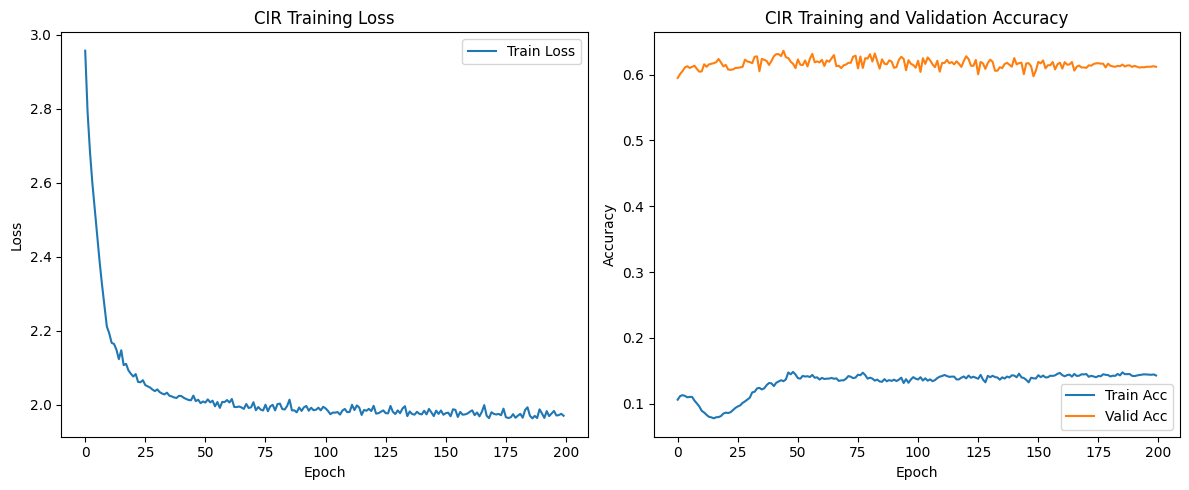

In [11]:

# Train CIR model
train_cir_losses, train_cir_accs, valid_cir_accs = train_cir(
    cir_args, cir_model, train_cir_dataloader, valid_cir_dataloader, 
    cir_optimizer, cir_scheduler, cir_loss_fn, device
)

# Plot CIR training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_cir_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('CIR Training Loss')
plt.subplot(1, 2, 2)
plt.plot(train_cir_accs, label='Train Acc')
plt.plot(valid_cir_accs, label='Valid Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CIR Training and Validation Accuracy')
plt.tight_layout()
plt.show()


In [14]:
best_acc, best_epoch = max(zip(valid_cir_accs, range(1, cir_args.n_epochs + 1)))
print(f"Best CIR Validation Accuracy: {best_acc:.4f} at Epoch {best_epoch}")

Best CIR Validation Accuracy: 0.6362 at Epoch 45


In [13]:
# Section 8: Evaluate CIR on Test Set
#
# This cell evaluates the Category-aware Image Retrieval (CIR) model on the test set
# (fill_in_the_blank/test.json) to report the accuracy (equivalent to Recall@5).
# It initializes the model and loads a checkpoint before evaluation.

# Function to evaluate CIR on test set
def evaluate_cir(model, test_dataloader, device):
    """Evaluate the Category-aware Image Retrieval model on the test set.
    
    Args:
        model (OutfitCLIPTransformer): Trained model.
        test_dataloader (DataLoader): Test DataLoader.
        device (torch.device): Device (CPU/GPU).
    
    Returns:
        float: Test accuracy (Recall@5 equivalent for FITB).
    """
    model.eval()
    all_preds, all_labels = [], []
    pbar = tqdm(test_dataloader, desc='Evaluating CIR on Test')
    with torch.no_grad():
        for data in pbar:
            queries = data['query']
            candidates = data['candidates']
            labels = torch.tensor(data['label'], device=device)
            
            batched_q_emb = get_cls_embedding(model, queries, device, 
                                            use_precomputed_embedding=True).unsqueeze(1)
            batched_c_embs = []
            for cand_group in candidates:
                cand_embs = get_cls_embedding(model, [[cand] for cand in cand_group], device, 
                                             use_precomputed_embedding=True)
                batched_c_embs.append(cand_embs)
            batched_c_embs = torch.stack(batched_c_embs)  # (batch_size, num_candidates, d_model)
            
            dists = torch.norm(batched_q_emb - batched_c_embs, dim=-1)  # (batch_size, num_candidates)
            preds = torch.argmin(dists, dim=-1)
            
            all_preds.append(preds)
            all_labels.append(labels)
            
            score = compute_cir_scores(preds, labels)
            pbar.set_postfix(acc=score['acc'])
    
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    test_scores = compute_cir_scores(all_preds, all_labels)
    
    logger.info(f"CIR Test --> Acc: {test_scores['acc']:.4f}")
    print(f"\nCIR Test Results:")
    print(f"Accuracy (Recall@5): {test_scores['acc']:.4f}")
    
    return test_scores['acc']

# Load test dataset for CIR
test_cir_dataset = PolyvoreFillInTheBlankDataset(
    dataset_dir=cir_args.polyvore_dir,
    dataset_type=cir_args.polyvore_type,
    dataset_split='test',
    metadata=metadata,
    embedding_dict=embedding_dict,
    load_image=False
)

# Create test DataLoader
test_cir_dataloader = DataLoader(
    dataset=test_cir_dataset,
    batch_size=cir_args.batch_sz_per_gpu,
    shuffle=False,
    num_workers=cir_args.n_workers_per_gpu,
    collate_fn=fitb_collate_fn
)

# Initialize model and load checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cir_model = OutfitCLIPTransformer(OutfitTransformerConfig(n_items=len(metadata))).to(device)

# Load checkpoint
checkpoint_path = os.path.join(os.getcwd(), 'checkpoints', 'complementary_clip', 'epoch_45.pth')
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Checkpoint {checkpoint_path} not found. Please verify the path.")
cir_model = load_checkpoint(cir_model, checkpoint_path)

# Evaluate CIR on test set
test_cir_acc = evaluate_cir(cir_model, test_cir_dataloader, device)

/tmp/ipykernel_3527040/3411938486.py:199: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_availab

test CIR FITB dataset: 10000 outfits, Label distribution: Counter({0: 10000})


Evaluating CIR on Test: 100%|██████████| 313/313 [00:11<00:00, 26.60it/s, acc=0.625]


CIR Test Results:
Accuracy (Recall@5): 0.6174


## Prueba FITB


test CIR FITB dataset: 10000 outfits, Label distribution: Counter({0: 10000})

CIR Test Example (Index: 3150)
Outfit (Query):
- ID: 164739268, Category: bags
- ID: 149910696, Category: jewellery
- ID: 123434281, Category: sunglasses
- ID: 129539125, Category: bottoms
- ID: 153574962, Category: outerwear

Candidates:
- Option 0: ID: 161503890, Category: tops
- Option 1: ID: 200946634, Category: tops
- Option 2: ID: 165128333, Category: tops
- Option 3: ID: 125097833, Category: tops

Correct Option: 0 (ID: 161503890)
Predicted Option: 3 (ID: 125097833)
Prediction Correct: No


/tmp/ipykernel_3527040/3411938486.py:199: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_availab

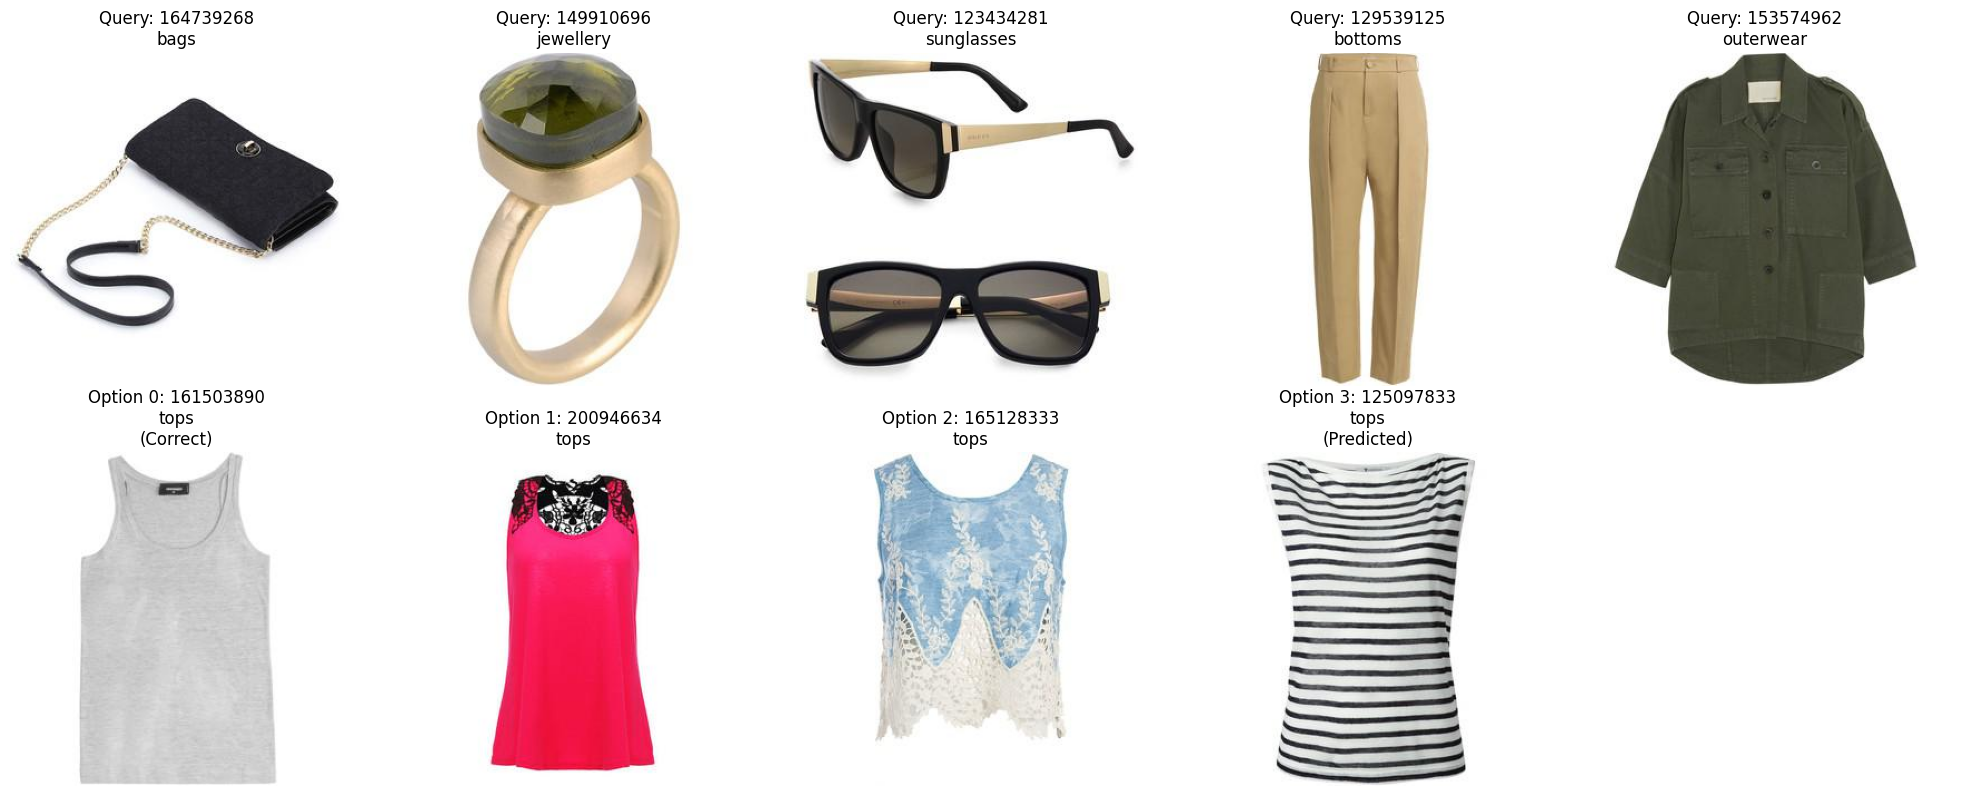

In [59]:
# Section: Visualize CIR Test Example
#
# This cell loads a CIR checkpoint, selects a random example from the test set
# (fill_in_the_blank/test.json), and prints its details with images. It shows the
# outfit (query), the 4 candidate items, the correct option (label), and the
# model's predicted option. Assumes all required functions (load_metadata, 
# load_item, PolyvoreFillInTheBlankDataset, etc.) are defined.

import os
import torch
import random
import matplotlib.pyplot as plt
from PIL import Image

# Define paths
CHECKPOINT_DIR = os.path.join(os.getcwd(), 'checkpoints', 'complementary_clip')
POLYVORE_IMAGE_DATA_PATH = f"{POLYVORE_DIR}/images/{{item_id}}.jpg"

# Configuration
class CIRArgs:
    polyvore_dir = POLYVORE_DIR
    polyvore_type = 'nondisjoint'
    batch_sz_per_gpu = 32
    n_workers_per_gpu = 4
    world_size = 1

cir_args = CIRArgs()

# Load test dataset for CIR
test_cir_dataset = PolyvoreFillInTheBlankDataset(
    dataset_dir=cir_args.polyvore_dir,
    dataset_type=cir_args.polyvore_type,
    dataset_split='test',
    metadata=metadata,
    embedding_dict=embedding_dict,
    load_image=True  # Load images for visualization
)

# Select a random test example
example_idx = random.randint(0, len(test_cir_dataset) - 1)
example = test_cir_dataset[example_idx]

# Initialize model and load checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cir_model = OutfitCLIPTransformer(OutfitTransformerConfig(n_items=len(metadata))).to(device)

# Load checkpoint
checkpoint_path = os.path.join(CHECKPOINT_DIR, 'epoch_40.pth')
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Checkpoint {checkpoint_path} not found. Please verify the path.")
cir_model = load_checkpoint(cir_model, checkpoint_path)

# Get model prediction for the example
cir_model.eval()
with torch.no_grad():
    queries = [example['query']]  # Single query
    candidates = [example['candidates']]  # Single group of 4 candidates
    labels = torch.tensor([example['label']], device=device)
    
    batched_q_emb = get_cls_embedding(cir_model, queries, device, 
                                     use_precomputed_embedding=True).unsqueeze(1)
    batched_c_embs = []
    for cand_group in candidates:
        cand_embs = get_cls_embedding(cir_model, [[cand] for cand in cand_group], device, 
                                     use_precomputed_embedding=True)
        batched_c_embs.append(cand_embs)
    batched_c_embs = torch.stack(batched_c_embs)  # (1, 4, d_model)
    
    dists = torch.norm(batched_q_emb - batched_c_embs, dim=-1)  # (1, 4)
    pred = torch.argmin(dists, dim=-1).item()  # Predicted candidate index

# Print example details
print(f"\nCIR Test Example (Index: {example_idx})")
print("Outfit (Query):")
for item in example['query']:
    print(f"- ID: {item.item_id}, Category: {item.category}")

print("\nCandidates:")
for i, candidate in enumerate(example['candidates']):
    print(f"- Option {i}: ID: {candidate.item_id}, Category: {candidate.category}")

print(f"\nCorrect Option: {example['label']} (ID: {example['candidates'][example['label']].item_id})")
print(f"Predicted Option: {pred} (ID: {example['candidates'][pred].item_id})")
print(f"Prediction Correct: {'Yes' if pred == example['label'] else 'No'}")

# Visualize images
fig, axes = plt.subplots(2, max(len(example['query']), len(example['candidates'])), 
                        figsize=(4 * max(len(example['query']), len(example['candidates'])), 8))

# Plot query images (outfit)
for i, item in enumerate(example['query']):
    image = item.image
    if image is not None:
        axes[0, i].imshow(image)
        axes[0, i].set_title(f"Query: {item.item_id}\n{item.category}")
    else:
        axes[0, i].text(0.5, 0.5, "Image not available", ha='center', va='center')
    axes[0, i].axis('off')

# Plot candidate images
for i, candidate in enumerate(example['candidates']):
    image = candidate.image
    title = f"Option {i}: {candidate.item_id}\n{candidate.category}"
    if i == example['label']:
        title += "\n(Correct)"
    if i == pred:
        title += "\n(Predicted)"
    if image is not None:
        axes[1, i].imshow(image)
        axes[1, i].set_title(title)
    else:
        axes[1, i].text(0.5, 0.5, "Image not available", ha='center', va='center')
    axes[1, i].axis('off')

# Adjust layout for empty subplots
for i in range(len(example['query']), axes.shape[1]):
    axes[0, i].axis('off')
for i in range(len(example['candidates']), axes.shape[1]):
    axes[1, i].axis('off')



plt.tight_layout()
plt.show()




## Prueba CIR real

In [ ]:
# Section: Train CIR with Global Validation
#
# This cell trains the Category-aware Image Retrieval (CIR) model using
# PolyvoreTripletDataset for both training and validation, predicting the
# missing item by finding the closest item in the entire embedding database.
# It initializes from a CP checkpoint (epoch_50.pth) and maintains the same
# training configuration as before.

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import logging

# Define paths
CHECKPOINT_DIR = os.path.join(os.getcwd(), 'checkpoints', 'complementary_clip')
LOGS_DIR = os.path.join(os.getcwd(), 'logs')
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

# Logging setup
logger = logging.getLogger('complementary_clip_global')
logging.basicConfig(
    filename=os.path.join(LOGS_DIR, 'complementary_clip_global.log'),
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# New Functions

def find_closest_item(query_emb, embedding_dict, metadata, target_category, device):
    """Find the closest item in the embedding database for a query embedding.

    Args:
        query_emb (torch.Tensor): Query embedding, shape (d_model,).
        embedding_dict (dict): Dictionary mapping item_id to embedding (1024,).
        metadata (dict): Item metadata with category information.
        target_category (str): Category to restrict the search (e.g., 'shoes').
        device (torch.device): Device for computations.

    Returns:
        tuple: (closest_item_id, is_correct), where is_correct is True if the
               closest item matches the target item_id.
    """
    # Convert embedding_dict to tensor
    item_ids = []
    embeddings = []
    for item_id, emb in embedding_dict.items():
        if metadata[item_id]['semantic_category'] == target_category:
            item_ids.append(item_id)
            embeddings.append(emb)
    
    if not embeddings:
        logger.error(f"No items found for category {target_category}")
        return None, False
    
    embeddings = torch.from_numpy(np.array(embeddings)).to(dtype=torch.float32, device=device)  # (n_items, 1024)
    
    # Project embeddings to model dimension (d_model)
    embeddings = model.fc(embeddings)  # (n_items, d_model)
    
    # Compute distances
    query_emb = query_emb.unsqueeze(0)  # (1, d_model)
    dists = torch.norm(query_emb - embeddings, dim=-1)  # (n_items,)
    
    # Find closest item
    closest_idx = torch.argmin(dists).item()
    closest_item_id = item_ids[closest_idx]
    
    return closest_item_id

def valid_step_cir_global(args, epoch, model, dataloader, embedding_dict, metadata, device):
    """Validation step for CIR, predicting the closest item in the entire database.

    Args:
        args (CIRArgs): Training arguments.
        epoch (int): Current epoch.
        model (OutfitCLIPTransformer): Model to evaluate.
        dataloader (DataLoader): Validation DataLoader (PolyvoreTripletDataset).
        embedding_dict (dict): Dictionary of item embeddings.
        metadata (dict): Item metadata.
        device (torch.device): Device for computations.

    Returns:
        float: Validation accuracy (proportion of correct predictions).
    """
    model.eval()
    correct = 0
    total = 0
    pbar = tqdm(dataloader, desc=f'Valid CIR Epoch {epoch+1}/{args.n_epochs}')
    
    with torch.no_grad():
        for data in pbar:
            queries = data['query']
            answers = [[answer] for answer in data['answer']]  # Wrap answers as single-item outfits
            answer_ids = [answer.item_id for answer in data['answer']]
            answer_categories = [answer.category for answer in data['answer']]
            
            # Compute query embeddings
            batched_q_emb = get_cls_embedding(model, queries, device, 
                                            use_precomputed_embedding=True)  # (batch_size, d_model)
            
            # Find closest item for each query
            for i, (q_emb, ans_id, ans_cat) in enumerate(zip(batched_q_emb, answer_ids, answer_categories)):
                closest_id = find_closest_item(q_emb, embedding_dict, metadata, ans_cat, device)
                if closest_id == ans_id:
                    correct += 1
                total += 1
            
            # Update progress bar
            acc = correct / total if total > 0 else 0.0
            pbar.set_postfix(acc=acc)
    
    accuracy = correct / total if total > 0 else 0.0
    logger.info(f'Epoch {epoch+1}/{args.n_epochs} Valid CIR --> Acc: {accuracy:.4f}')
    print(f'Epoch {epoch+1}/{args.n_epochs} Valid CIR --> Acc: {accuracy:.4f}')
    return accuracy

# Configuration
class CIRArgs:
    model_type = 'clip'
    polyvore_dir = POLYVORE_DIR
    polyvore_type = 'nondisjoint'
    batch_sz_per_gpu = 32
    n_workers_per_gpu = 4
    n_epochs = 200
    lr = 2e-5
    accumulation_steps = 4
    wandb_key = None
    seed = 42
    checkpoint = os.path.join(os.getcwd(), 'checkpoints', 'compatibility_clip', 'epoch_50.pth')
    world_size = 1
    project_name = 'complementary_clip_global'

cir_args = CIRArgs()
logger.info(f"CIR Arguments: {vars(cir_args)}")
print(f"CIR Arguments: {vars(cir_args)}")

# Set seed
seed_everything(cir_args.seed)

# Load datasets
metadata = load_metadata(cir_args.polyvore_dir)
embedding_dict = load_embedding_dict(cir_args.polyvore_dir)

train_cir_dataset = PolyvoreTripletDataset(
    dataset_dir=cir_args.polyvore_dir,
    dataset_type=cir_args.polyvore_type,
    dataset_split='train',
    metadata=metadata,
    embedding_dict=embedding_dict,
    load_image=False
)

valid_cir_dataset = PolyvoreTripletDataset(
    dataset_dir=cir_args.polyvore_dir,
    dataset_type=cir_args.polyvore_type,
    dataset_split='valid',
    metadata=metadata,
    embedding_dict=embedding_dict,
    load_image=False
)

# Create DataLoaders
train_cir_dataloader = DataLoader(
    dataset=train_cir_dataset,
    batch_size=cir_args.batch_sz_per_gpu,
    shuffle=True,
    num_workers=cir_args.n_workers_per_gpu,
    collate_fn=triplet_collate_fn
)

valid_cir_dataloader = DataLoader(
    dataset=valid_cir_dataset,
    batch_size=cir_args.batch_sz_per_gpu,
    shuffle=False,
    num_workers=cir_args.n_workers_per_gpu,
    collate_fn=triplet_collate_fn
)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OutfitCLIPTransformer(OutfitCLIPTransformerConfig(n_items=len(metadata))).to(device)

# Load CP checkpoint from epoch 50
if not os.path.exists(cir_args.checkpoint):
    raise FileNotFoundError(f"Checkpoint {cir_args.checkpoint} not found. Please verify the path.")
model = load_checkpoint(model, cir_args.checkpoint)
logger.info(f"Loaded CP checkpoint from {cir_args.checkpoint}")

# Optimizer, scheduler, loss
optimizer = optim.AdamW(model.parameters(), lr=cir_args.lr)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=cir_args.lr,
    epochs=cir_args.n_epochs,
    steps_per_epoch=int(len(train_cir_dataloader) / cir_args.accumulation_steps),
    pct_start=0.3,
    anneal_strategy='cos',
    div_factor=25,
    final_div_factor=1e4
)
loss_fn = InBatchTripletMarginLoss(margin=2.0, reduction='mean')

# Training loop
train_losses, train_accs, valid_accs = [], [], []
for epoch in range(cir_args.n_epochs):
    # Training
    model.train()
    train_loss, all_preds, all_labels = 0.0, [], []
    pbar = tqdm(train_cir_dataloader, desc=f'Train CIR Epoch {epoch+1}/{cir_args.n_epochs}')
    for i, data in enumerate(pbar):
        queries = data['query']
        answers = [[answer] for answer in data['answer']]
        
        batched_q_emb = get_cls_embedding(model, queries, device, use_precomputed_embedding=True)
        batched_a_emb = get_cls_embedding(model, answers, device, use_precomputed_embedding=True)
        
        loss = loss_fn(batched_q_emb, batched_a_emb) / cir_args.accumulation_steps
        loss.backward()
        
        if (i + 1) % cir_args.accumulation_steps == 0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
        
        train_loss += loss.item() * cir_args.accumulation_steps
        
        dists = torch.cdist(batched_q_emb, batched_a_emb, p=2)
        preds = torch.argmin(dists, dim=1)
        labels = torch.arange(len(preds), device=device)
        
        all_preds.append(preds.detach())
        all_labels.append(labels.detach())
        
        score = compute_cir_scores(preds, labels)
        pbar.set_postfix(loss=loss.item() * cir_args.accumulation_steps, acc=score['acc'])
    
    train_loss /= len(train_cir_dataloader)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    train_scores = compute_cir_scores(all_preds, all_labels)
    train_losses.append(train_loss)
    train_accs.append(train_scores['acc'])
    logger.info(f'Epoch {epoch+1}/{cir_args.n_epochs} Train CIR --> Loss: {train_loss:.4f}, '
               f'Acc: {train_scores["acc"]:.4f}')
    print(f'Epoch {epoch+1}/{cir_args.n_epochs} Train CIR --> Loss: {train_loss:.4f}, '
          f'Acc: {train_scores["acc"]:.4f}')
    
    # Validation
    valid_acc = valid_step_cir_global(cir_args, epoch, model, valid_cir_dataloader, 
                                     embedding_dict, metadata, device)
    valid_accs.append(valid_acc)
    
    # Save checkpoint
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'epoch_{epoch+1}.pth')
    torch.save({'config': model.cfg.__dict__, 'model': model.state_dict()}, checkpoint_path)
    logger.info(f'Checkpoint saved at {checkpoint_path}')
    print(f'Checkpoint saved at {checkpoint_path}')

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('CIR Training Loss')
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(valid_accs, label='Valid Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CIR Training and Validation Accuracy')
plt.tight_layout()
plt.show()

CIR Arguments: {}
Loaded 251008 metadata entries
Loaded 251008 embeddings into dictionary


/tmp/ipykernel_3034047/3411938486.py:199: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_availab

train CIR triplet dataset: 53306 sets
valid CIR triplet dataset: 5000 sets


Train CIR Epoch 1/200: 100%|██████████| 1666/1666 [00:17<00:00, 93.09it/s, acc=0.231, loss=2.86]  


Epoch 1/200 Train CIR --> Loss: 2.9636, Acc: 0.1077


Valid CIR Epoch 1/200: 100%|██████████| 157/157 [05:28<00:00,  2.09s/it, acc=0]


Epoch 1/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_1.pth


Train CIR Epoch 2/200: 100%|██████████| 1666/1666 [00:17<00:00, 93.89it/s, acc=0.115, loss=2.73]  


Epoch 2/200 Train CIR --> Loss: 2.7909, Acc: 0.1120


Valid CIR Epoch 2/200: 100%|██████████| 157/157 [05:19<00:00,  2.03s/it, acc=0]


Epoch 2/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_2.pth


Train CIR Epoch 3/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.67it/s, acc=0.115, loss=2.59] 


Epoch 3/200 Train CIR --> Loss: 2.6871, Acc: 0.1122


Valid CIR Epoch 3/200: 100%|██████████| 157/157 [05:15<00:00,  2.01s/it, acc=0]


Epoch 3/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_3.pth


Train CIR Epoch 4/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.59it/s, acc=0.0385, loss=2.65]


Epoch 4/200 Train CIR --> Loss: 2.5977, Acc: 0.1148


Valid CIR Epoch 4/200: 100%|██████████| 157/157 [05:16<00:00,  2.02s/it, acc=0]


Epoch 4/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_4.pth


Train CIR Epoch 5/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.82it/s, acc=0.115, loss=2.49] 


Epoch 5/200 Train CIR --> Loss: 2.5149, Acc: 0.1129


Valid CIR Epoch 5/200: 100%|██████████| 157/157 [05:19<00:00,  2.03s/it, acc=0]


Epoch 5/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_5.pth


Train CIR Epoch 6/200: 100%|██████████| 1666/1666 [00:16<00:00, 101.83it/s, acc=0.154, loss=2.3]  


Epoch 6/200 Train CIR --> Loss: 2.4462, Acc: 0.1124


Valid CIR Epoch 6/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 6/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_6.pth


Train CIR Epoch 7/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.22it/s, acc=0.231, loss=2.38] 


Epoch 7/200 Train CIR --> Loss: 2.3805, Acc: 0.1091


Valid CIR Epoch 7/200: 100%|██████████| 157/157 [05:19<00:00,  2.04s/it, acc=0.0002]  


Epoch 7/200 Valid CIR --> Acc: 0.0002
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_7.pth


Train CIR Epoch 8/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.53it/s, acc=0.0769, loss=2.45]


Epoch 8/200 Train CIR --> Loss: 2.3239, Acc: 0.1047


Valid CIR Epoch 8/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 8/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_8.pth


Train CIR Epoch 9/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.46it/s, acc=0.115, loss=2.16] 


Epoch 9/200 Train CIR --> Loss: 2.2669, Acc: 0.1013


Valid CIR Epoch 9/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 9/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_9.pth


Train CIR Epoch 10/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.22it/s, acc=0.154, loss=2.11] 


Epoch 10/200 Train CIR --> Loss: 2.2194, Acc: 0.0972


Valid CIR Epoch 10/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 10/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_10.pth


Train CIR Epoch 11/200: 100%|██████████| 1666/1666 [00:16<00:00, 100.55it/s, acc=0.115, loss=2.14] 


Epoch 11/200 Train CIR --> Loss: 2.1931, Acc: 0.0922


Valid CIR Epoch 11/200: 100%|██████████| 157/157 [05:20<00:00,  2.04s/it, acc=0]


Epoch 11/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_11.pth


Train CIR Epoch 12/200: 100%|██████████| 1666/1666 [00:15<00:00, 105.13it/s, acc=0.115, loss=2.09] 


Epoch 12/200 Train CIR --> Loss: 2.1572, Acc: 0.0878


Valid CIR Epoch 12/200: 100%|██████████| 157/157 [05:19<00:00,  2.03s/it, acc=0]


Epoch 12/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_12.pth


Train CIR Epoch 13/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.63it/s, acc=0.0385, loss=2.23]


Epoch 13/200 Train CIR --> Loss: 2.1440, Acc: 0.0844


Valid CIR Epoch 13/200: 100%|██████████| 157/157 [05:21<00:00,  2.05s/it, acc=0]


Epoch 13/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_13.pth


Train CIR Epoch 14/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.38it/s, acc=0.0385, loss=2.12]


Epoch 14/200 Train CIR --> Loss: 2.1442, Acc: 0.0804


Valid CIR Epoch 14/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 14/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_14.pth


Train CIR Epoch 15/200: 100%|██████████| 1666/1666 [00:15<00:00, 105.83it/s, acc=0.115, loss=2.05] 


Epoch 15/200 Train CIR --> Loss: 2.1158, Acc: 0.0796


Valid CIR Epoch 15/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 15/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_15.pth


Train CIR Epoch 16/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.69it/s, acc=0.154, loss=2.04] 


Epoch 16/200 Train CIR --> Loss: 2.1400, Acc: 0.0798


Valid CIR Epoch 16/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 16/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_16.pth


Train CIR Epoch 17/200: 100%|██████████| 1666/1666 [00:15<00:00, 105.19it/s, acc=0.0385, loss=2.06]


Epoch 17/200 Train CIR --> Loss: 2.1062, Acc: 0.0790


Valid CIR Epoch 17/200: 100%|██████████| 157/157 [05:16<00:00,  2.01s/it, acc=0]


Epoch 17/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_17.pth


Train CIR Epoch 18/200: 100%|██████████| 1666/1666 [00:15<00:00, 106.18it/s, acc=0.154, loss=2.15] 


Epoch 18/200 Train CIR --> Loss: 2.1073, Acc: 0.0806


Valid CIR Epoch 18/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 18/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_18.pth


Train CIR Epoch 19/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.93it/s, acc=0.0385, loss=2.05]


Epoch 19/200 Train CIR --> Loss: 2.1308, Acc: 0.0831


Valid CIR Epoch 19/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 19/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_19.pth


Train CIR Epoch 20/200: 100%|██████████| 1666/1666 [00:15<00:00, 105.02it/s, acc=0.0385, loss=2.11]


Epoch 20/200 Train CIR --> Loss: 2.0816, Acc: 0.0815


Valid CIR Epoch 20/200: 100%|██████████| 157/157 [05:16<00:00,  2.02s/it, acc=0]


Epoch 20/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_20.pth


Train CIR Epoch 21/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.96it/s, acc=0.154, loss=2.04] 


Epoch 21/200 Train CIR --> Loss: 2.0785, Acc: 0.0840


Valid CIR Epoch 21/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 21/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_21.pth


Train CIR Epoch 22/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.25it/s, acc=0.115, loss=2.03] 


Epoch 22/200 Train CIR --> Loss: 2.0773, Acc: 0.0842


Valid CIR Epoch 22/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 22/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_22.pth


Train CIR Epoch 23/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.94it/s, acc=0.192, loss=2.02] 


Epoch 23/200 Train CIR --> Loss: 2.0698, Acc: 0.0862


Valid CIR Epoch 23/200: 100%|██████████| 157/157 [05:19<00:00,  2.03s/it, acc=0]


Epoch 23/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_23.pth


Train CIR Epoch 24/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.09it/s, acc=0.0769, loss=2.05]


Epoch 24/200 Train CIR --> Loss: 2.0635, Acc: 0.0884


Valid CIR Epoch 24/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 24/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_24.pth


Train CIR Epoch 25/200: 100%|██████████| 1666/1666 [00:15<00:00, 105.08it/s, acc=0.154, loss=2.1]  


Epoch 25/200 Train CIR --> Loss: 2.0555, Acc: 0.0935


Valid CIR Epoch 25/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 25/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_25.pth


Train CIR Epoch 26/200: 100%|██████████| 1666/1666 [00:16<00:00, 101.64it/s, acc=0.0769, loss=2.04]


Epoch 26/200 Train CIR --> Loss: 2.0574, Acc: 0.0987


Valid CIR Epoch 26/200: 100%|██████████| 157/157 [05:17<00:00,  2.03s/it, acc=0]


Epoch 26/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_26.pth


Train CIR Epoch 27/200: 100%|██████████| 1666/1666 [00:15<00:00, 105.25it/s, acc=0.115, loss=2.05] 


Epoch 27/200 Train CIR --> Loss: 2.0519, Acc: 0.0980


Valid CIR Epoch 27/200: 100%|██████████| 157/157 [05:19<00:00,  2.03s/it, acc=0]


Epoch 27/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_27.pth


Train CIR Epoch 28/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.95it/s, acc=0.0769, loss=2.03]


Epoch 28/200 Train CIR --> Loss: 2.0531, Acc: 0.1012


Valid CIR Epoch 28/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 28/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_28.pth


Train CIR Epoch 29/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.18it/s, acc=0.115, loss=2.03] 


Epoch 29/200 Train CIR --> Loss: 2.0440, Acc: 0.1048


Valid CIR Epoch 29/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 29/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_29.pth


Train CIR Epoch 30/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.67it/s, acc=0.154, loss=2.03] 


Epoch 30/200 Train CIR --> Loss: 2.0365, Acc: 0.1081


Valid CIR Epoch 30/200: 100%|██████████| 157/157 [05:16<00:00,  2.02s/it, acc=0]


Epoch 30/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_30.pth


Train CIR Epoch 31/200: 100%|██████████| 1666/1666 [00:15<00:00, 105.02it/s, acc=0.0769, loss=2.07]


Epoch 31/200 Train CIR --> Loss: 2.0346, Acc: 0.1120


Valid CIR Epoch 31/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 31/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_31.pth


Train CIR Epoch 32/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.04it/s, acc=0.192, loss=2.02] 


Epoch 32/200 Train CIR --> Loss: 2.0326, Acc: 0.1142


Valid CIR Epoch 32/200: 100%|██████████| 157/157 [05:16<00:00,  2.02s/it, acc=0]


Epoch 32/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_32.pth


Train CIR Epoch 33/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.32it/s, acc=0.0385, loss=2.02]


Epoch 33/200 Train CIR --> Loss: 2.0307, Acc: 0.1193


Valid CIR Epoch 33/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 33/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_33.pth


Train CIR Epoch 34/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.71it/s, acc=0.154, loss=2.02] 


Epoch 34/200 Train CIR --> Loss: 2.0288, Acc: 0.1238


Valid CIR Epoch 34/200: 100%|██████████| 157/157 [05:19<00:00,  2.04s/it, acc=0]


Epoch 34/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_34.pth


Train CIR Epoch 35/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.41it/s, acc=0.115, loss=2.02] 


Epoch 35/200 Train CIR --> Loss: 2.0329, Acc: 0.1260


Valid CIR Epoch 35/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 35/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_35.pth


Train CIR Epoch 36/200: 100%|██████████| 1666/1666 [00:15<00:00, 105.57it/s, acc=0.0385, loss=2.02]


Epoch 36/200 Train CIR --> Loss: 2.0318, Acc: 0.1238


Valid CIR Epoch 36/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 36/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_36.pth


Train CIR Epoch 37/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.55it/s, acc=0.231, loss=1.98] 


Epoch 37/200 Train CIR --> Loss: 2.0237, Acc: 0.1257


Valid CIR Epoch 37/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0.0002]  


Epoch 37/200 Valid CIR --> Acc: 0.0002
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_37.pth


Train CIR Epoch 38/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.66it/s, acc=0.154, loss=2.03] 


Epoch 38/200 Train CIR --> Loss: 2.0254, Acc: 0.1308


Valid CIR Epoch 38/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 38/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_38.pth


Train CIR Epoch 39/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.86it/s, acc=0.192, loss=2.01] 


Epoch 39/200 Train CIR --> Loss: 2.0195, Acc: 0.1282


Valid CIR Epoch 39/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 39/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_39.pth


Train CIR Epoch 40/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.15it/s, acc=0.154, loss=2.01] 


Epoch 40/200 Train CIR --> Loss: 2.0217, Acc: 0.1279


Valid CIR Epoch 40/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 40/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_40.pth


Train CIR Epoch 41/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.98it/s, acc=0.115, loss=2.01] 


Epoch 41/200 Train CIR --> Loss: 2.0173, Acc: 0.1292


Valid CIR Epoch 41/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 41/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_41.pth


Train CIR Epoch 42/200: 100%|██████████| 1666/1666 [00:15<00:00, 105.64it/s, acc=0.154, loss=2.02] 


Epoch 42/200 Train CIR --> Loss: 2.0185, Acc: 0.1351


Valid CIR Epoch 42/200: 100%|██████████| 157/157 [05:16<00:00,  2.01s/it, acc=0]


Epoch 42/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_42.pth


Train CIR Epoch 43/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.91it/s, acc=0.154, loss=2.02] 


Epoch 43/200 Train CIR --> Loss: 2.0210, Acc: 0.1329


Valid CIR Epoch 43/200: 100%|██████████| 157/157 [05:19<00:00,  2.03s/it, acc=0]


Epoch 43/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_43.pth


Train CIR Epoch 44/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.47it/s, acc=0.192, loss=1.99] 


Epoch 44/200 Train CIR --> Loss: 2.0131, Acc: 0.1356


Valid CIR Epoch 44/200: 100%|██████████| 157/157 [05:19<00:00,  2.04s/it, acc=0]


Epoch 44/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_44.pth


Train CIR Epoch 45/200: 100%|██████████| 1666/1666 [00:16<00:00, 101.66it/s, acc=0.115, loss=2.03] 


Epoch 45/200 Train CIR --> Loss: 2.0172, Acc: 0.1371


Valid CIR Epoch 45/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0.0002]  


Epoch 45/200 Valid CIR --> Acc: 0.0002
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_45.pth


Train CIR Epoch 46/200: 100%|██████████| 1666/1666 [00:15<00:00, 105.39it/s, acc=0.154, loss=2.04] 


Epoch 46/200 Train CIR --> Loss: 2.0160, Acc: 0.1355


Valid CIR Epoch 46/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0.0002]  


Epoch 46/200 Valid CIR --> Acc: 0.0002
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_46.pth


Train CIR Epoch 47/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.65it/s, acc=0.231, loss=2.01] 


Epoch 47/200 Train CIR --> Loss: 2.0176, Acc: 0.1338


Valid CIR Epoch 47/200: 100%|██████████| 157/157 [05:19<00:00,  2.03s/it, acc=0.0002]  


Epoch 47/200 Valid CIR --> Acc: 0.0002
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_47.pth


Train CIR Epoch 48/200: 100%|██████████| 1666/1666 [00:16<00:00, 101.27it/s, acc=0.154, loss=2.01] 


Epoch 48/200 Train CIR --> Loss: 2.0156, Acc: 0.1404


Valid CIR Epoch 48/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0.0002]  


Epoch 48/200 Valid CIR --> Acc: 0.0002
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_48.pth


Train CIR Epoch 49/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.75it/s, acc=0.231, loss=2.03] 


Epoch 49/200 Train CIR --> Loss: 2.0123, Acc: 0.1419


Valid CIR Epoch 49/200: 100%|██████████| 157/157 [05:20<00:00,  2.04s/it, acc=0.0002]  


Epoch 49/200 Valid CIR --> Acc: 0.0002
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_49.pth


Train CIR Epoch 50/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.71it/s, acc=0.0769, loss=2.01]


Epoch 50/200 Train CIR --> Loss: 2.0175, Acc: 0.1384


Valid CIR Epoch 50/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 50/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_50.pth


Train CIR Epoch 51/200: 100%|██████████| 1666/1666 [00:16<00:00, 101.63it/s, acc=0.192, loss=2.02] 


Epoch 51/200 Train CIR --> Loss: 2.0192, Acc: 0.1407


Valid CIR Epoch 51/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 51/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_51.pth


Train CIR Epoch 52/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.34it/s, acc=0.154, loss=1.95] 


Epoch 52/200 Train CIR --> Loss: 2.0102, Acc: 0.1414


Valid CIR Epoch 52/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 52/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_52.pth


Train CIR Epoch 53/200: 100%|██████████| 1666/1666 [00:16<00:00, 104.02it/s, acc=0.115, loss=2.01] 


Epoch 53/200 Train CIR --> Loss: 2.0130, Acc: 0.1523


Valid CIR Epoch 53/200: 100%|██████████| 157/157 [05:16<00:00,  2.01s/it, acc=0]


Epoch 53/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_53.pth


Train CIR Epoch 54/200: 100%|██████████| 1666/1666 [00:16<00:00, 101.43it/s, acc=0.0769, loss=2.01]


Epoch 54/200 Train CIR --> Loss: 2.0108, Acc: 0.1459


Valid CIR Epoch 54/200: 100%|██████████| 157/157 [05:14<00:00,  2.01s/it, acc=0]


Epoch 54/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_54.pth


Train CIR Epoch 55/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.42it/s, acc=0.231, loss=2.01] 


Epoch 55/200 Train CIR --> Loss: 2.0115, Acc: 0.1487


Valid CIR Epoch 55/200: 100%|██████████| 157/157 [05:16<00:00,  2.01s/it, acc=0]


Epoch 55/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_55.pth


Train CIR Epoch 56/200: 100%|██████████| 1666/1666 [00:16<00:00, 101.53it/s, acc=0.115, loss=2.03] 


Epoch 56/200 Train CIR --> Loss: 2.0054, Acc: 0.1452


Valid CIR Epoch 56/200: 100%|██████████| 157/157 [05:19<00:00,  2.03s/it, acc=0]


Epoch 56/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_56.pth


Train CIR Epoch 57/200: 100%|██████████| 1666/1666 [00:15<00:00, 105.60it/s, acc=0.0769, loss=2.01]


Epoch 57/200 Train CIR --> Loss: 2.0023, Acc: 0.1464


Valid CIR Epoch 57/200: 100%|██████████| 157/157 [05:15<00:00,  2.01s/it, acc=0.0002]  


Epoch 57/200 Valid CIR --> Acc: 0.0002
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_57.pth


Train CIR Epoch 58/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.15it/s, acc=0.269, loss=1.93] 


Epoch 58/200 Train CIR --> Loss: 2.0148, Acc: 0.1467


Valid CIR Epoch 58/200: 100%|██████████| 157/157 [05:17<00:00,  2.03s/it, acc=0]


Epoch 58/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_58.pth


Train CIR Epoch 59/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.44it/s, acc=0.0769, loss=2.01]


Epoch 59/200 Train CIR --> Loss: 2.0064, Acc: 0.1434


Valid CIR Epoch 59/200: 100%|██████████| 157/157 [05:19<00:00,  2.04s/it, acc=0]


Epoch 59/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_59.pth


Train CIR Epoch 60/200: 100%|██████████| 1666/1666 [00:15<00:00, 105.39it/s, acc=0.0385, loss=2.01]


Epoch 60/200 Train CIR --> Loss: 1.9910, Acc: 0.1408


Valid CIR Epoch 60/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 60/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_60.pth


Train CIR Epoch 61/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.72it/s, acc=0.115, loss=2.01] 


Epoch 61/200 Train CIR --> Loss: 2.0083, Acc: 0.1437


Valid CIR Epoch 61/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 61/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_61.pth


Train CIR Epoch 62/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.05it/s, acc=0.154, loss=2.02] 


Epoch 62/200 Train CIR --> Loss: 1.9904, Acc: 0.1383


Valid CIR Epoch 62/200: 100%|██████████| 157/157 [05:20<00:00,  2.04s/it, acc=0]


Epoch 62/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_62.pth


Train CIR Epoch 63/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.80it/s, acc=0.231, loss=1.94] 


Epoch 63/200 Train CIR --> Loss: 1.9935, Acc: 0.1395


Valid CIR Epoch 63/200: 100%|██████████| 157/157 [05:19<00:00,  2.04s/it, acc=0]


Epoch 63/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_63.pth


Train CIR Epoch 64/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.64it/s, acc=0.154, loss=1.94] 


Epoch 64/200 Train CIR --> Loss: 1.9949, Acc: 0.1478


Valid CIR Epoch 64/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 64/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_64.pth


Train CIR Epoch 65/200: 100%|██████████| 1666/1666 [00:16<00:00, 104.06it/s, acc=0.154, loss=1.93] 


Epoch 65/200 Train CIR --> Loss: 2.0098, Acc: 0.1389


Valid CIR Epoch 65/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 65/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_65.pth


Train CIR Epoch 66/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.60it/s, acc=0.115, loss=1.93] 


Epoch 66/200 Train CIR --> Loss: 1.9941, Acc: 0.1333


Valid CIR Epoch 66/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 66/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_66.pth


Train CIR Epoch 67/200: 100%|██████████| 1666/1666 [00:16<00:00, 101.98it/s, acc=0.154, loss=2]    


Epoch 67/200 Train CIR --> Loss: 1.9842, Acc: 0.1461


Valid CIR Epoch 67/200: 100%|██████████| 157/157 [05:15<00:00,  2.01s/it, acc=0]


Epoch 67/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_67.pth


Train CIR Epoch 68/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.40it/s, acc=0.231, loss=1.95] 


Epoch 68/200 Train CIR --> Loss: 2.0067, Acc: 0.1409


Valid CIR Epoch 68/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 68/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_68.pth


Train CIR Epoch 69/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.94it/s, acc=0.0769, loss=2.01]


Epoch 69/200 Train CIR --> Loss: 1.9913, Acc: 0.1415


Valid CIR Epoch 69/200: 100%|██████████| 157/157 [05:16<00:00,  2.02s/it, acc=0]


Epoch 69/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_69.pth


Train CIR Epoch 70/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.95it/s, acc=0.192, loss=1.99] 


Epoch 70/200 Train CIR --> Loss: 1.9992, Acc: 0.1430


Valid CIR Epoch 70/200: 100%|██████████| 157/157 [05:19<00:00,  2.04s/it, acc=0]


Epoch 70/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_70.pth


Train CIR Epoch 71/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.24it/s, acc=0.115, loss=1.94] 


Epoch 71/200 Train CIR --> Loss: 1.9912, Acc: 0.1425


Valid CIR Epoch 71/200: 100%|██████████| 157/157 [05:21<00:00,  2.05s/it, acc=0.0002]  


Epoch 71/200 Valid CIR --> Acc: 0.0002
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_71.pth


Train CIR Epoch 72/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.33it/s, acc=0.192, loss=2]    


Epoch 72/200 Train CIR --> Loss: 1.9914, Acc: 0.1432


Valid CIR Epoch 72/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 72/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_72.pth


Train CIR Epoch 73/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.67it/s, acc=0.154, loss=2]    


Epoch 73/200 Train CIR --> Loss: 2.0015, Acc: 0.1451


Valid CIR Epoch 73/200: 100%|██████████| 157/157 [05:16<00:00,  2.02s/it, acc=0.0002]  


Epoch 73/200 Valid CIR --> Acc: 0.0002
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_73.pth


Train CIR Epoch 74/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.76it/s, acc=0.192, loss=2]    


Epoch 74/200 Train CIR --> Loss: 1.9976, Acc: 0.1389


Valid CIR Epoch 74/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 74/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_74.pth


Train CIR Epoch 75/200: 100%|██████████| 1666/1666 [00:16<00:00, 104.10it/s, acc=0.231, loss=1.87] 


Epoch 75/200 Train CIR --> Loss: 1.9989, Acc: 0.1396


Valid CIR Epoch 75/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 75/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_75.pth


Train CIR Epoch 76/200: 100%|██████████| 1666/1666 [00:16<00:00, 101.86it/s, acc=0.115, loss=2.02] 


Epoch 76/200 Train CIR --> Loss: 1.9980, Acc: 0.1436


Valid CIR Epoch 76/200: 100%|██████████| 157/157 [05:20<00:00,  2.04s/it, acc=0]


Epoch 76/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_76.pth


Train CIR Epoch 77/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.28it/s, acc=0.192, loss=2.03] 


Epoch 77/200 Train CIR --> Loss: 1.9859, Acc: 0.1374


Valid CIR Epoch 77/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0.0002]  


Epoch 77/200 Valid CIR --> Acc: 0.0002
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_77.pth


Train CIR Epoch 78/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.84it/s, acc=0.192, loss=1.95] 


Epoch 78/200 Train CIR --> Loss: 1.9871, Acc: 0.1419


Valid CIR Epoch 78/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 78/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_78.pth


Train CIR Epoch 79/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.67it/s, acc=0.192, loss=1.99] 


Epoch 79/200 Train CIR --> Loss: 1.9920, Acc: 0.1442


Valid CIR Epoch 79/200: 100%|██████████| 157/157 [05:19<00:00,  2.04s/it, acc=0]


Epoch 79/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_79.pth


Train CIR Epoch 80/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.70it/s, acc=0.0769, loss=2.01]


Epoch 80/200 Train CIR --> Loss: 1.9942, Acc: 0.1399


Valid CIR Epoch 80/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 80/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_80.pth


Train CIR Epoch 81/200: 100%|██████████| 1666/1666 [00:16<00:00, 101.53it/s, acc=0.308, loss=1.99] 


Epoch 81/200 Train CIR --> Loss: 1.9796, Acc: 0.1423


Valid CIR Epoch 81/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 81/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_81.pth


Train CIR Epoch 82/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.50it/s, acc=0.154, loss=2.01] 


Epoch 82/200 Train CIR --> Loss: 1.9923, Acc: 0.1382


Valid CIR Epoch 82/200: 100%|██████████| 157/157 [05:20<00:00,  2.04s/it, acc=0.0002]  


Epoch 82/200 Valid CIR --> Acc: 0.0002
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_82.pth


Train CIR Epoch 83/200: 100%|██████████| 1666/1666 [00:15<00:00, 105.38it/s, acc=0.192, loss=2]    


Epoch 83/200 Train CIR --> Loss: 1.9950, Acc: 0.1392


Valid CIR Epoch 83/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0.0002]  


Epoch 83/200 Valid CIR --> Acc: 0.0002
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_83.pth


Train CIR Epoch 84/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.59it/s, acc=0.0769, loss=2]   


Epoch 84/200 Train CIR --> Loss: 2.0031, Acc: 0.1373


Valid CIR Epoch 84/200: 100%|██████████| 157/157 [05:16<00:00,  2.02s/it, acc=0]


Epoch 84/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_84.pth


Train CIR Epoch 85/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.91it/s, acc=0.154, loss=2]    


Epoch 85/200 Train CIR --> Loss: 1.9926, Acc: 0.1442


Valid CIR Epoch 85/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 85/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_85.pth


Train CIR Epoch 86/200: 100%|██████████| 1666/1666 [00:16<00:00, 100.68it/s, acc=0.192, loss=1.96] 


Epoch 86/200 Train CIR --> Loss: 1.9919, Acc: 0.1439


Valid CIR Epoch 86/200: 100%|██████████| 157/157 [05:21<00:00,  2.05s/it, acc=0]


Epoch 86/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_86.pth


Train CIR Epoch 87/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.58it/s, acc=0.0385, loss=2.01]


Epoch 87/200 Train CIR --> Loss: 1.9898, Acc: 0.1384


Valid CIR Epoch 87/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 87/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_87.pth


Train CIR Epoch 88/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.63it/s, acc=0.115, loss=2.11] 


Epoch 88/200 Train CIR --> Loss: 1.9875, Acc: 0.1418


Valid CIR Epoch 88/200: 100%|██████████| 157/157 [05:19<00:00,  2.04s/it, acc=0]


Epoch 88/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_88.pth


Train CIR Epoch 89/200: 100%|██████████| 1666/1666 [00:16<00:00, 100.72it/s, acc=0.192, loss=1.96] 


Epoch 89/200 Train CIR --> Loss: 2.0015, Acc: 0.1401


Valid CIR Epoch 89/200: 100%|██████████| 157/157 [05:15<00:00,  2.01s/it, acc=0]


Epoch 89/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_89.pth


Train CIR Epoch 90/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.55it/s, acc=0.269, loss=2]    


Epoch 90/200 Train CIR --> Loss: 1.9903, Acc: 0.1433


Valid CIR Epoch 90/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 90/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_90.pth


Train CIR Epoch 91/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.99it/s, acc=0.192, loss=1.95] 


Epoch 91/200 Train CIR --> Loss: 1.9762, Acc: 0.1432


Valid CIR Epoch 91/200: 100%|██████████| 157/157 [05:20<00:00,  2.04s/it, acc=0]


Epoch 91/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_91.pth


Train CIR Epoch 92/200: 100%|██████████| 1666/1666 [00:16<00:00, 101.37it/s, acc=0.192, loss=1.98] 


Epoch 92/200 Train CIR --> Loss: 1.9939, Acc: 0.1418


Valid CIR Epoch 92/200: 100%|██████████| 157/157 [05:19<00:00,  2.03s/it, acc=0]


Epoch 92/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_92.pth


Train CIR Epoch 93/200: 100%|██████████| 1666/1666 [00:16<00:00, 104.05it/s, acc=0.115, loss=1.86] 


Epoch 93/200 Train CIR --> Loss: 2.0140, Acc: 0.1458


Valid CIR Epoch 93/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 93/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_93.pth


Train CIR Epoch 94/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.58it/s, acc=0.308, loss=1.85] 


Epoch 94/200 Train CIR --> Loss: 1.9892, Acc: 0.1400


Valid CIR Epoch 94/200: 100%|██████████| 157/157 [05:19<00:00,  2.03s/it, acc=0]


Epoch 94/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_94.pth


Train CIR Epoch 95/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.17it/s, acc=0.115, loss=1.85] 


Epoch 95/200 Train CIR --> Loss: 2.0126, Acc: 0.1424


Valid CIR Epoch 95/200: 100%|██████████| 157/157 [05:20<00:00,  2.04s/it, acc=0.0002]  


Epoch 95/200 Valid CIR --> Acc: 0.0002
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_95.pth


Train CIR Epoch 96/200: 100%|██████████| 1666/1666 [00:16<00:00, 101.16it/s, acc=0.346, loss=1.93] 


Epoch 96/200 Train CIR --> Loss: 1.9952, Acc: 0.1355


Valid CIR Epoch 96/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0.0002]  


Epoch 96/200 Valid CIR --> Acc: 0.0002
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_96.pth


Train CIR Epoch 97/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.43it/s, acc=0.115, loss=1.93] 


Epoch 97/200 Train CIR --> Loss: 1.9868, Acc: 0.1421


Valid CIR Epoch 97/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 97/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_97.pth


Train CIR Epoch 98/200: 100%|██████████| 1666/1666 [00:16<00:00, 101.69it/s, acc=0.0385, loss=2.11]


Epoch 98/200 Train CIR --> Loss: 1.9784, Acc: 0.1448


Valid CIR Epoch 98/200: 100%|██████████| 157/157 [05:20<00:00,  2.04s/it, acc=0.0002]  


Epoch 98/200 Valid CIR --> Acc: 0.0002
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_98.pth


Train CIR Epoch 99/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.83it/s, acc=0.154, loss=2.02] 


Epoch 99/200 Train CIR --> Loss: 1.9846, Acc: 0.1443


Valid CIR Epoch 99/200: 100%|██████████| 157/157 [05:20<00:00,  2.04s/it, acc=0]


Epoch 99/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_99.pth


Train CIR Epoch 100/200: 100%|██████████| 1666/1666 [00:16<00:00, 101.89it/s, acc=0.0769, loss=2.08]


Epoch 100/200 Train CIR --> Loss: 1.9893, Acc: 0.1434


Valid CIR Epoch 100/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 100/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_100.pth


Train CIR Epoch 101/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.94it/s, acc=0.154, loss=2.08] 


Epoch 101/200 Train CIR --> Loss: 1.9905, Acc: 0.1428


Valid CIR Epoch 101/200: 100%|██████████| 157/157 [05:20<00:00,  2.04s/it, acc=0]


Epoch 101/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_101.pth


Train CIR Epoch 102/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.79it/s, acc=0.154, loss=2]    


Epoch 102/200 Train CIR --> Loss: 2.0064, Acc: 0.1412


Valid CIR Epoch 102/200: 100%|██████████| 157/157 [05:16<00:00,  2.02s/it, acc=0]


Epoch 102/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_102.pth


Train CIR Epoch 103/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.78it/s, acc=0.269, loss=1.87] 


Epoch 103/200 Train CIR --> Loss: 1.9828, Acc: 0.1380


Valid CIR Epoch 103/200: 100%|██████████| 157/157 [05:20<00:00,  2.04s/it, acc=0]


Epoch 103/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_103.pth


Train CIR Epoch 104/200: 100%|██████████| 1666/1666 [00:18<00:00, 91.49it/s, acc=0.269, loss=2]    


Epoch 104/200 Train CIR --> Loss: 1.9857, Acc: 0.1396


Valid CIR Epoch 104/200: 100%|██████████| 157/157 [05:24<00:00,  2.06s/it, acc=0]


Epoch 104/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_104.pth


Train CIR Epoch 105/200: 100%|██████████| 1666/1666 [00:16<00:00, 99.76it/s, acc=0.0385, loss=1.93] 


Epoch 105/200 Train CIR --> Loss: 1.9781, Acc: 0.1366


Valid CIR Epoch 105/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 105/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_105.pth


Train CIR Epoch 106/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.50it/s, acc=0.0769, loss=2.01]


Epoch 106/200 Train CIR --> Loss: 1.9891, Acc: 0.1419


Valid CIR Epoch 106/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 106/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_106.pth


Train CIR Epoch 107/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.06it/s, acc=0.154, loss=2.02] 


Epoch 107/200 Train CIR --> Loss: 1.9863, Acc: 0.1437


Valid CIR Epoch 107/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 107/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_107.pth


Train CIR Epoch 108/200: 100%|██████████| 1666/1666 [00:16<00:00, 100.84it/s, acc=0.154, loss=2]    


Epoch 108/200 Train CIR --> Loss: 1.9875, Acc: 0.1423


Valid CIR Epoch 108/200: 100%|██████████| 157/157 [05:22<00:00,  2.05s/it, acc=0]


Epoch 108/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_108.pth


Train CIR Epoch 109/200: 100%|██████████| 1666/1666 [00:18<00:00, 88.99it/s, acc=0.154, loss=2]    


Epoch 109/200 Train CIR --> Loss: 1.9777, Acc: 0.1440


Valid CIR Epoch 109/200: 100%|██████████| 157/157 [05:27<00:00,  2.09s/it, acc=0]


Epoch 109/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_109.pth


Train CIR Epoch 110/200: 100%|██████████| 1666/1666 [00:17<00:00, 94.65it/s, acc=0.115, loss=2.2]   


Epoch 110/200 Train CIR --> Loss: 1.9913, Acc: 0.1417


Valid CIR Epoch 110/200: 100%|██████████| 157/157 [05:20<00:00,  2.04s/it, acc=0]


Epoch 110/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_110.pth


Train CIR Epoch 111/200: 100%|██████████| 1666/1666 [00:16<00:00, 100.23it/s, acc=0.115, loss=2]    


Epoch 111/200 Train CIR --> Loss: 1.9938, Acc: 0.1450


Valid CIR Epoch 111/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 111/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_111.pth


Train CIR Epoch 112/200: 100%|██████████| 1666/1666 [00:16<00:00, 101.72it/s, acc=0.231, loss=1.92] 


Epoch 112/200 Train CIR --> Loss: 1.9937, Acc: 0.1437


Valid CIR Epoch 112/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 112/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_112.pth


Train CIR Epoch 113/200: 100%|██████████| 1666/1666 [00:16<00:00, 99.44it/s, acc=0.154, loss=1.92]  


Epoch 113/200 Train CIR --> Loss: 1.9840, Acc: 0.1442


Valid CIR Epoch 113/200: 100%|██████████| 157/157 [05:16<00:00,  2.02s/it, acc=0]


Epoch 113/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_113.pth


Train CIR Epoch 114/200: 100%|██████████| 1666/1666 [00:16<00:00, 99.47it/s, acc=0.269, loss=2.01]  


Epoch 114/200 Train CIR --> Loss: 1.9817, Acc: 0.1451


Valid CIR Epoch 114/200: 100%|██████████| 157/157 [05:16<00:00,  2.02s/it, acc=0]


Epoch 114/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_114.pth


Train CIR Epoch 115/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.28it/s, acc=0.115, loss=1.91] 


Epoch 115/200 Train CIR --> Loss: 1.9819, Acc: 0.1393


Valid CIR Epoch 115/200: 100%|██████████| 157/157 [05:16<00:00,  2.02s/it, acc=0]


Epoch 115/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_115.pth


Train CIR Epoch 116/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.79it/s, acc=0.231, loss=2.01] 


Epoch 116/200 Train CIR --> Loss: 1.9880, Acc: 0.1429


Valid CIR Epoch 116/200: 100%|██████████| 157/157 [05:19<00:00,  2.04s/it, acc=0]


Epoch 116/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_116.pth


Train CIR Epoch 117/200: 100%|██████████| 1666/1666 [00:15<00:00, 104.47it/s, acc=0.115, loss=2.04] 


Epoch 117/200 Train CIR --> Loss: 1.9842, Acc: 0.1437


Valid CIR Epoch 117/200: 100%|██████████| 157/157 [05:19<00:00,  2.03s/it, acc=0]


Epoch 117/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_117.pth


Train CIR Epoch 118/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.45it/s, acc=0.154, loss=1.93] 


Epoch 118/200 Train CIR --> Loss: 1.9840, Acc: 0.1442


Valid CIR Epoch 118/200: 100%|██████████| 157/157 [05:19<00:00,  2.04s/it, acc=0]


Epoch 118/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_118.pth


Train CIR Epoch 119/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.21it/s, acc=0.231, loss=1.96] 


Epoch 119/200 Train CIR --> Loss: 1.9901, Acc: 0.1421


Valid CIR Epoch 119/200: 100%|██████████| 157/157 [05:21<00:00,  2.05s/it, acc=0]


Epoch 119/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_119.pth


Train CIR Epoch 120/200: 100%|██████████| 1666/1666 [00:16<00:00, 100.58it/s, acc=0.231, loss=1.92] 


Epoch 120/200 Train CIR --> Loss: 1.9768, Acc: 0.1421


Valid CIR Epoch 120/200: 100%|██████████| 157/157 [05:19<00:00,  2.03s/it, acc=0]


Epoch 120/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_120.pth


Train CIR Epoch 121/200: 100%|██████████| 1666/1666 [00:16<00:00, 103.50it/s, acc=0.0769, loss=1.98]


Epoch 121/200 Train CIR --> Loss: 1.9972, Acc: 0.1427


Valid CIR Epoch 121/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 121/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_121.pth


Train CIR Epoch 122/200: 100%|██████████| 1666/1666 [00:16<00:00, 101.69it/s, acc=0.192, loss=1.92] 


Epoch 122/200 Train CIR --> Loss: 1.9940, Acc: 0.1440


Valid CIR Epoch 122/200: 100%|██████████| 157/157 [05:16<00:00,  2.02s/it, acc=0]


Epoch 122/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_122.pth


Train CIR Epoch 123/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.73it/s, acc=0.269, loss=1.92] 


Epoch 123/200 Train CIR --> Loss: 1.9820, Acc: 0.1445


Valid CIR Epoch 123/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 123/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_123.pth


Train CIR Epoch 124/200: 100%|██████████| 1666/1666 [00:16<00:00, 102.80it/s, acc=0.0769, loss=1.99]


Epoch 124/200 Train CIR --> Loss: 1.9971, Acc: 0.1450


Valid CIR Epoch 124/200: 100%|██████████| 157/157 [05:16<00:00,  2.02s/it, acc=0]


Epoch 124/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_124.pth


Train CIR Epoch 125/200: 100%|██████████| 1666/1666 [00:16<00:00, 101.73it/s, acc=0.0769, loss=2.01]


Epoch 125/200 Train CIR --> Loss: 1.9884, Acc: 0.1437


Valid CIR Epoch 125/200: 100%|██████████| 157/157 [05:17<00:00,  2.03s/it, acc=0]


Epoch 125/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_125.pth


Train CIR Epoch 126/200: 100%|██████████| 1666/1666 [00:15<00:00, 109.48it/s, acc=0.154, loss=2]    


Epoch 126/200 Train CIR --> Loss: 1.9944, Acc: 0.1422


Valid CIR Epoch 126/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 126/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_126.pth


Train CIR Epoch 127/200: 100%|██████████| 1666/1666 [00:15<00:00, 109.35it/s, acc=0.192, loss=1.98] 


Epoch 127/200 Train CIR --> Loss: 1.9909, Acc: 0.1456


Valid CIR Epoch 127/200: 100%|██████████| 157/157 [05:15<00:00,  2.01s/it, acc=0]


Epoch 127/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_127.pth


Train CIR Epoch 128/200: 100%|██████████| 1666/1666 [00:15<00:00, 110.14it/s, acc=0.0769, loss=1.93]


Epoch 128/200 Train CIR --> Loss: 1.9760, Acc: 0.1486


Valid CIR Epoch 128/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 128/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_128.pth


Train CIR Epoch 129/200: 100%|██████████| 1666/1666 [00:15<00:00, 108.35it/s, acc=0.231, loss=2]    


Epoch 129/200 Train CIR --> Loss: 1.9946, Acc: 0.1471


Valid CIR Epoch 129/200: 100%|██████████| 157/157 [05:19<00:00,  2.03s/it, acc=0]


Epoch 129/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_129.pth


Train CIR Epoch 130/200: 100%|██████████| 1666/1666 [00:15<00:00, 109.33it/s, acc=0.231, loss=2]    


Epoch 130/200 Train CIR --> Loss: 1.9755, Acc: 0.1478


Valid CIR Epoch 130/200: 100%|██████████| 157/157 [05:20<00:00,  2.04s/it, acc=0]


Epoch 130/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_130.pth


Train CIR Epoch 131/200: 100%|██████████| 1666/1666 [00:15<00:00, 109.36it/s, acc=0.154, loss=1.93] 


Epoch 131/200 Train CIR --> Loss: 1.9836, Acc: 0.1445


Valid CIR Epoch 131/200: 100%|██████████| 157/157 [05:19<00:00,  2.03s/it, acc=0]


Epoch 131/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_131.pth


Train CIR Epoch 132/200: 100%|██████████| 1666/1666 [00:15<00:00, 107.60it/s, acc=0.115, loss=2.18] 


Epoch 132/200 Train CIR --> Loss: 1.9939, Acc: 0.1484


Valid CIR Epoch 132/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 132/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_132.pth


Train CIR Epoch 133/200: 100%|██████████| 1666/1666 [00:15<00:00, 110.23it/s, acc=0.115, loss=1.86] 


Epoch 133/200 Train CIR --> Loss: 1.9792, Acc: 0.1443


Valid CIR Epoch 133/200: 100%|██████████| 157/157 [05:19<00:00,  2.03s/it, acc=0]


Epoch 133/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_133.pth


Train CIR Epoch 134/200: 100%|██████████| 1666/1666 [00:15<00:00, 108.47it/s, acc=0.154, loss=2]    


Epoch 134/200 Train CIR --> Loss: 1.9828, Acc: 0.1465


Valid CIR Epoch 134/200: 100%|██████████| 157/157 [05:16<00:00,  2.01s/it, acc=0]


Epoch 134/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_134.pth


Train CIR Epoch 135/200: 100%|██████████| 1666/1666 [00:15<00:00, 106.87it/s, acc=0.154, loss=1.92] 


Epoch 135/200 Train CIR --> Loss: 1.9768, Acc: 0.1467


Valid CIR Epoch 135/200: 100%|██████████| 157/157 [05:19<00:00,  2.03s/it, acc=0]


Epoch 135/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_135.pth


Train CIR Epoch 136/200: 100%|██████████| 1666/1666 [00:15<00:00, 109.18it/s, acc=0.423, loss=1.83] 


Epoch 136/200 Train CIR --> Loss: 1.9755, Acc: 0.1456


Valid CIR Epoch 136/200: 100%|██████████| 157/157 [05:16<00:00,  2.02s/it, acc=0]


Epoch 136/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_136.pth


Train CIR Epoch 137/200: 100%|██████████| 1666/1666 [00:15<00:00, 106.68it/s, acc=0.0385, loss=2.01]


Epoch 137/200 Train CIR --> Loss: 1.9799, Acc: 0.1461


Valid CIR Epoch 137/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 137/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_137.pth


Train CIR Epoch 138/200: 100%|██████████| 1666/1666 [00:15<00:00, 109.78it/s, acc=0.231, loss=1.87] 


Epoch 138/200 Train CIR --> Loss: 1.9682, Acc: 0.1509


Valid CIR Epoch 138/200: 100%|██████████| 157/157 [05:19<00:00,  2.03s/it, acc=0]


Epoch 138/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_138.pth


Train CIR Epoch 139/200: 100%|██████████| 1666/1666 [00:15<00:00, 109.89it/s, acc=0.192, loss=1.94] 


Epoch 139/200 Train CIR --> Loss: 1.9787, Acc: 0.1496


Valid CIR Epoch 139/200: 100%|██████████| 157/157 [05:19<00:00,  2.04s/it, acc=0]


Epoch 139/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_139.pth


Train CIR Epoch 140/200: 100%|██████████| 1666/1666 [00:15<00:00, 106.29it/s, acc=0.0385, loss=2.01]


Epoch 140/200 Train CIR --> Loss: 1.9793, Acc: 0.1461


Valid CIR Epoch 140/200: 100%|██████████| 157/157 [05:20<00:00,  2.04s/it, acc=0]


Epoch 140/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_140.pth


Train CIR Epoch 141/200: 100%|██████████| 1666/1666 [00:15<00:00, 109.85it/s, acc=0.115, loss=1.95] 


Epoch 141/200 Train CIR --> Loss: 1.9753, Acc: 0.1454


Valid CIR Epoch 141/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 141/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_141.pth


Train CIR Epoch 142/200: 100%|██████████| 1666/1666 [00:15<00:00, 107.86it/s, acc=0.154, loss=2]    


Epoch 142/200 Train CIR --> Loss: 1.9722, Acc: 0.1487


Valid CIR Epoch 142/200: 100%|██████████| 157/157 [05:19<00:00,  2.04s/it, acc=0]


Epoch 142/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_142.pth


Train CIR Epoch 143/200: 100%|██████████| 1666/1666 [00:15<00:00, 109.18it/s, acc=0.231, loss=1.85] 


Epoch 143/200 Train CIR --> Loss: 1.9789, Acc: 0.1473


Valid CIR Epoch 143/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 143/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_143.pth


Train CIR Epoch 144/200: 100%|██████████| 1666/1666 [00:15<00:00, 110.12it/s, acc=0.231, loss=2.01] 


Epoch 144/200 Train CIR --> Loss: 1.9748, Acc: 0.1462


Valid CIR Epoch 144/200: 100%|██████████| 157/157 [05:21<00:00,  2.05s/it, acc=0]


Epoch 144/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_144.pth


Train CIR Epoch 145/200: 100%|██████████| 1666/1666 [00:15<00:00, 107.54it/s, acc=0.231, loss=1.98] 


Epoch 145/200 Train CIR --> Loss: 1.9673, Acc: 0.1476


Valid CIR Epoch 145/200: 100%|██████████| 157/157 [05:19<00:00,  2.03s/it, acc=0]


Epoch 145/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_145.pth


Train CIR Epoch 146/200: 100%|██████████| 1666/1666 [00:15<00:00, 108.03it/s, acc=0.192, loss=2.02] 


Epoch 146/200 Train CIR --> Loss: 1.9708, Acc: 0.1486


Valid CIR Epoch 146/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 146/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_146.pth


Train CIR Epoch 147/200: 100%|██████████| 1666/1666 [00:15<00:00, 110.59it/s, acc=0.192, loss=2.01] 


Epoch 147/200 Train CIR --> Loss: 1.9824, Acc: 0.1497


Valid CIR Epoch 147/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 147/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_147.pth


Train CIR Epoch 148/200: 100%|██████████| 1666/1666 [00:15<00:00, 107.47it/s, acc=0.154, loss=2]    


Epoch 148/200 Train CIR --> Loss: 1.9972, Acc: 0.1495


Valid CIR Epoch 148/200: 100%|██████████| 157/157 [05:19<00:00,  2.04s/it, acc=0]


Epoch 148/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_148.pth


Train CIR Epoch 149/200: 100%|██████████| 1666/1666 [00:15<00:00, 110.06it/s, acc=0.154, loss=1.92] 


Epoch 149/200 Train CIR --> Loss: 1.9721, Acc: 0.1458


Valid CIR Epoch 149/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 149/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_149.pth


Train CIR Epoch 150/200: 100%|██████████| 1666/1666 [00:15<00:00, 107.70it/s, acc=0.154, loss=1.85] 


Epoch 150/200 Train CIR --> Loss: 1.9725, Acc: 0.1459


Valid CIR Epoch 150/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 150/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_150.pth


Train CIR Epoch 151/200: 100%|██████████| 1666/1666 [00:15<00:00, 109.20it/s, acc=0.231, loss=1.78] 


Epoch 151/200 Train CIR --> Loss: 1.9916, Acc: 0.1474


Valid CIR Epoch 151/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 151/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_151.pth


Train CIR Epoch 152/200: 100%|██████████| 1666/1666 [00:15<00:00, 108.25it/s, acc=0.154, loss=2]    


Epoch 152/200 Train CIR --> Loss: 1.9751, Acc: 0.1467


Valid CIR Epoch 152/200: 100%|██████████| 157/157 [05:17<00:00,  2.03s/it, acc=0]


Epoch 152/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_152.pth


Train CIR Epoch 153/200: 100%|██████████| 1666/1666 [00:15<00:00, 106.24it/s, acc=0.0769, loss=2]   


Epoch 153/200 Train CIR --> Loss: 1.9711, Acc: 0.1479


Valid CIR Epoch 153/200: 100%|██████████| 157/157 [05:15<00:00,  2.01s/it, acc=0]


Epoch 153/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_153.pth


Train CIR Epoch 154/200: 100%|██████████| 1666/1666 [00:15<00:00, 110.84it/s, acc=0.192, loss=2]    


Epoch 154/200 Train CIR --> Loss: 1.9822, Acc: 0.1520


Valid CIR Epoch 154/200: 100%|██████████| 157/157 [05:19<00:00,  2.04s/it, acc=0]


Epoch 154/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_154.pth


Train CIR Epoch 155/200: 100%|██████████| 1666/1666 [00:15<00:00, 109.24it/s, acc=0.115, loss=1.92] 


Epoch 155/200 Train CIR --> Loss: 1.9662, Acc: 0.1474


Valid CIR Epoch 155/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 155/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_155.pth


Train CIR Epoch 156/200: 100%|██████████| 1666/1666 [00:15<00:00, 110.51it/s, acc=0.269, loss=2]    


Epoch 156/200 Train CIR --> Loss: 1.9647, Acc: 0.1456


Valid CIR Epoch 156/200: 100%|██████████| 157/157 [05:16<00:00,  2.01s/it, acc=0]


Epoch 156/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_156.pth


Train CIR Epoch 157/200: 100%|██████████| 1666/1666 [00:15<00:00, 110.44it/s, acc=0.0385, loss=2.01]


Epoch 157/200 Train CIR --> Loss: 1.9776, Acc: 0.1457


Valid CIR Epoch 157/200: 100%|██████████| 157/157 [05:19<00:00,  2.03s/it, acc=0]


Epoch 157/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_157.pth


Train CIR Epoch 158/200: 100%|██████████| 1666/1666 [00:15<00:00, 106.67it/s, acc=0.154, loss=1.97] 


Epoch 158/200 Train CIR --> Loss: 1.9703, Acc: 0.1455


Valid CIR Epoch 158/200: 100%|██████████| 157/157 [05:19<00:00,  2.03s/it, acc=0]


Epoch 158/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_158.pth


Train CIR Epoch 159/200: 100%|██████████| 1666/1666 [00:15<00:00, 110.12it/s, acc=0.192, loss=2]    


Epoch 159/200 Train CIR --> Loss: 1.9741, Acc: 0.1484


Valid CIR Epoch 159/200: 100%|██████████| 157/157 [05:19<00:00,  2.04s/it, acc=0]


Epoch 159/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_159.pth


Train CIR Epoch 160/200: 100%|██████████| 1666/1666 [00:15<00:00, 110.33it/s, acc=0.154, loss=2]    


Epoch 160/200 Train CIR --> Loss: 1.9723, Acc: 0.1493


Valid CIR Epoch 160/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 160/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_160.pth


Train CIR Epoch 161/200: 100%|██████████| 1666/1666 [00:15<00:00, 110.84it/s, acc=0.269, loss=1.88] 


Epoch 161/200 Train CIR --> Loss: 1.9881, Acc: 0.1477


Valid CIR Epoch 161/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 161/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_161.pth


Train CIR Epoch 162/200: 100%|██████████| 1666/1666 [00:15<00:00, 106.93it/s, acc=0.231, loss=2]    


Epoch 162/200 Train CIR --> Loss: 1.9655, Acc: 0.1498


Valid CIR Epoch 162/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 162/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_162.pth


Train CIR Epoch 163/200: 100%|██████████| 1666/1666 [00:15<00:00, 110.31it/s, acc=0.308, loss=1.96] 


Epoch 163/200 Train CIR --> Loss: 1.9668, Acc: 0.1481


Valid CIR Epoch 163/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 163/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_163.pth


Train CIR Epoch 164/200: 100%|██████████| 1666/1666 [00:15<00:00, 109.59it/s, acc=0.0385, loss=2.02]


Epoch 164/200 Train CIR --> Loss: 1.9727, Acc: 0.1520


Valid CIR Epoch 164/200: 100%|██████████| 157/157 [05:20<00:00,  2.04s/it, acc=0]


Epoch 164/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_164.pth


Train CIR Epoch 165/200: 100%|██████████| 1666/1666 [00:15<00:00, 108.73it/s, acc=0.0769, loss=2]   


Epoch 165/200 Train CIR --> Loss: 1.9751, Acc: 0.1477


Valid CIR Epoch 165/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 165/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_165.pth


Train CIR Epoch 166/200: 100%|██████████| 1666/1666 [00:15<00:00, 109.91it/s, acc=0.115, loss=2]    


Epoch 166/200 Train CIR --> Loss: 1.9724, Acc: 0.1485


Valid CIR Epoch 166/200: 100%|██████████| 157/157 [05:20<00:00,  2.04s/it, acc=0]


Epoch 166/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_166.pth


Train CIR Epoch 167/200: 100%|██████████| 1666/1666 [00:15<00:00, 107.04it/s, acc=0.192, loss=2.01] 


Epoch 167/200 Train CIR --> Loss: 1.9902, Acc: 0.1499


Valid CIR Epoch 167/200: 100%|██████████| 157/157 [05:19<00:00,  2.03s/it, acc=0]


Epoch 167/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_167.pth


Train CIR Epoch 168/200: 100%|██████████| 1666/1666 [00:15<00:00, 108.11it/s, acc=0.115, loss=2.01] 


Epoch 168/200 Train CIR --> Loss: 1.9852, Acc: 0.1501


Valid CIR Epoch 168/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 168/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_168.pth


Train CIR Epoch 169/200: 100%|██████████| 1666/1666 [00:15<00:00, 110.05it/s, acc=0.231, loss=1.8]  


Epoch 169/200 Train CIR --> Loss: 1.9644, Acc: 0.1508


Valid CIR Epoch 169/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 169/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_169.pth


Train CIR Epoch 170/200: 100%|██████████| 1666/1666 [00:15<00:00, 106.65it/s, acc=0.192, loss=2]    


Epoch 170/200 Train CIR --> Loss: 1.9765, Acc: 0.1456


Valid CIR Epoch 170/200: 100%|██████████| 157/157 [05:19<00:00,  2.04s/it, acc=0]


Epoch 170/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_170.pth


Train CIR Epoch 171/200: 100%|██████████| 1666/1666 [00:15<00:00, 110.79it/s, acc=0.154, loss=1.93] 


Epoch 171/200 Train CIR --> Loss: 1.9783, Acc: 0.1494


Valid CIR Epoch 171/200: 100%|██████████| 157/157 [05:19<00:00,  2.03s/it, acc=0]


Epoch 171/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_171.pth


Train CIR Epoch 172/200: 100%|██████████| 1666/1666 [00:14<00:00, 111.50it/s, acc=0.115, loss=2]    


Epoch 172/200 Train CIR --> Loss: 1.9680, Acc: 0.1509


Valid CIR Epoch 172/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 172/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_172.pth


Train CIR Epoch 173/200: 100%|██████████| 1666/1666 [00:15<00:00, 106.69it/s, acc=0.154, loss=1.83] 


Epoch 173/200 Train CIR --> Loss: 1.9768, Acc: 0.1512


Valid CIR Epoch 173/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 173/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_173.pth


Train CIR Epoch 174/200: 100%|██████████| 1666/1666 [00:15<00:00, 109.42it/s, acc=0.192, loss=1.92] 


Epoch 174/200 Train CIR --> Loss: 1.9698, Acc: 0.1486


Valid CIR Epoch 174/200: 100%|██████████| 157/157 [05:19<00:00,  2.03s/it, acc=0]


Epoch 174/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_174.pth


Train CIR Epoch 175/200: 100%|██████████| 1666/1666 [00:15<00:00, 106.72it/s, acc=0.231, loss=1.93] 


Epoch 175/200 Train CIR --> Loss: 1.9877, Acc: 0.1539


Valid CIR Epoch 175/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 175/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_175.pth


Train CIR Epoch 176/200: 100%|██████████| 1666/1666 [00:15<00:00, 108.80it/s, acc=0.115, loss=2.01] 


Epoch 176/200 Train CIR --> Loss: 1.9847, Acc: 0.1471


Valid CIR Epoch 176/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 176/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_176.pth


Train CIR Epoch 177/200: 100%|██████████| 1666/1666 [00:15<00:00, 109.79it/s, acc=0.154, loss=2.01] 


Epoch 177/200 Train CIR --> Loss: 1.9876, Acc: 0.1476


Valid CIR Epoch 177/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 177/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_177.pth


Train CIR Epoch 178/200: 100%|██████████| 1666/1666 [00:15<00:00, 107.93it/s, acc=0.231, loss=2]    


Epoch 178/200 Train CIR --> Loss: 1.9758, Acc: 0.1493


Valid CIR Epoch 178/200: 100%|██████████| 157/157 [05:20<00:00,  2.04s/it, acc=0]


Epoch 178/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_178.pth


Train CIR Epoch 179/200: 100%|██████████| 1666/1666 [00:15<00:00, 107.67it/s, acc=0.154, loss=2.05] 


Epoch 179/200 Train CIR --> Loss: 1.9717, Acc: 0.1472


Valid CIR Epoch 179/200: 100%|██████████| 157/157 [05:19<00:00,  2.03s/it, acc=0]


Epoch 179/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_179.pth


Train CIR Epoch 180/200: 100%|██████████| 1666/1666 [00:15<00:00, 109.87it/s, acc=0.154, loss=1.92] 


Epoch 180/200 Train CIR --> Loss: 1.9701, Acc: 0.1503


Valid CIR Epoch 180/200: 100%|██████████| 157/157 [05:19<00:00,  2.04s/it, acc=0]


Epoch 180/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_180.pth


Train CIR Epoch 181/200: 100%|██████████| 1666/1666 [00:15<00:00, 107.31it/s, acc=0.0769, loss=1.92]


Epoch 181/200 Train CIR --> Loss: 1.9697, Acc: 0.1466


Valid CIR Epoch 181/200: 100%|██████████| 157/157 [05:20<00:00,  2.04s/it, acc=0]


Epoch 181/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_181.pth


Train CIR Epoch 182/200: 100%|██████████| 1666/1666 [00:15<00:00, 110.06it/s, acc=0.115, loss=1.96] 


Epoch 182/200 Train CIR --> Loss: 1.9702, Acc: 0.1456


Valid CIR Epoch 182/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 182/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_182.pth


Train CIR Epoch 183/200: 100%|██████████| 1666/1666 [00:15<00:00, 109.30it/s, acc=0.115, loss=2]    


Epoch 183/200 Train CIR --> Loss: 1.9737, Acc: 0.1497


Valid CIR Epoch 183/200: 100%|██████████| 157/157 [05:18<00:00,  2.03s/it, acc=0]


Epoch 183/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_183.pth


Train CIR Epoch 184/200: 100%|██████████| 1666/1666 [00:15<00:00, 109.43it/s, acc=0.154, loss=1.92] 


Epoch 184/200 Train CIR --> Loss: 1.9838, Acc: 0.1499


Valid CIR Epoch 184/200: 100%|██████████| 157/157 [05:17<00:00,  2.02s/it, acc=0]


Epoch 184/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_184.pth


Train CIR Epoch 185/200: 100%|██████████| 1666/1666 [00:15<00:00, 109.55it/s, acc=0.154, loss=1.92] 


Epoch 185/200 Train CIR --> Loss: 1.9861, Acc: 0.1487


Valid CIR Epoch 185/200: 100%|██████████| 157/157 [05:21<00:00,  2.05s/it, acc=0]


Epoch 185/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_185.pth


Train CIR Epoch 186/200: 100%|██████████| 1666/1666 [00:17<00:00, 97.57it/s, acc=0.192, loss=1.97]  


Epoch 186/200 Train CIR --> Loss: 1.9682, Acc: 0.1478


Valid CIR Epoch 186/200: 100%|██████████| 157/157 [05:30<00:00,  2.10s/it, acc=0]


Epoch 186/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_186.pth


Train CIR Epoch 187/200: 100%|██████████| 1666/1666 [00:16<00:00, 100.24it/s, acc=0.192, loss=1.92] 


Epoch 187/200 Train CIR --> Loss: 1.9769, Acc: 0.1491


Valid CIR Epoch 187/200: 100%|██████████| 157/157 [05:29<00:00,  2.10s/it, acc=0]


Epoch 187/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_187.pth


Train CIR Epoch 188/200: 100%|██████████| 1666/1666 [00:16<00:00, 100.60it/s, acc=0.231, loss=1.94] 


Epoch 188/200 Train CIR --> Loss: 1.9710, Acc: 0.1494


Valid CIR Epoch 188/200: 100%|██████████| 157/157 [05:22<00:00,  2.05s/it, acc=0]


Epoch 188/200 Valid CIR --> Acc: 0.0000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_188.pth


Train CIR Epoch 189/200: 100%|██████████| 1666/1666 [00:17<00:00, 97.96it/s, acc=0.192, loss=2]     


Epoch 189/200 Train CIR --> Loss: 1.9646, Acc: 0.1481


Valid CIR Epoch 189/200:  45%|████▍     | 70/157 [02:36<03:27,  2.38s/it, acc=0]

## Prueba de CIR

valid CIR triplet dataset: 5000 sets

CIR Test Example (Index: 1143)
Outfit (Query):
- ID: 207620190, Category: jewellery
- ID: 207620995, Category: sunglasses
- ID: 207618938, Category: all-body
- ID: 207618567, Category: outerwear

Correct Item (Answer):
- ID: 206684356, Category: shoes

Top 10 Predicted Items:
- Rank 1: ID: 212046491, Category: shoes, Distance: 6.7011, Correct: No
- Rank 2: ID: 206492368, Category: shoes, Distance: 6.7016, Correct: No
- Rank 3: ID: 186549940, Category: shoes, Distance: 6.7083, Correct: No
- Rank 4: ID: 173378367, Category: shoes, Distance: 6.7083, Correct: No
- Rank 5: ID: 177468310, Category: shoes, Distance: 6.7088, Correct: No
- Rank 6: ID: 181272095, Category: shoes, Distance: 6.7094, Correct: No
- Rank 7: ID: 28702052, Category: shoes, Distance: 6.7098, Correct: No
- Rank 8: ID: 208510889, Category: shoes, Distance: 6.7104, Correct: No
- Rank 9: ID: 206302334, Category: shoes, Distance: 6.7114, Correct: No
- Rank 10: ID: 175748576, Category: sh

/tmp/ipykernel_3527040/3411938486.py:199: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_availab

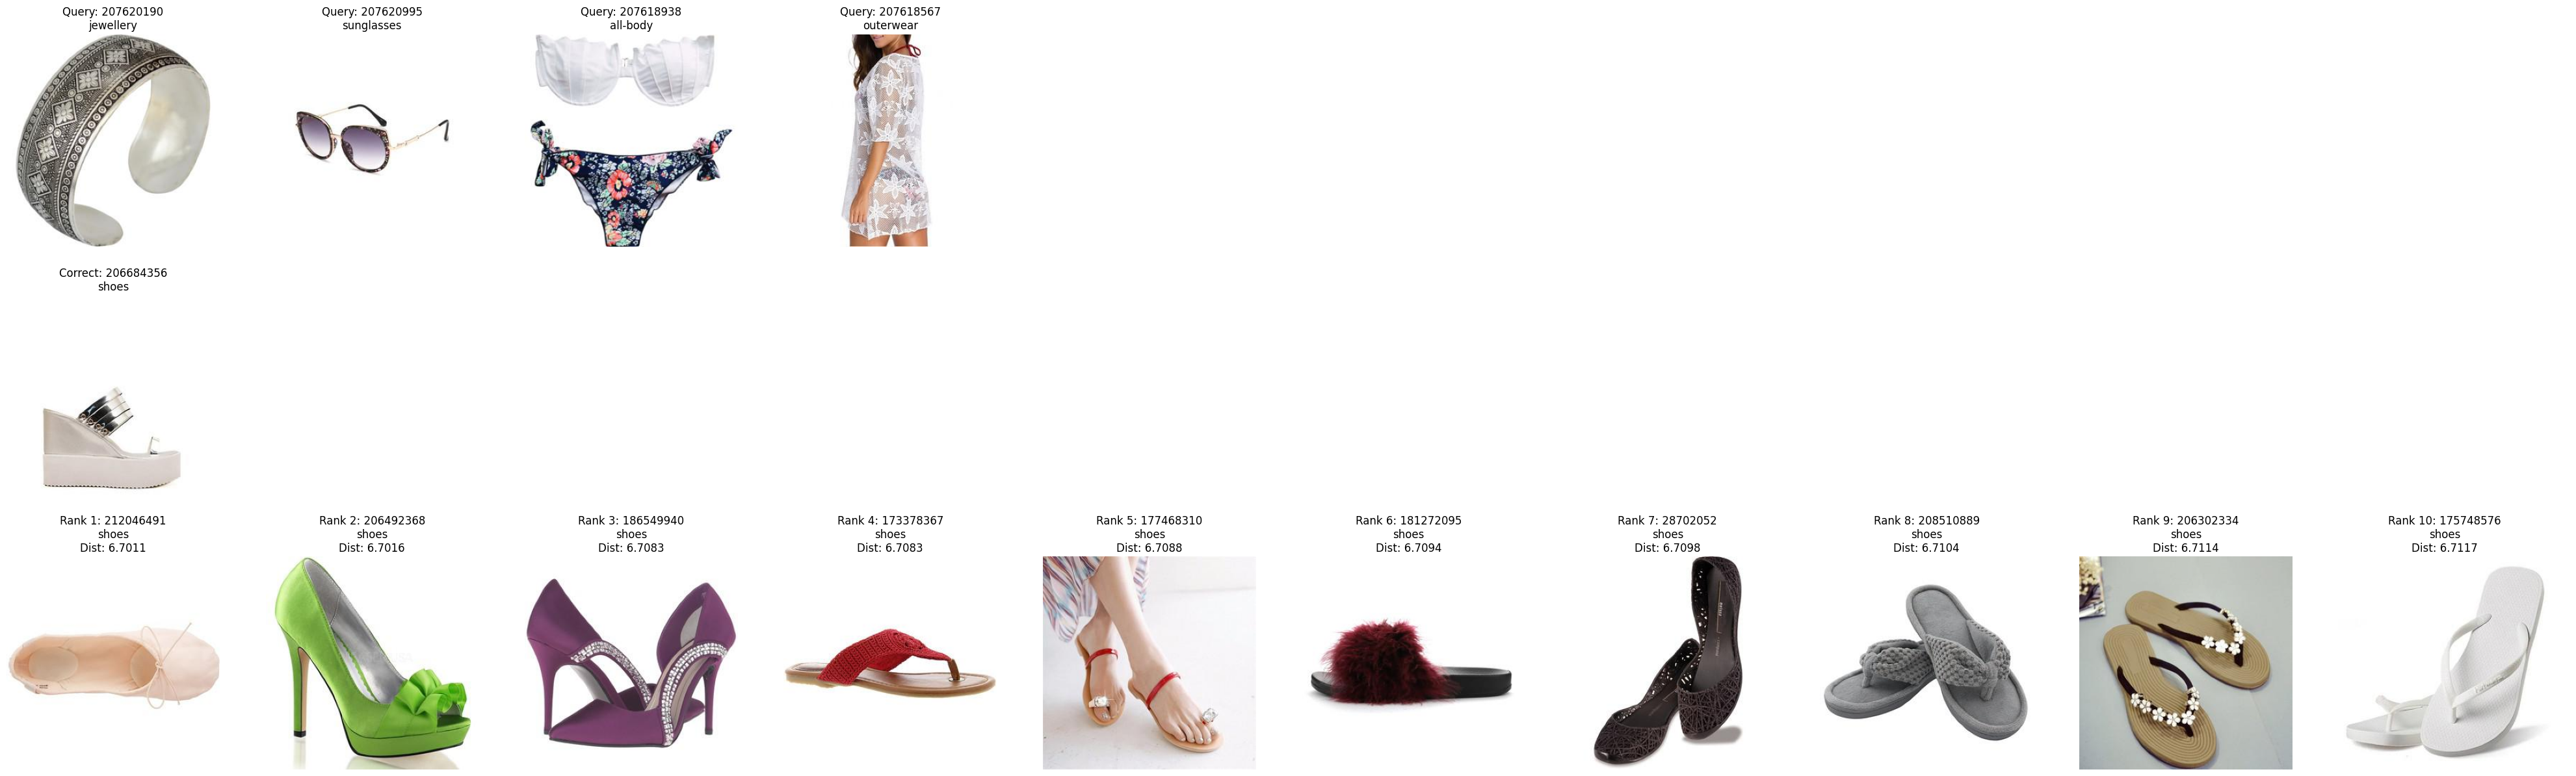

In [19]:
# Section: Visualize CIR Test Example with Top 10 Predictions
#
# This cell loads a CIR checkpoint (epoch_154.pth), selects a random example
# from the test set (valid.json using PolyvoreTripletDataset), and displays:
# - The outfit (query).
# - The correct item to predict (answer).
# - The top 10 predicted items from the entire embedding database, restricted
# to the same category as the answer. Assumes all required functions are defined.

import os
import torch
import random
import matplotlib.pyplot as plt
import numpy as np

# Define paths
CHECKPOINT_DIR = os.path.join(os.getcwd(), 'checkpoints', 'complementary_clip')
POLYVORE_IMAGE_DATA_PATH = f"{POLYVORE_DIR}/images/{{item_id}}.jpg"

# New function to find top k closest items
def find_top_k_items(query_emb, embedding_dict, metadata, target_category, device, k=10):
    """Find the top k closest items in the embedding database for a query embedding.

    Args:
        query_emb (torch.Tensor): Query embedding, shape (d_model,).
        embedding_dict (dict): Dictionary mapping item_id to embedding (1024,).
        metadata (dict): Item metadata with category information.
        target_category (str): Category to restrict the search (e.g., 'shoes').
        device (torch.device): Device for computations.
        k (int): Number of top items to return (default: 10).

    Returns:
        list: List of (item_id, distance) tuples for the top k closest items.
    """
    # Filter items by category
    item_ids = []
    embeddings = []
    for item_id, emb in embedding_dict.items():
        if metadata[item_id]['semantic_category'] == target_category:
            item_ids.append(item_id)
            embeddings.append(emb)
    
    if not embeddings:
        print(f"No items found for category {target_category}")
        return []
    
    # Convert to tensor
    embeddings = torch.from_numpy(np.array(embeddings)).to(dtype=torch.float32, device=device)  # (n_items, 1024)
    
    # Project embeddings to model dimension
    embeddings = model.fc(embeddings)  # (n_items, d_model)
    
    # Compute distances
    query_emb = query_emb.unsqueeze(0)  # (1, d_model)
    dists = torch.norm(query_emb - embeddings, dim=-1)  # (n_items,)
    
    # Get top k indices and distances
    top_k_dists, top_k_indices = torch.topk(dists, k=k, largest=False)
    top_k_items = [(item_ids[idx], dist.item()) for idx, dist in zip(top_k_indices, top_k_dists)]
    
    return top_k_items

# Load test dataset (using valid.json as in your training)
test_cir_dataset = PolyvoreTripletDataset(
    dataset_dir=POLYVORE_DIR,
    dataset_type='nondisjoint',
    dataset_split='valid',
    metadata=metadata,
    embedding_dict=embedding_dict,
    load_image=True  # Load images for visualization
)

# Select a random test example
example_idx = random.randint(0, len(test_cir_dataset) - 1)
example = test_cir_dataset[example_idx]

# Initialize model and load checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OutfitCLIPTransformer(OutfitTransformerConfig(n_items=len(metadata))).to(device)

# Load checkpoint
checkpoint_path = os.path.join(CHECKPOINT_DIR, 'epoch_154.pth')
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Checkpoint {checkpoint_path} not found. Please verify the path.")
model = load_checkpoint(model, checkpoint_path)

# Get model predictions for the example
model.eval()
with torch.no_grad():
    queries = [example['query']]  # Single query
    answer = example['answer']
    answer_id = answer.item_id
    answer_category = answer.category
    
    # Compute query embedding
    query_emb = get_cls_embedding(model, queries, device, 
                                use_precomputed_embedding=True)[0]  # (d_model,)
    
    # Find top 10 closest items
    top_k_items = find_top_k_items(query_emb, embedding_dict, metadata, answer_category, device, k=10)

# Load images for top k items
top_k_items_with_images = []
for item_id, dist in top_k_items:
    item = load_item(POLYVORE_DIR, metadata, item_id, should_load_image=True, embedding_dict=embedding_dict)
    top_k_items_with_images.append((item, dist))

# Print example details
print(f"\nCIR Test Example (Index: {example_idx})")
print("Outfit (Query):")
for item in example['query']:
    print(f"- ID: {item.item_id}, Category: {item.category}")

print("\nCorrect Item (Answer):")
print(f"- ID: {answer_id}, Category: {answer_category}")

print("\nTop 10 Predicted Items:")
for i, (item, dist) in enumerate(top_k_items_with_images):
    is_correct = item.item_id == answer_id
    print(f"- Rank {i+1}: ID: {item.item_id}, Category: {item.category}, Distance: {dist:.4f}, Correct: {'Yes' if is_correct else 'No'}")

# Visualize images
n_query = len(example['query'])
n_top_k = len(top_k_items_with_images)
fig, axes = plt.subplots(3, max(n_query, n_top_k), figsize=(4 * max(n_query, n_top_k), 12))

# Plot query images (outfit)
for i, item in enumerate(example['query']):
    image = item.image
    if image is not None:
        axes[0, i].imshow(image)
        axes[0, i].set_title(f"Query: {item.item_id}\n{item.category}")
    else:
        axes[0, i].text(0.5, 0.5, "Image not available", ha='center', va='center')
    axes[0, i].axis('off')

# Plot correct item (answer)
image = answer.image
if image is not None:
    axes[1, 0].imshow(image)
    axes[1, 0].set_title(f"Correct: {answer_id}\n{answer_category}")
else:
    axes[1, 0].text(0.5, 0.5, "Image not available", ha='center', va='center')
axes[1, 0].axis('off')

# Disable extra axes in correct item row
for i in range(1, max(n_query, n_top_k)):
    axes[1, i].axis('off')

# Plot top k predicted items
for i, (item, dist) in enumerate(top_k_items_with_images):
    image = item.image
    is_correct = item.item_id == answer_id
    title = f"Rank {i+1}: {item.item_id}\n{item.category}\nDist: {dist:.4f}"
    if is_correct:
        title += "\n(Correct)"
    if image is not None:
        axes[2, i].imshow(image)
        axes[2, i].set_title(title)
    else:
        axes[2, i].text(0.5, 0.5, "Image not available", ha='center', va='center')
    axes[2, i].axis('off')

# Disable extra axes
for i in range(n_query, max(n_query, n_top_k)):
    axes[0, i].axis('off')
for i in range(n_top_k, max(n_query, n_top_k)):
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

valid CIR triplet dataset: 5000 sets

CIR Test Example (Index: 653)
Outfit (Query):
- ID: 171626928, Category: hats
- ID: 161621181, Category: all-body

Correct Item (Answer):
- ID: 212119608, Category: shoes

Top 10 Predicted Items:
- Rank 1: ID: 212046491, Category: shoes, Distance: 6.7013, Correct: No
- Rank 2: ID: 206492368, Category: shoes, Distance: 6.7018, Correct: No
- Rank 3: ID: 186549940, Category: shoes, Distance: 6.7083, Correct: No
- Rank 4: ID: 173378367, Category: shoes, Distance: 6.7085, Correct: No
- Rank 5: ID: 177468310, Category: shoes, Distance: 6.7090, Correct: No
- Rank 6: ID: 181272095, Category: shoes, Distance: 6.7096, Correct: No
- Rank 7: ID: 28702052, Category: shoes, Distance: 6.7099, Correct: No
- Rank 8: ID: 208510889, Category: shoes, Distance: 6.7105, Correct: No
- Rank 9: ID: 206302334, Category: shoes, Distance: 6.7115, Correct: No
- Rank 10: ID: 175748576, Category: shoes, Distance: 6.7120, Correct: No


/tmp/ipykernel_3527040/3411938486.py:199: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_availab

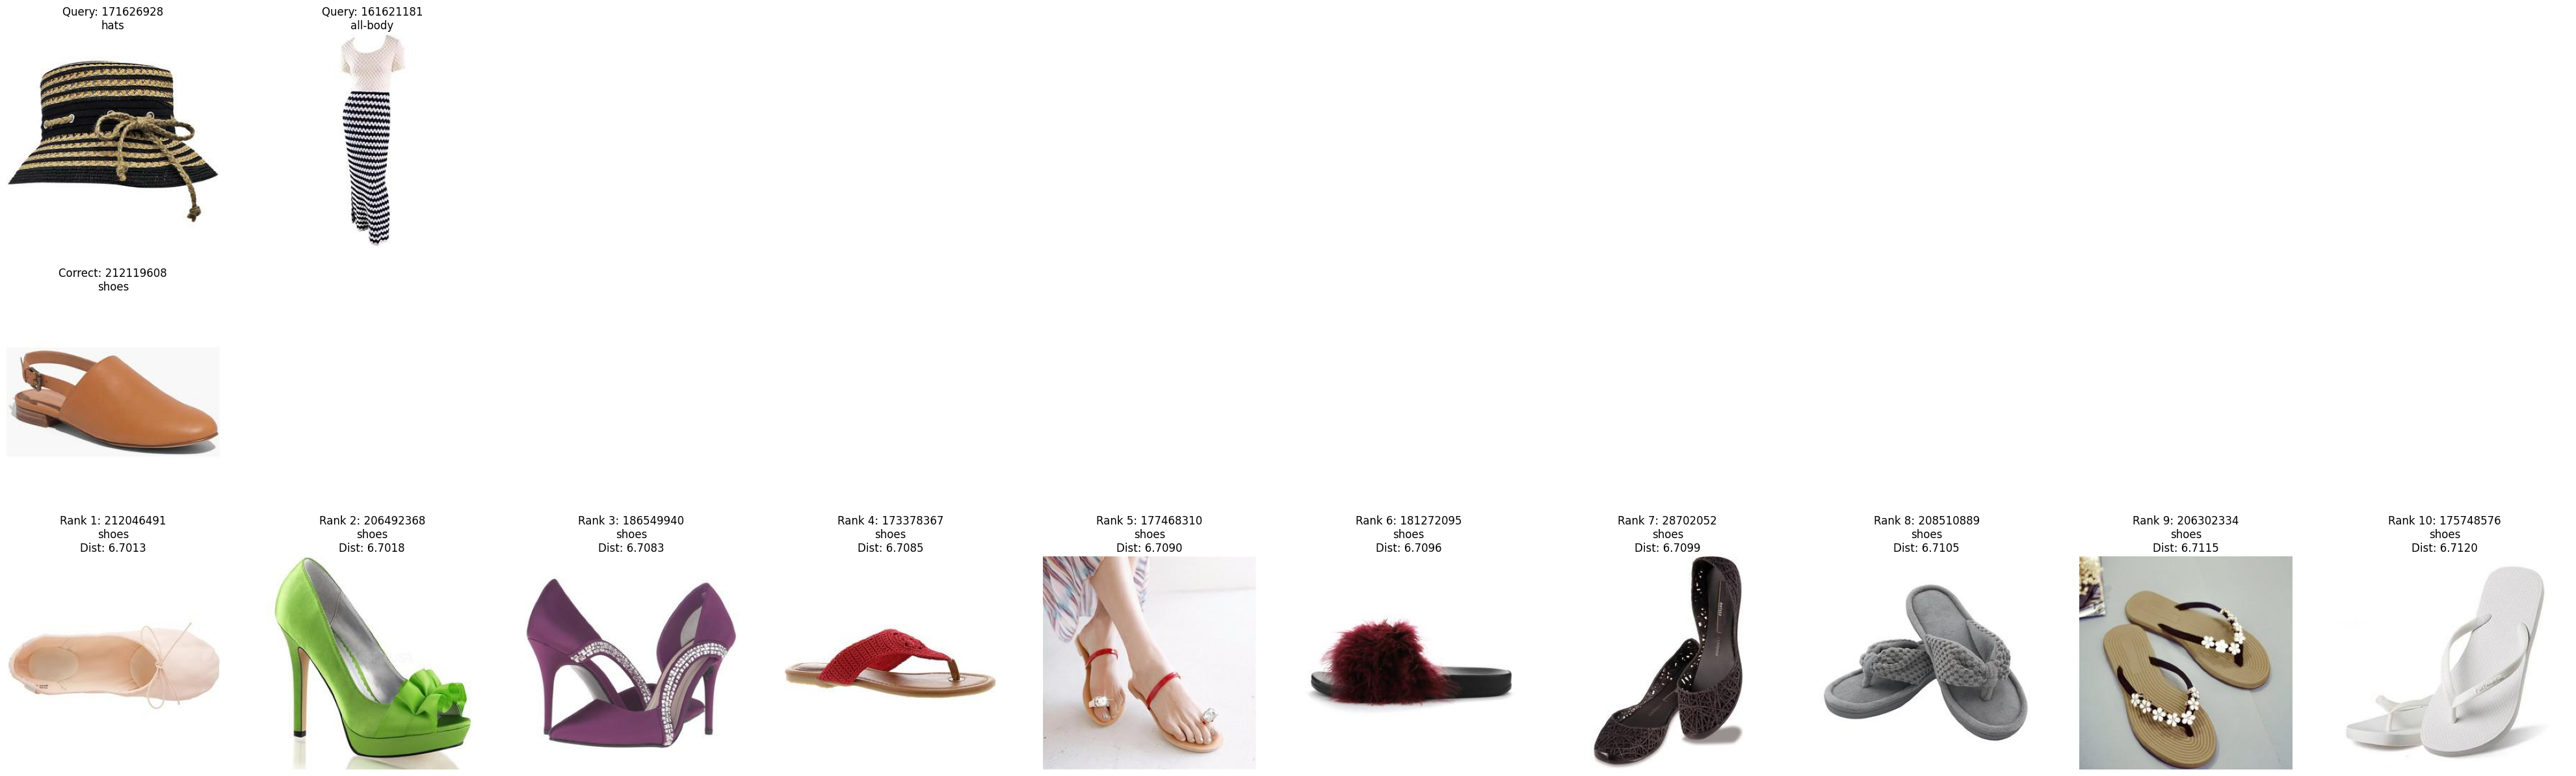

In [62]:
# Section: Visualize CIR Test Example with Top 10 Predictions
#
# This cell loads a CIR checkpoint (epoch_154.pth), selects a random example
# from the test set (valid.json using PolyvoreTripletDataset), and displays:
# - The outfit (query).
# - The correct item to predict (answer).
# - The top 10 predicted items from the entire embedding database, restricted
# to the same category as the answer. Assumes all required functions are defined.

import os
import torch
import random
import matplotlib.pyplot as plt
import numpy as np

# Define paths
CHECKPOINT_DIR = os.path.join(os.getcwd(), 'checkpoints', 'complementary_clip')
POLYVORE_IMAGE_DATA_PATH = f"{POLYVORE_DIR}/images/{{item_id}}.jpg"

# New function to find top k closest items
def find_top_k_items(query_emb, embedding_dict, metadata, target_category, device, k=10):
    """Find the top k closest items in the embedding database for a query embedding.

    Args:
        query_emb (torch.Tensor): Query embedding, shape (d_model,).
        embedding_dict (dict): Dictionary mapping item_id to embedding (1024,).
        metadata (dict): Item metadata with category information.
        target_category (str): Category to restrict the search (e.g., 'shoes').
        device (torch.device): Device for computations.
        k (int): Number of top items to return (default: 10).

    Returns:
        list: List of (item_id, distance) tuples for the top k closest items.
    """
    # Filter items by category
    item_ids = []
    embeddings = []
    for item_id, emb in embedding_dict.items():
        if metadata[item_id]['semantic_category'] == target_category:
            item_ids.append(item_id)
            embeddings.append(emb)
    
    if not embeddings:
        print(f"No items found for category {target_category}")
        return []
    
    # Convert to tensor
    embeddings = torch.from_numpy(np.array(embeddings)).to(dtype=torch.float32, device=device)  # (n_items, 1024)
    
    # Project embeddings to model dimension
    embeddings = model.fc(embeddings)  # (n_items, d_model)
    
    # Compute distances
    query_emb = query_emb.unsqueeze(0)  # (1, d_model)
    dists = torch.norm(query_emb - embeddings, dim=-1)  # (n_items,)
    
    # Get top k indices and distances
    top_k_dists, top_k_indices = torch.topk(dists, k=k, largest=False)
    top_k_items = [(item_ids[idx], dist.item()) for idx, dist in zip(top_k_indices, top_k_dists)]
    
    return top_k_items

# Load test dataset (using valid.json as in your training)
test_cir_dataset = PolyvoreTripletDataset(
    dataset_dir=POLYVORE_DIR,
    dataset_type='nondisjoint',
    dataset_split='valid',
    metadata=metadata,
    embedding_dict=embedding_dict,
    load_image=True  # Load images for visualization
)

# Select a random test example
example_idx = random.randint(0, len(test_cir_dataset) - 1)
example = test_cir_dataset[example_idx]

# Initialize model and load checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OutfitCLIPTransformer(OutfitTransformerConfig(n_items=len(metadata))).to(device)

# Load checkpoint
checkpoint_path = os.path.join(CHECKPOINT_DIR, 'epoch_154.pth')
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Checkpoint {checkpoint_path} not found. Please verify the path.")
model = load_checkpoint(model, checkpoint_path)

# Get model predictions for the example
model.eval()
with torch.no_grad():
    queries = [example['query']]  # Single query
    answer = example['answer']
    answer_id = answer.item_id
    answer_category = answer.category
    
    # Compute query embedding
    query_emb = get_cls_embedding(model, queries, device, 
                                use_precomputed_embedding=True)[0]  # (d_model,)
    
    # Find top 10 closest items
    top_k_items = find_top_k_items(query_emb, embedding_dict, metadata, answer_category, device, k=10)

# Load images for top k items
top_k_items_with_images = []
for item_id, dist in top_k_items:
    item = load_item(POLYVORE_DIR, metadata, item_id, should_load_image=True, embedding_dict=embedding_dict)
    top_k_items_with_images.append((item, dist))

# Print example details
print(f"\nCIR Test Example (Index: {example_idx})")
print("Outfit (Query):")
for item in example['query']:
    print(f"- ID: {item.item_id}, Category: {item.category}")

print("\nCorrect Item (Answer):")
print(f"- ID: {answer_id}, Category: {answer_category}")

print("\nTop 10 Predicted Items:")
for i, (item, dist) in enumerate(top_k_items_with_images):
    is_correct = item.item_id == answer_id
    print(f"- Rank {i+1}: ID: {item.item_id}, Category: {item.category}, Distance: {dist:.4f}, Correct: {'Yes' if is_correct else 'No'}")

# Visualize images
n_query = len(example['query'])
n_top_k = len(top_k_items_with_images)
fig, axes = plt.subplots(3, max(n_query, n_top_k), figsize=(4 * max(n_query, n_top_k), 12))

# Plot query images (outfit)
for i, item in enumerate(example['query']):
    image = item.image
    if image is not None:
        axes[0, i].imshow(image)
        axes[0, i].set_title(f"Query: {item.item_id}\n{item.category}")
    else:
        axes[0, i].text(0.5, 0.5, "Image not available", ha='center', va='center')
    axes[0, i].axis('off')

# Plot correct item (answer)
image = answer.image
if image is not None:
    axes[1, 0].imshow(image)
    axes[1, 0].set_title(f"Correct: {answer_id}\n{answer_category}")
else:
    axes[1, 0].text(0.5, 0.5, "Image not available", ha='center', va='center')
axes[1, 0].axis('off')

# Disable extra axes in correct item row
for i in range(1, max(n_query, n_top_k)):
    axes[1, i].axis('off')

# Plot top k predicted items
for i, (item, dist) in enumerate(top_k_items_with_images):
    image = item.image
    is_correct = item.item_id == answer_id
    title = f"Rank {i+1}: {item.item_id}\n{item.category}\nDist: {dist:.4f}"
    if is_correct:
        title += "\n(Correct)"
    if image is not None:
        axes[2, i].imshow(image)
        axes[2, i].set_title(title)
    else:
        axes[2, i].text(0.5, 0.5, "Image not available", ha='center', va='center')
    axes[2, i].axis('off')

# Disable extra axes
for i in range(n_query, max(n_query, n_top_k)):
    axes[0, i].axis('off')
for i in range(n_top_k, max(n_query, n_top_k)):
    axes[2, i].axis('off')



plt.tight_layout()
plt.show()